# Bushfire Analysis Using Meteorological Data

Programming Language: R 4.0 in Jupyter Notebook

R Libraries used:
- GGally
- ggstatsplot
- reshape2
- caTools
- gridExtra
- class
- mltools
- data.table
- FNN
- tree
- randomForest
- e1071
- MASS
- MLmetrics
- dplyr
- ggsci
- scales
- glmnet
- DAAG

In this project, a data file `forestfires.csv` contains the structure data about the forest fire in Australia (Cortez & Morais, 2007). Using this file to explore the data,
developing models, choosing the best model and analyzing the results. These sections contain the codes, visualizations and justifications.

## Table of Contents

* [Load Data](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)

## Import Libraries

In [37]:
options(warn = -1, repr.plot.width=15, repr.plot.height=15)

library(GGally)
library(ggstatsplot)
library(reshape2)
library(caTools)
library(gridExtra)
library(class)
library(mltools)
library(data.table)
library(FNN)
library(tree)
library(MASS)
library(MLmetrics)
library(dplyr)
library(ggsci)
library(scales)
library(glmnet)
library(boot)

In [39]:
## set Material colors
get_material_color <- function(color) pal_material(color)(10)[4]
blue <- get_material_color("blue")
purple <- get_material_color("purple")
red <- get_material_color("red")
indigo <- get_material_color("indigo")
green <- get_material_color("green")
gray <- get_material_color("grey")
white <- "white"

## 1. Load data <a class="anchor" id="sec_1"></a>

The data are contained in the `forestfires.csv`. From the inside of the csv file, it is clearly that, all attributes are numerical except the `month` and the `day`.
Therefore, as the preparation of machine learning in R (R-project, 2020), the string type of `month` and `day` need to be convert to factor type.

After loading it, print the structure for better understanding of the data.

In [41]:
### Load data
fire_data <- read.csv("forestfires.csv")
categorical_vars <- c("month", "day")
fire_data$month <- fire_data$month %>% as.factor
fire_data$day <- fire_data$day %>% as.factor
numerical_vars <- names(fire_data) %>% setdiff(categorical_vars) %>% setdiff("area")
str(fire_data)

'data.frame':	517 obs. of  13 variables:
 $ X    : int  7 7 7 8 8 8 8 8 8 7 ...
 $ Y    : int  5 4 4 6 6 6 6 6 6 5 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 8 11 11 8 8 2 2 2 12 12 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC  : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC   : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI  : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH   : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area : num  0 0 0 0 0 0 0 0 0 0 ...


From the output, there are 517 rows(records) and 12 features, and the `area` is the target of modelling. All features except `month` and `day` are numerical as expected.

In [43]:
summary(fire_data)

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

From the output of `summary` function, there are several outliers in these features, such as `FFMC`, `DMC`, `DC` and `rain`,
but the decision of whether the outliers need to be removed will be considered in data exploration section.

Then, it is time to do EDA.

## 2. Data Exploration<a class="anchor" id="sec_2"></a>

In this section, the data exploration will be included here. First of all, use `GGally::ggpairs` function to show the correlation between features and the `area` (Schloerke, 2020).

First of all, display the correlations between numerical features and the target `area`.

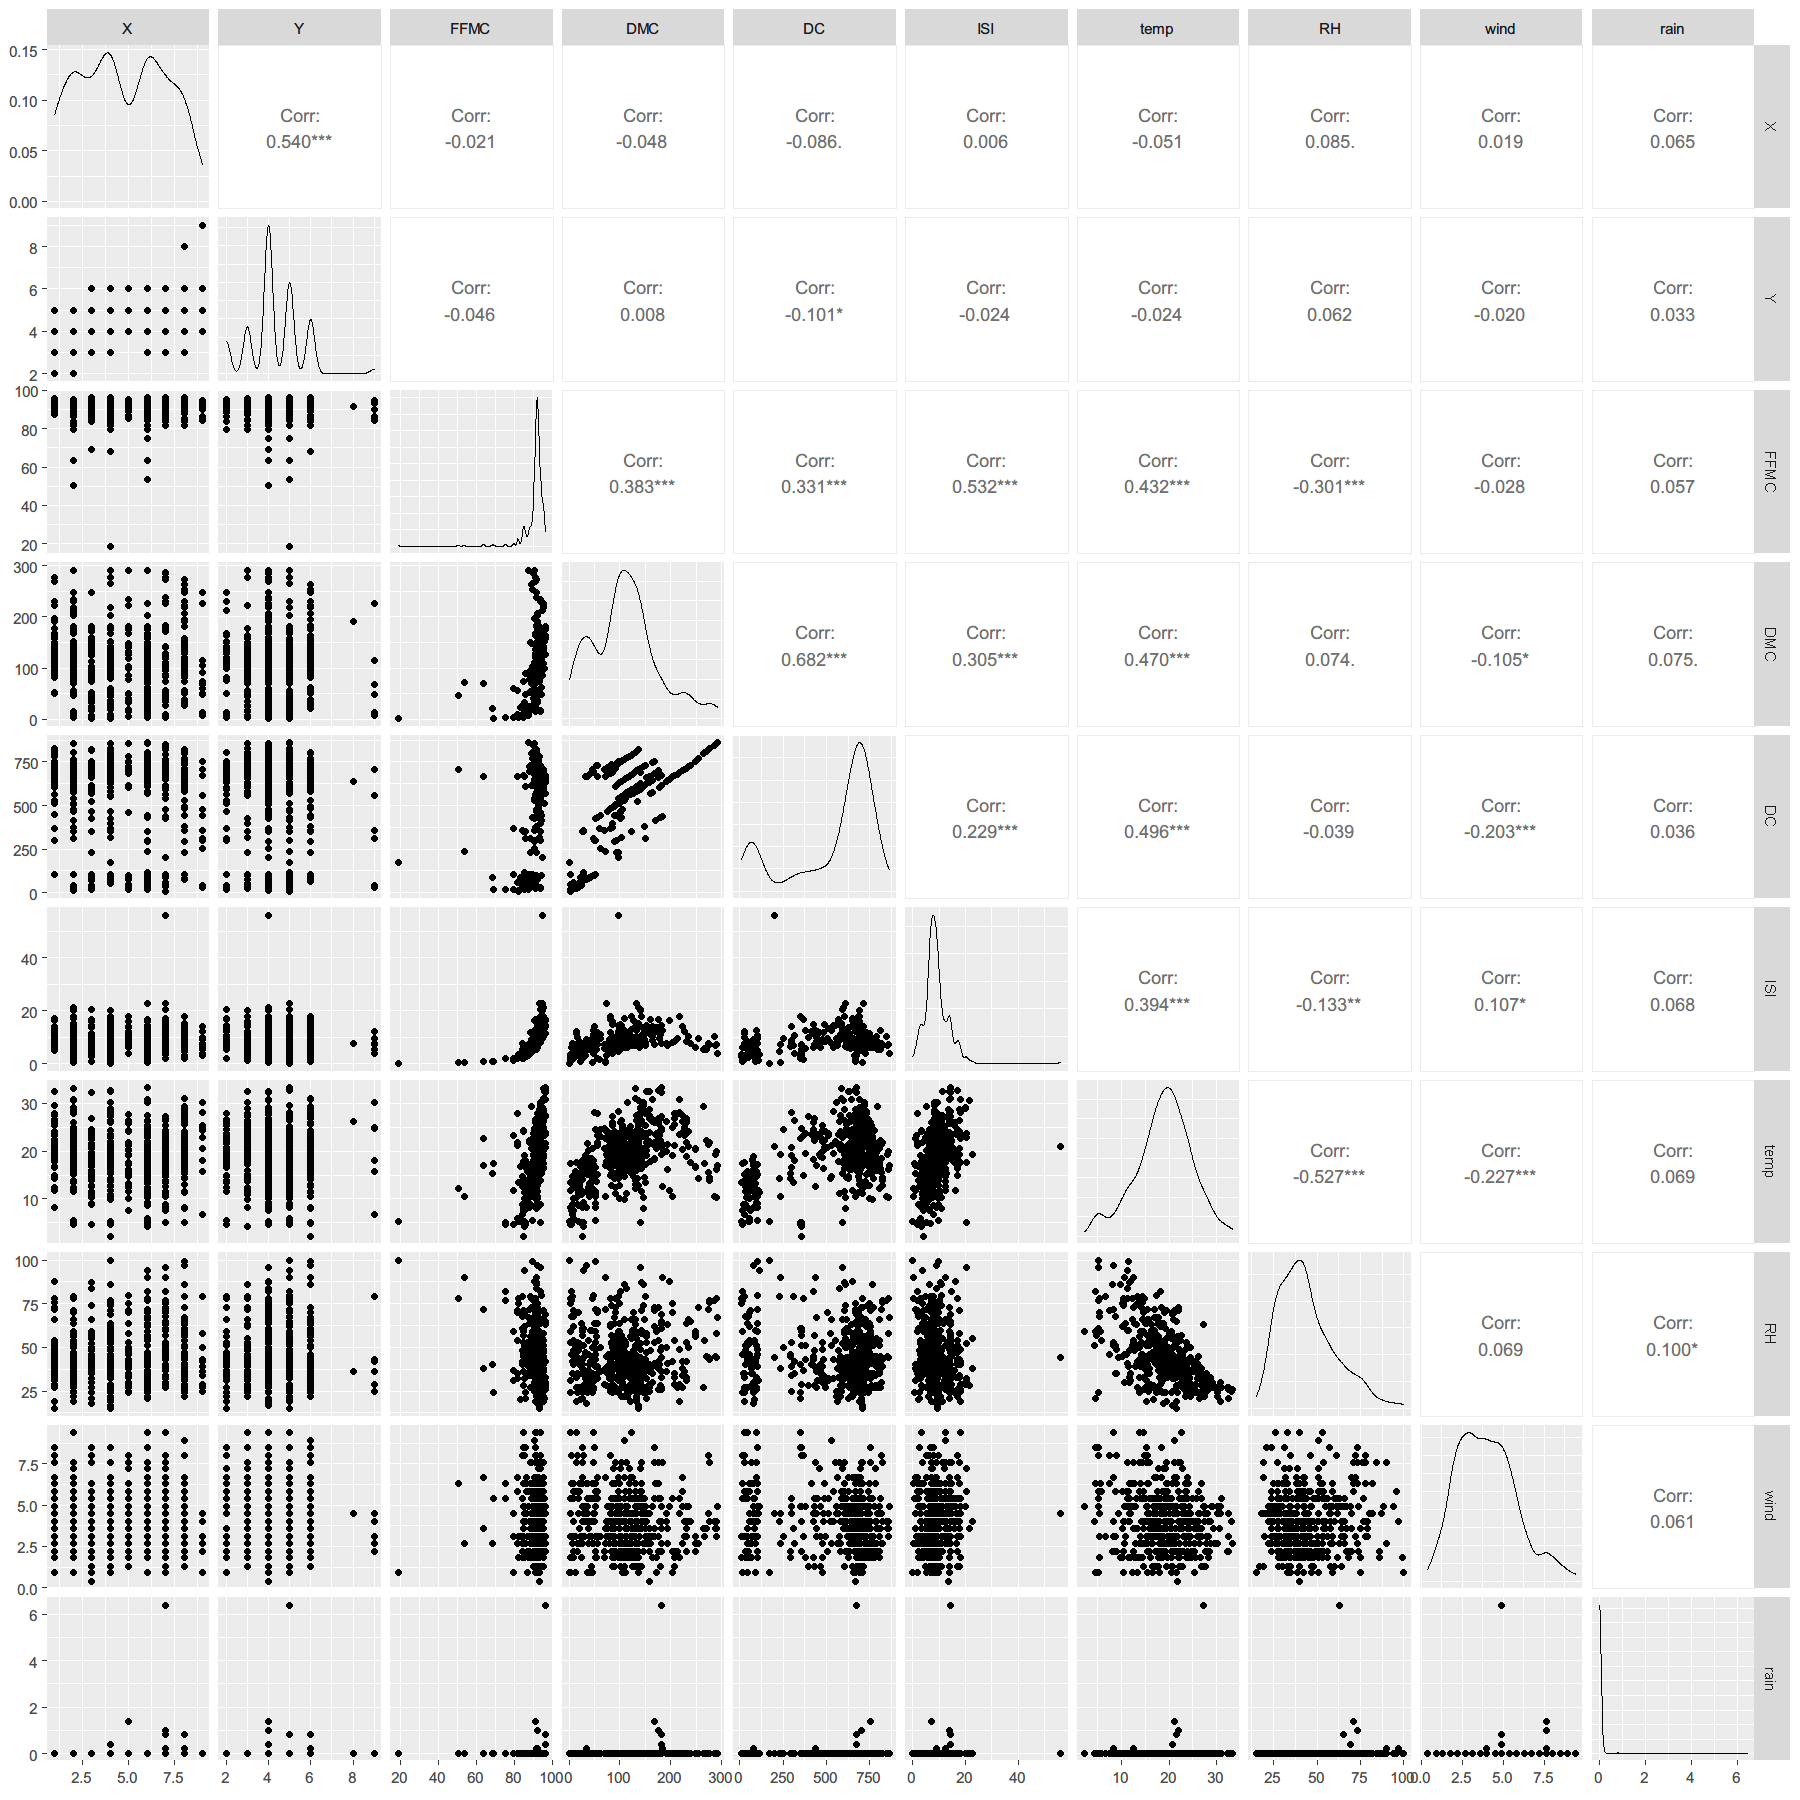

In [45]:
ggpairs(fire_data[numerical_vars])

From the output, there is some significant outliers in `FFMC`, `ISI` and `rain`. These outliers need to be discussed later.
The correlation between the area and the features are not significant. The correlation between `DMC` and `DC` is significant, but for others, it is hard to see if there
is some linear correlations.

From the pdf (probability density function) of the numerical columns, the `rain` and `area` has large quantity data when the value is 0. Therefore, it is possible to preprocess
the rain numerical data as a boolean feature `is_rainy` and the `fire` from `area` as well.

Then, the `ggstatsplot::ggcorrmat` is applied for clearer visualization for correlations between columns (IndrajeetPatil, 2020).

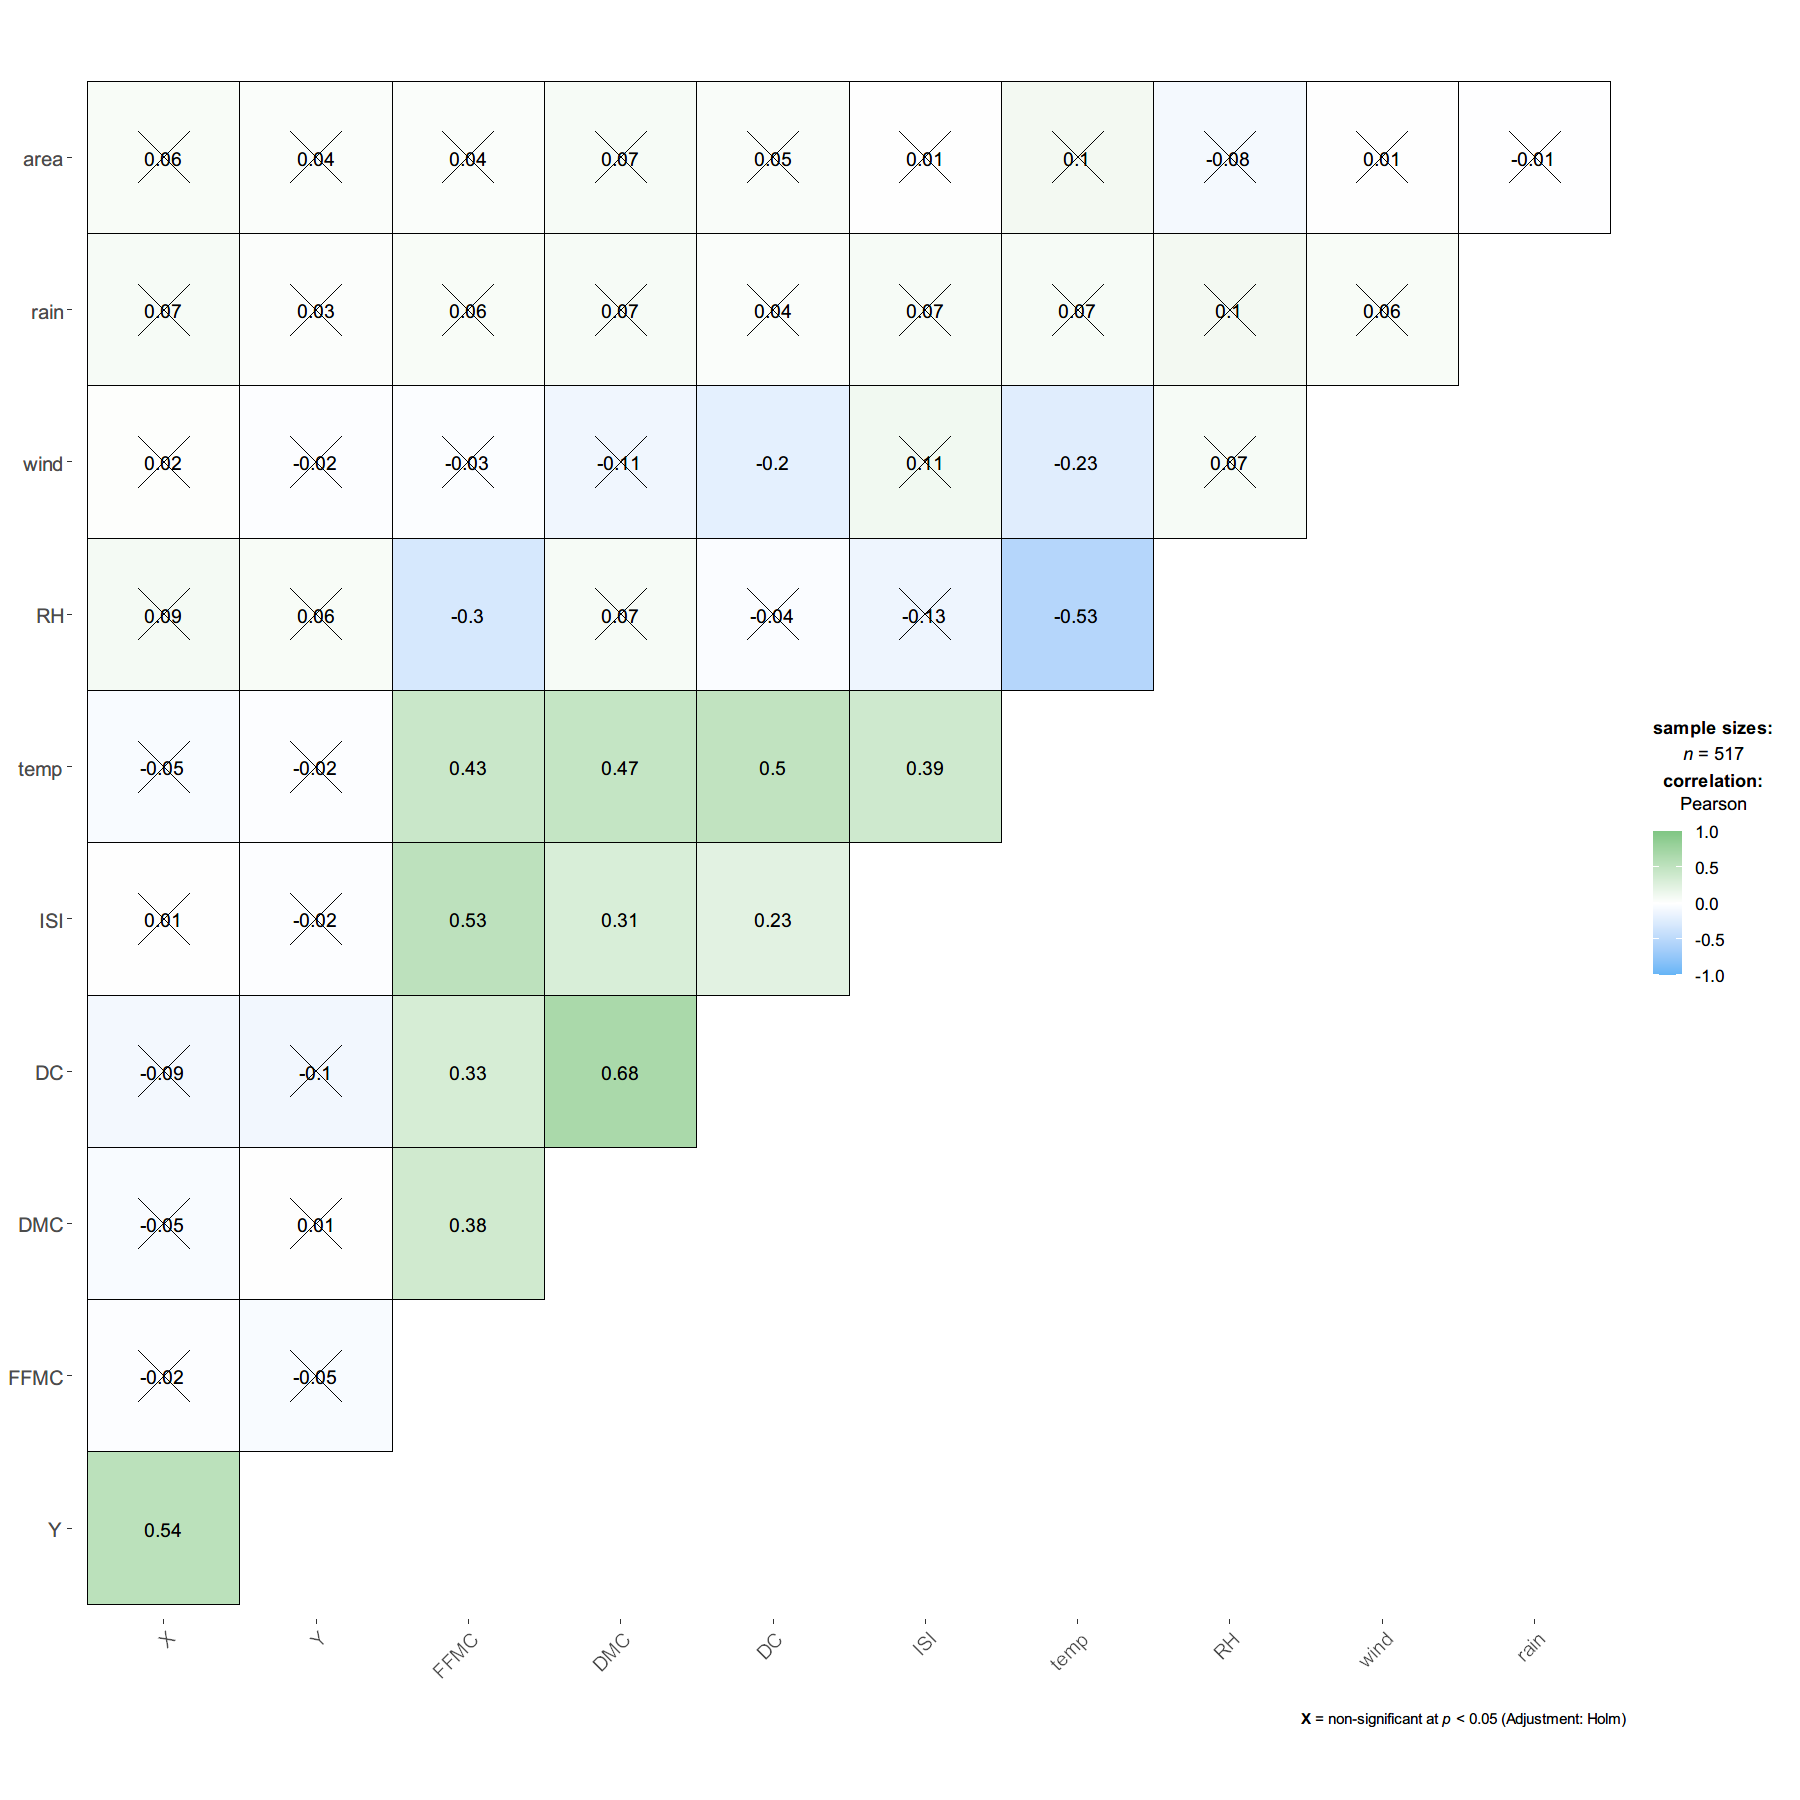

In [47]:
ggcorrmat(fire_data, colors = c(blue, "white", green))

From the output, the `X` and `Y` are only related with each other, and seems less correlated to other columns.
The `FFMC`, `DMC`, `DC`, `ISI`, `temp` has significant correlations between each of them, which are represented as green blocks.
The feature `RH` and `temp` have negative relation. However, the target `area` has few relations between others, because most of them are less 0.1,
which means the featurization is necessary.

Then, using `ggplot2::geom_boxplot` and other `ggplot2` functions to plot the boxplot for all columns (Wickham, et al., 2020).

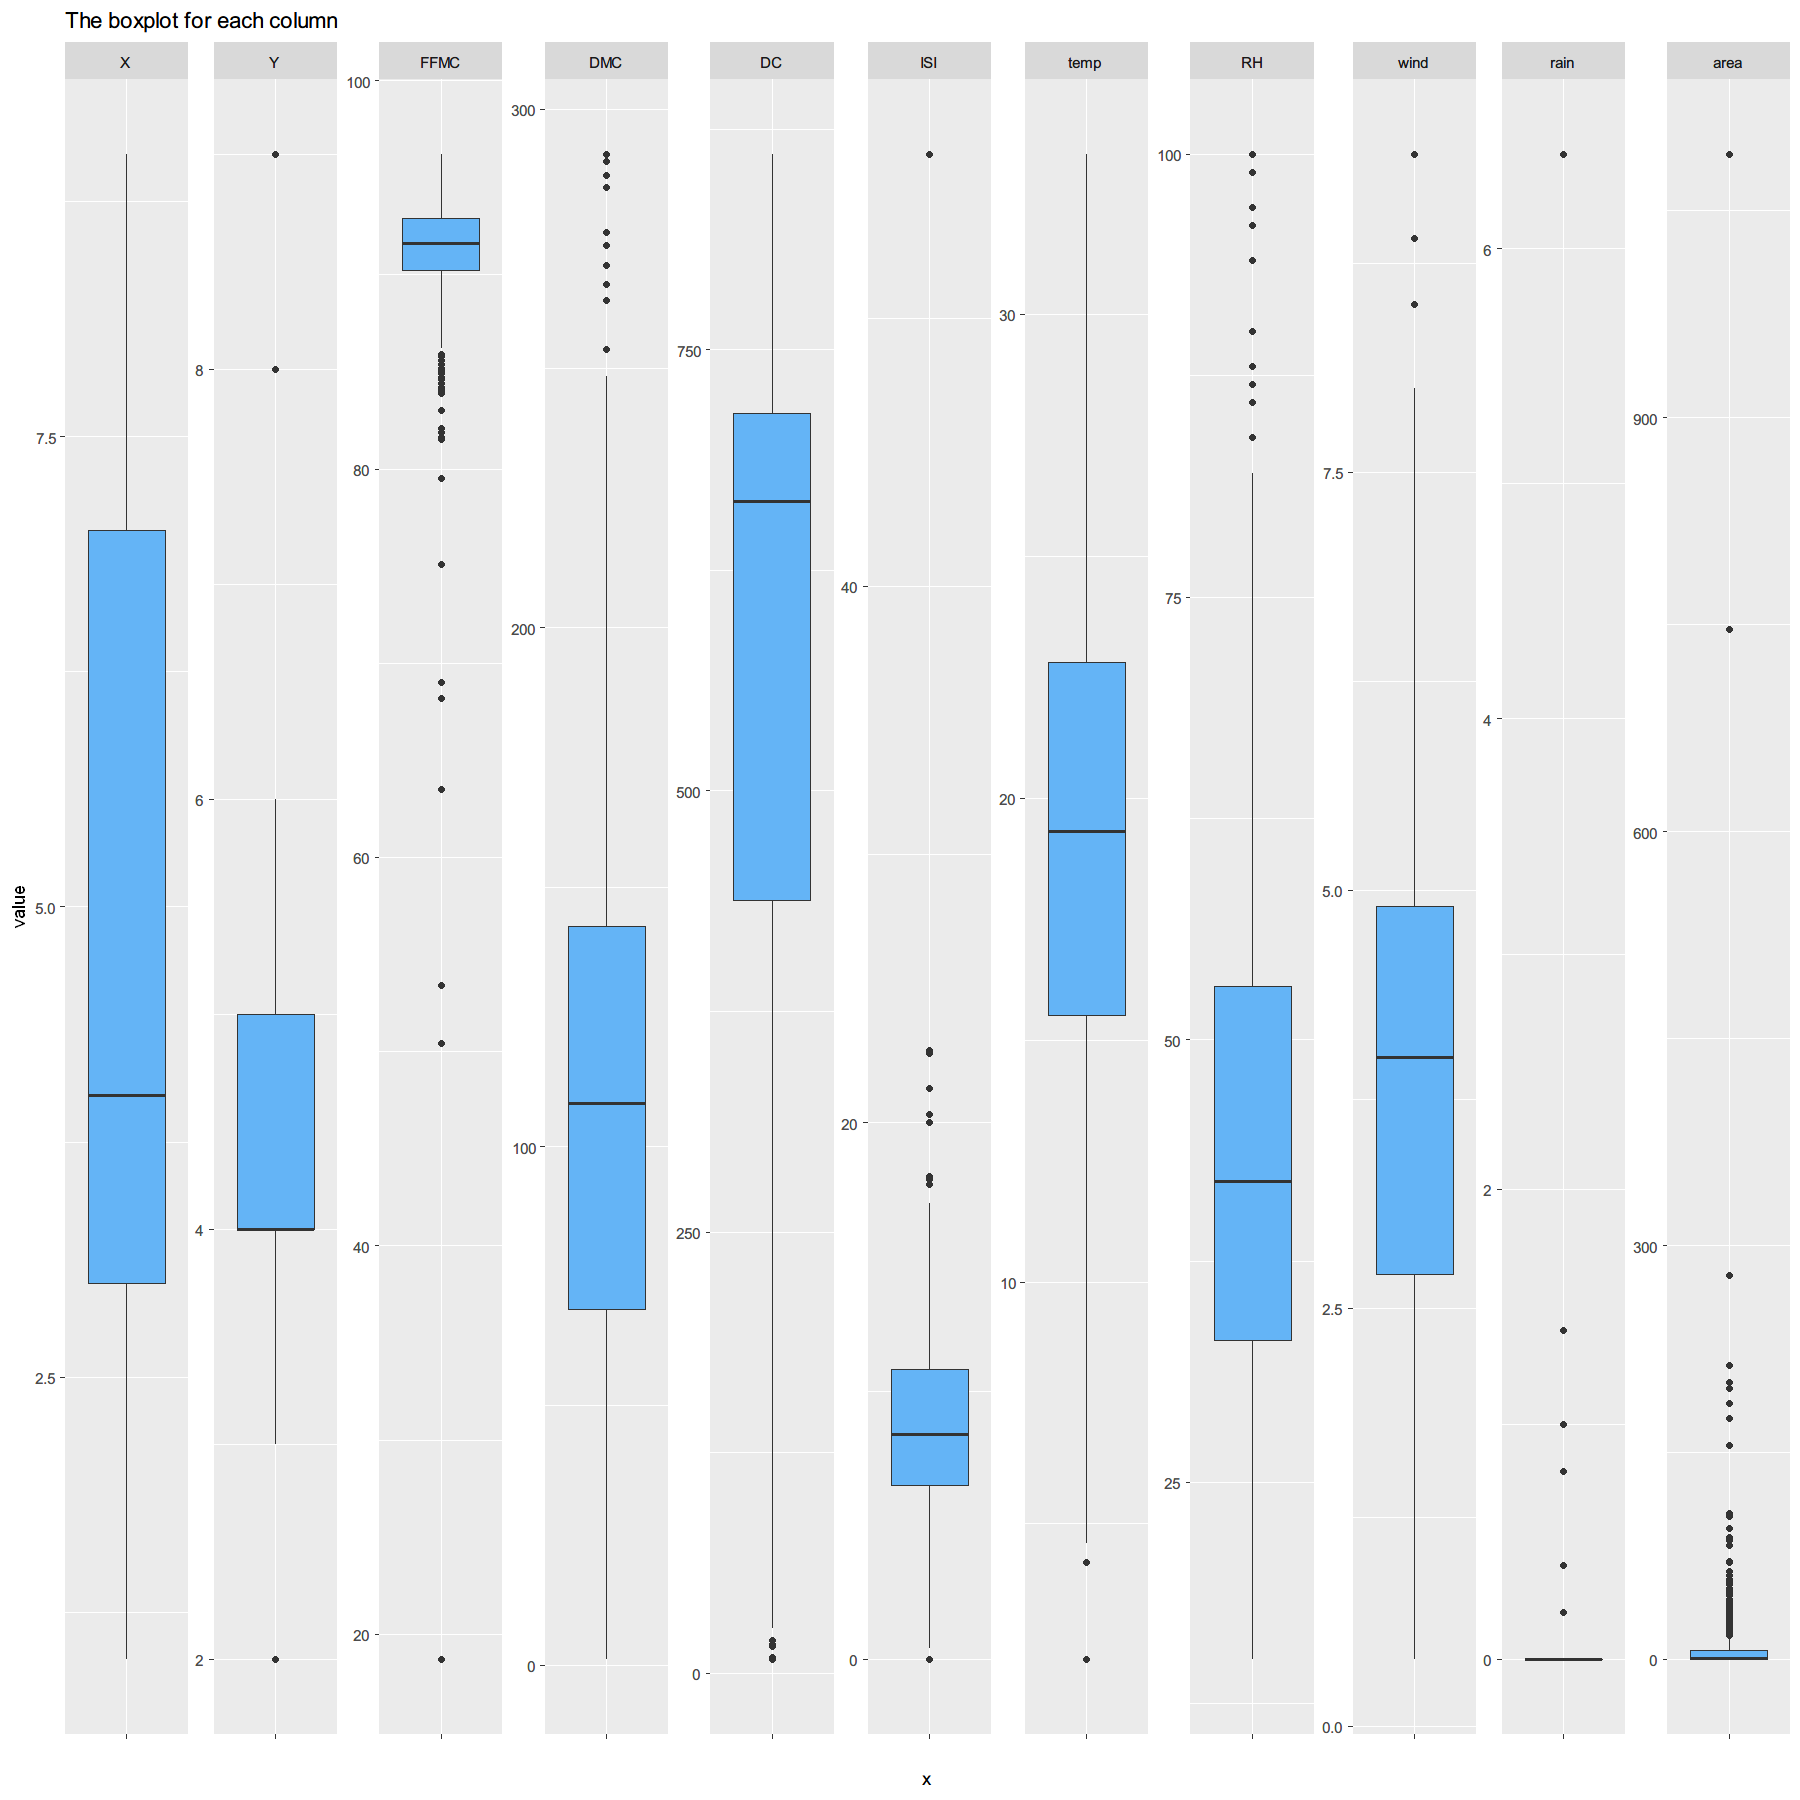

In [49]:
fire_data %>%
  select(-month, -day) %>%
  melt(id.vars = NULL) %>%
  ggplot +
  geom_boxplot(mapping = aes(x = "", y = value), fill = blue) +
  facet_wrap(~variable, scales = "free_y", ncol = 11) +
  ggtitle("The boxplot for each column")

From the boxplot output, it is hard to declare the outliers showed in boxplot are real outliers or not, as they are not completely independent.
However, there are some points are far away from the main cluster.
The feature `X` and `Y`, which indicate the locations, have some outliers, but it is not necessary to be removed, as the value of `Y` is still can be considered without problem.
The `area` is not necessary to be removed as well, because many values of `area` is 0, so the boxplot is not reliable as reference. However, there are still some points are far away
from the main cluster, which has been found in the `FFMC`, `ISI`, and `rain`. These outliers can be considered to be removed.

Then, the jitter scatter distribution of area is displayed below, which is created by `ggplot2::geom_point` and other `ggplot2` functions.

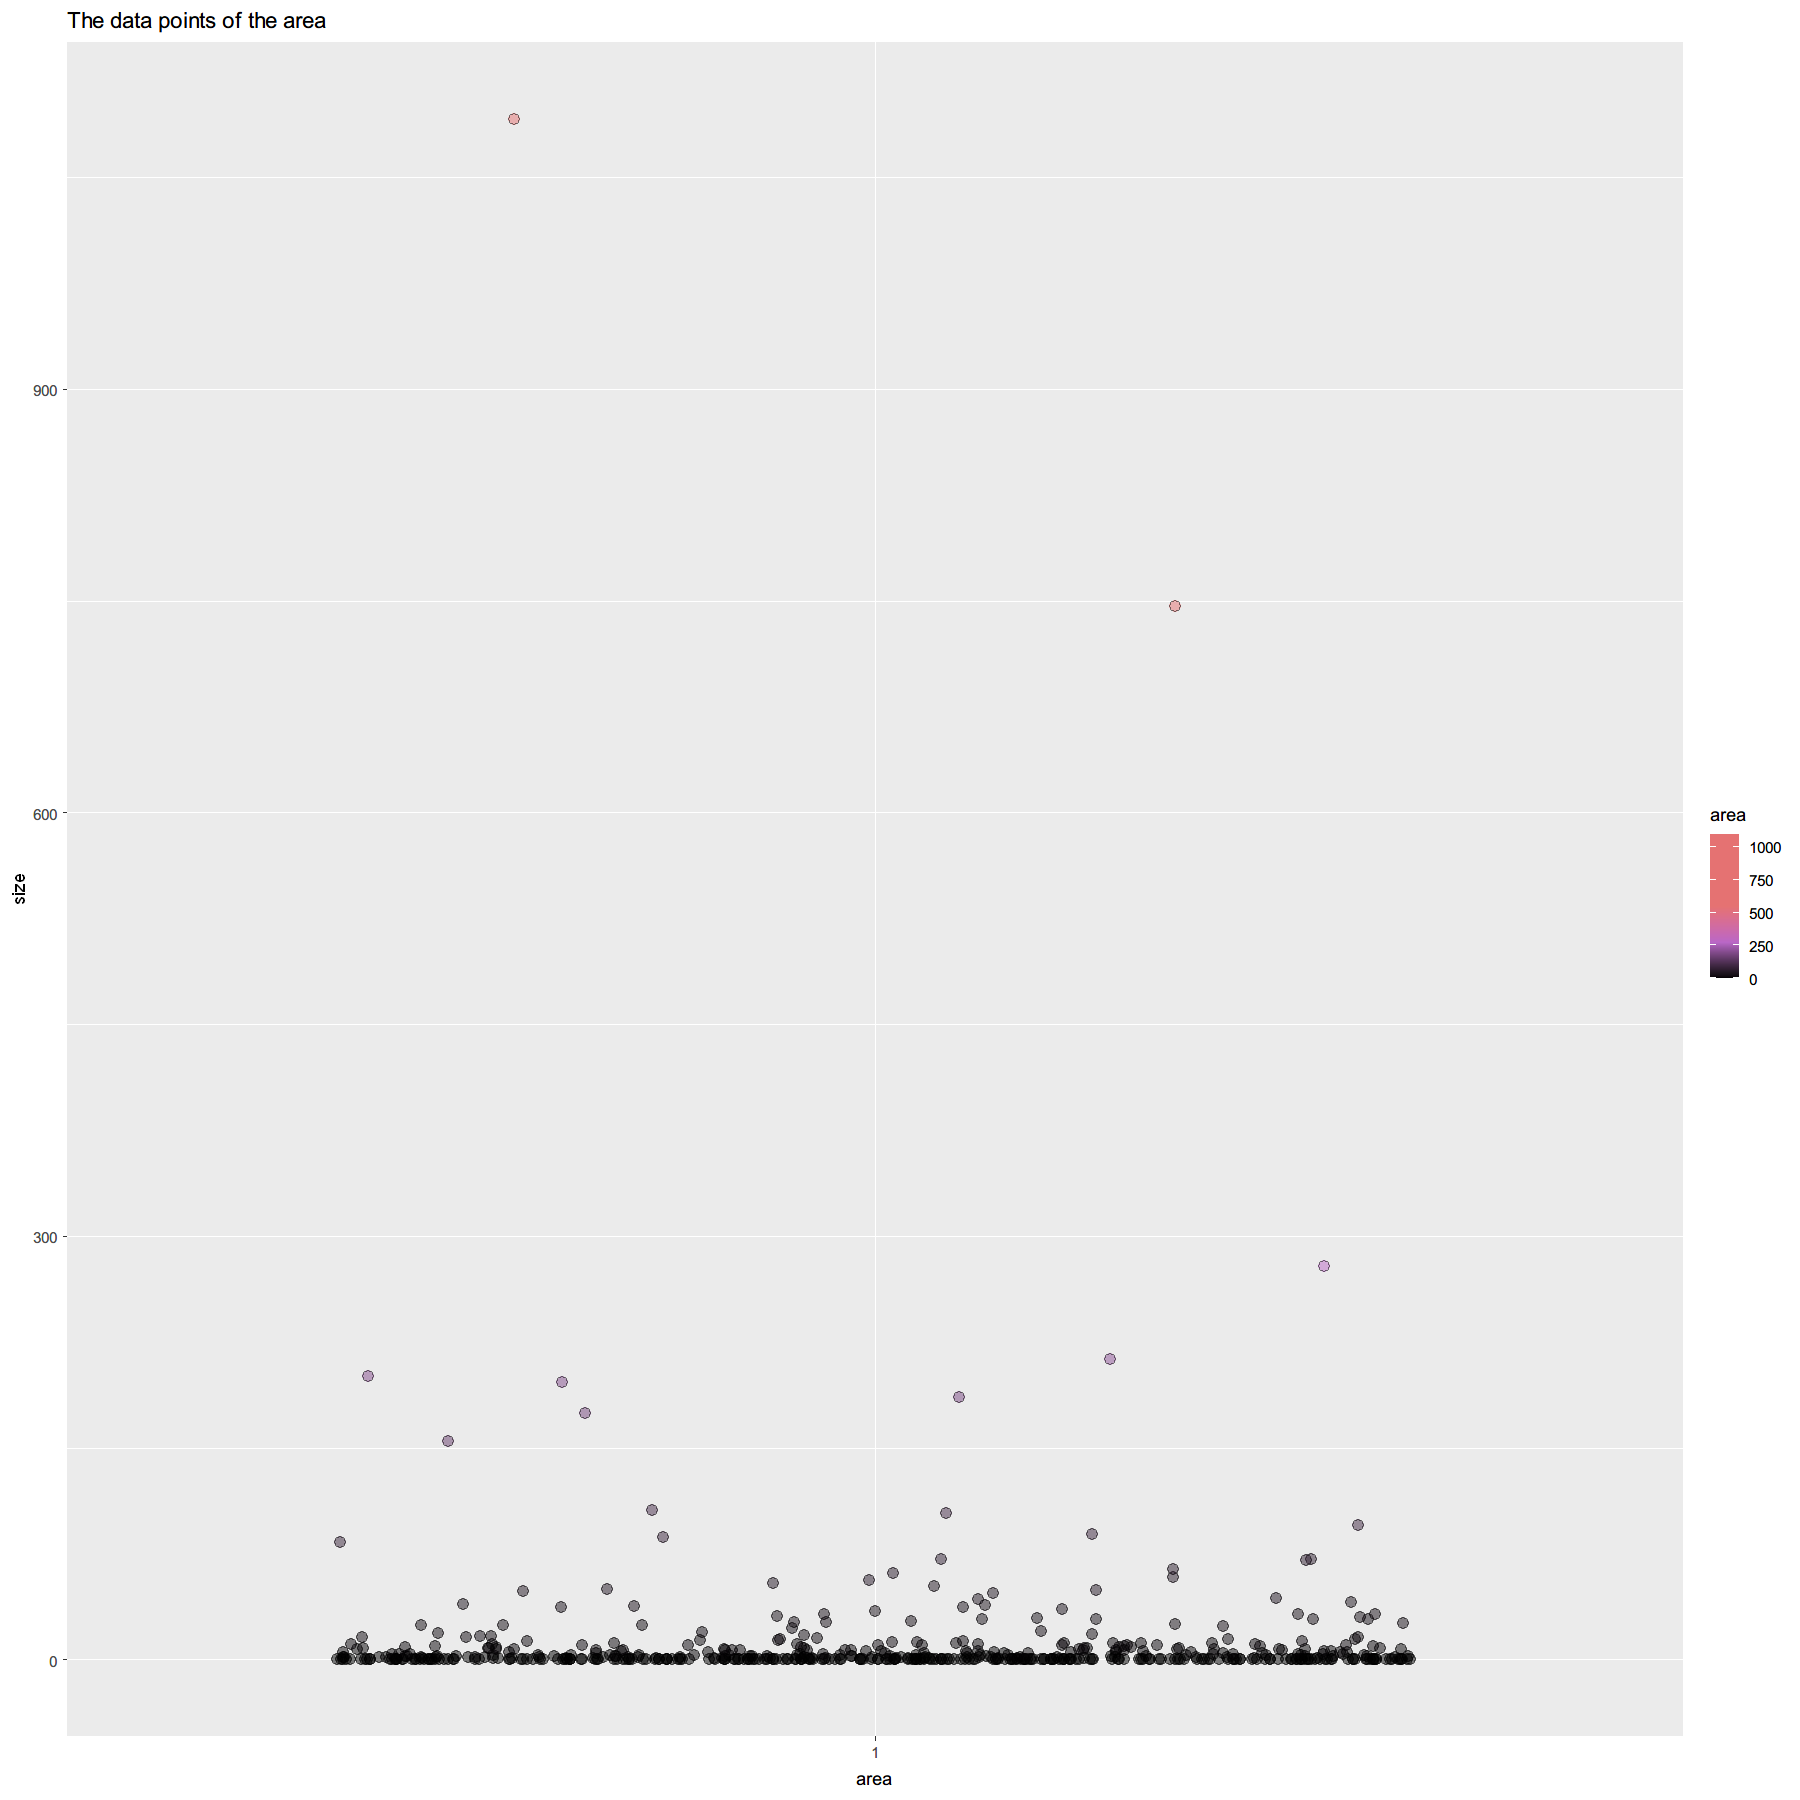

In [51]:
fire_data %>% ggplot() +
  geom_point(aes(x = factor(1), y = area, fill = area), shape = 21, size = 3, color = "black", alpha=0.5, position = "jitter") +
  scale_fill_gradientn(colors = c("black", purple, red, red, red)) +
  xlab("area") + ylab("size") +
  ggtitle("The data points of the area")

From the plot, it is obviously to know the majority of the area are below 300, and many of them are 0.

Then, it is necessary to check the relations of the location of the fire, which is about the feature `X` and `Y`.
Therefore, plot a pair plot for `X`, `Y` and `area` by `GGally::ggpairs`.

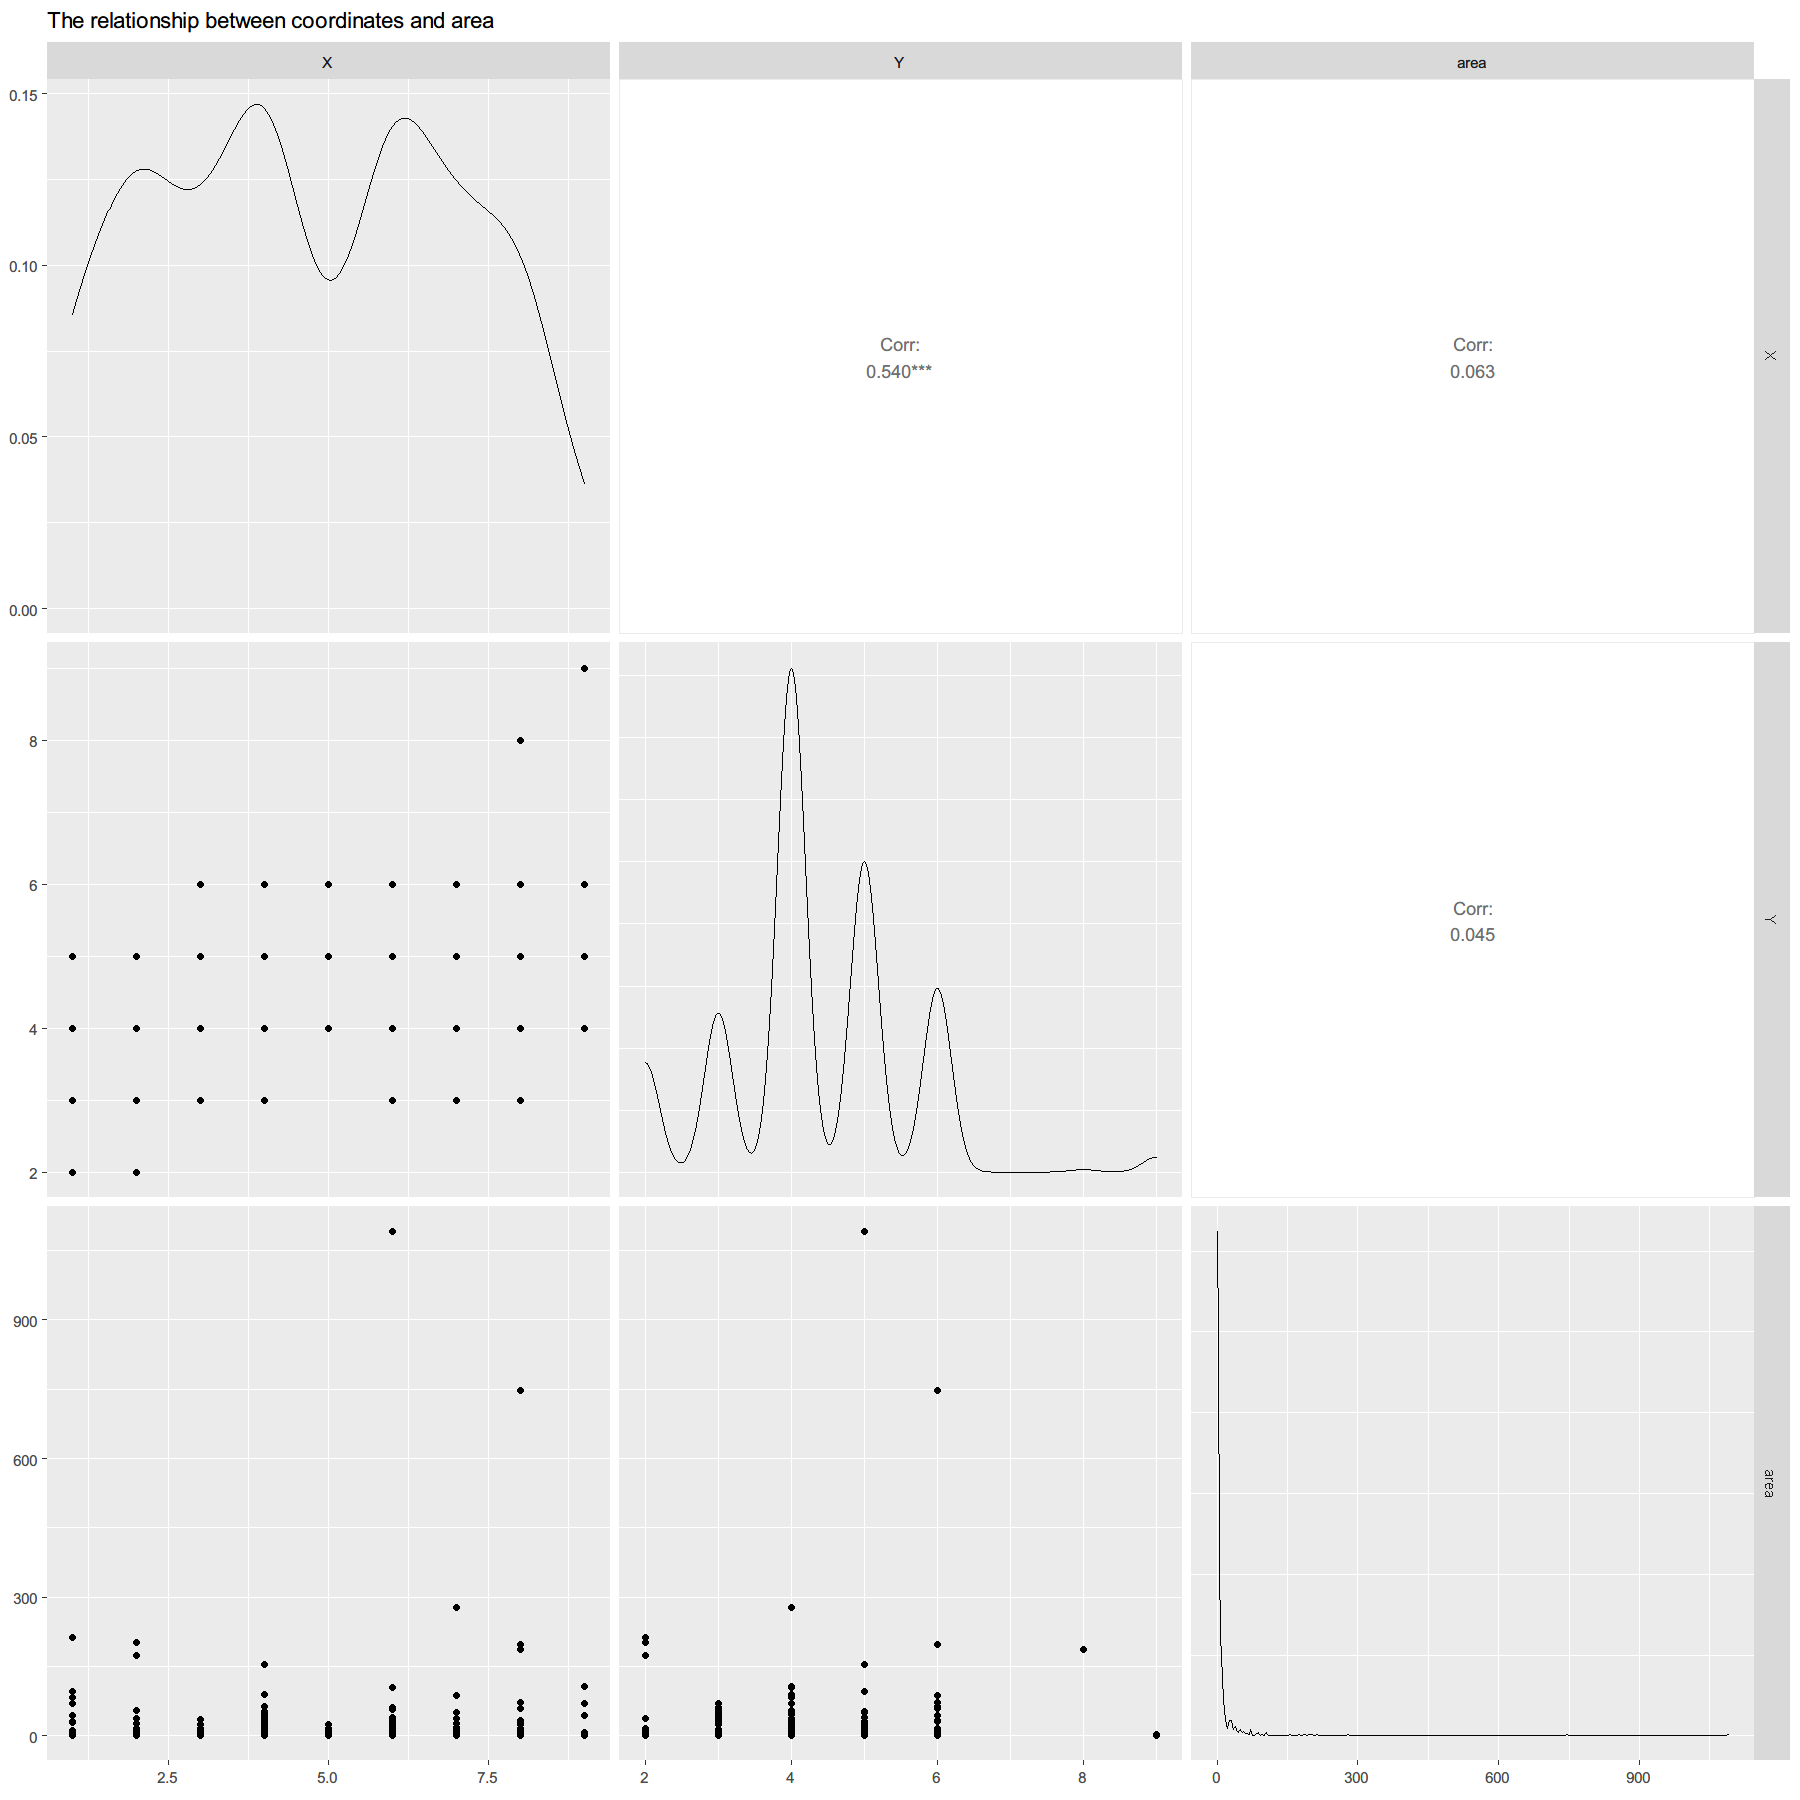

In [53]:
fire_data %>%
  select(X, Y, area) %>%
  ggpairs(title = "The relationship between coordinates and area")

Seems no significant correlation between coordinates (`X` and `Y`) with `area`.
However, the relation between `X` and `Y` is significant.

Then, the scatters of the area against each numerical features are plotted by `GGally::ggduo`.

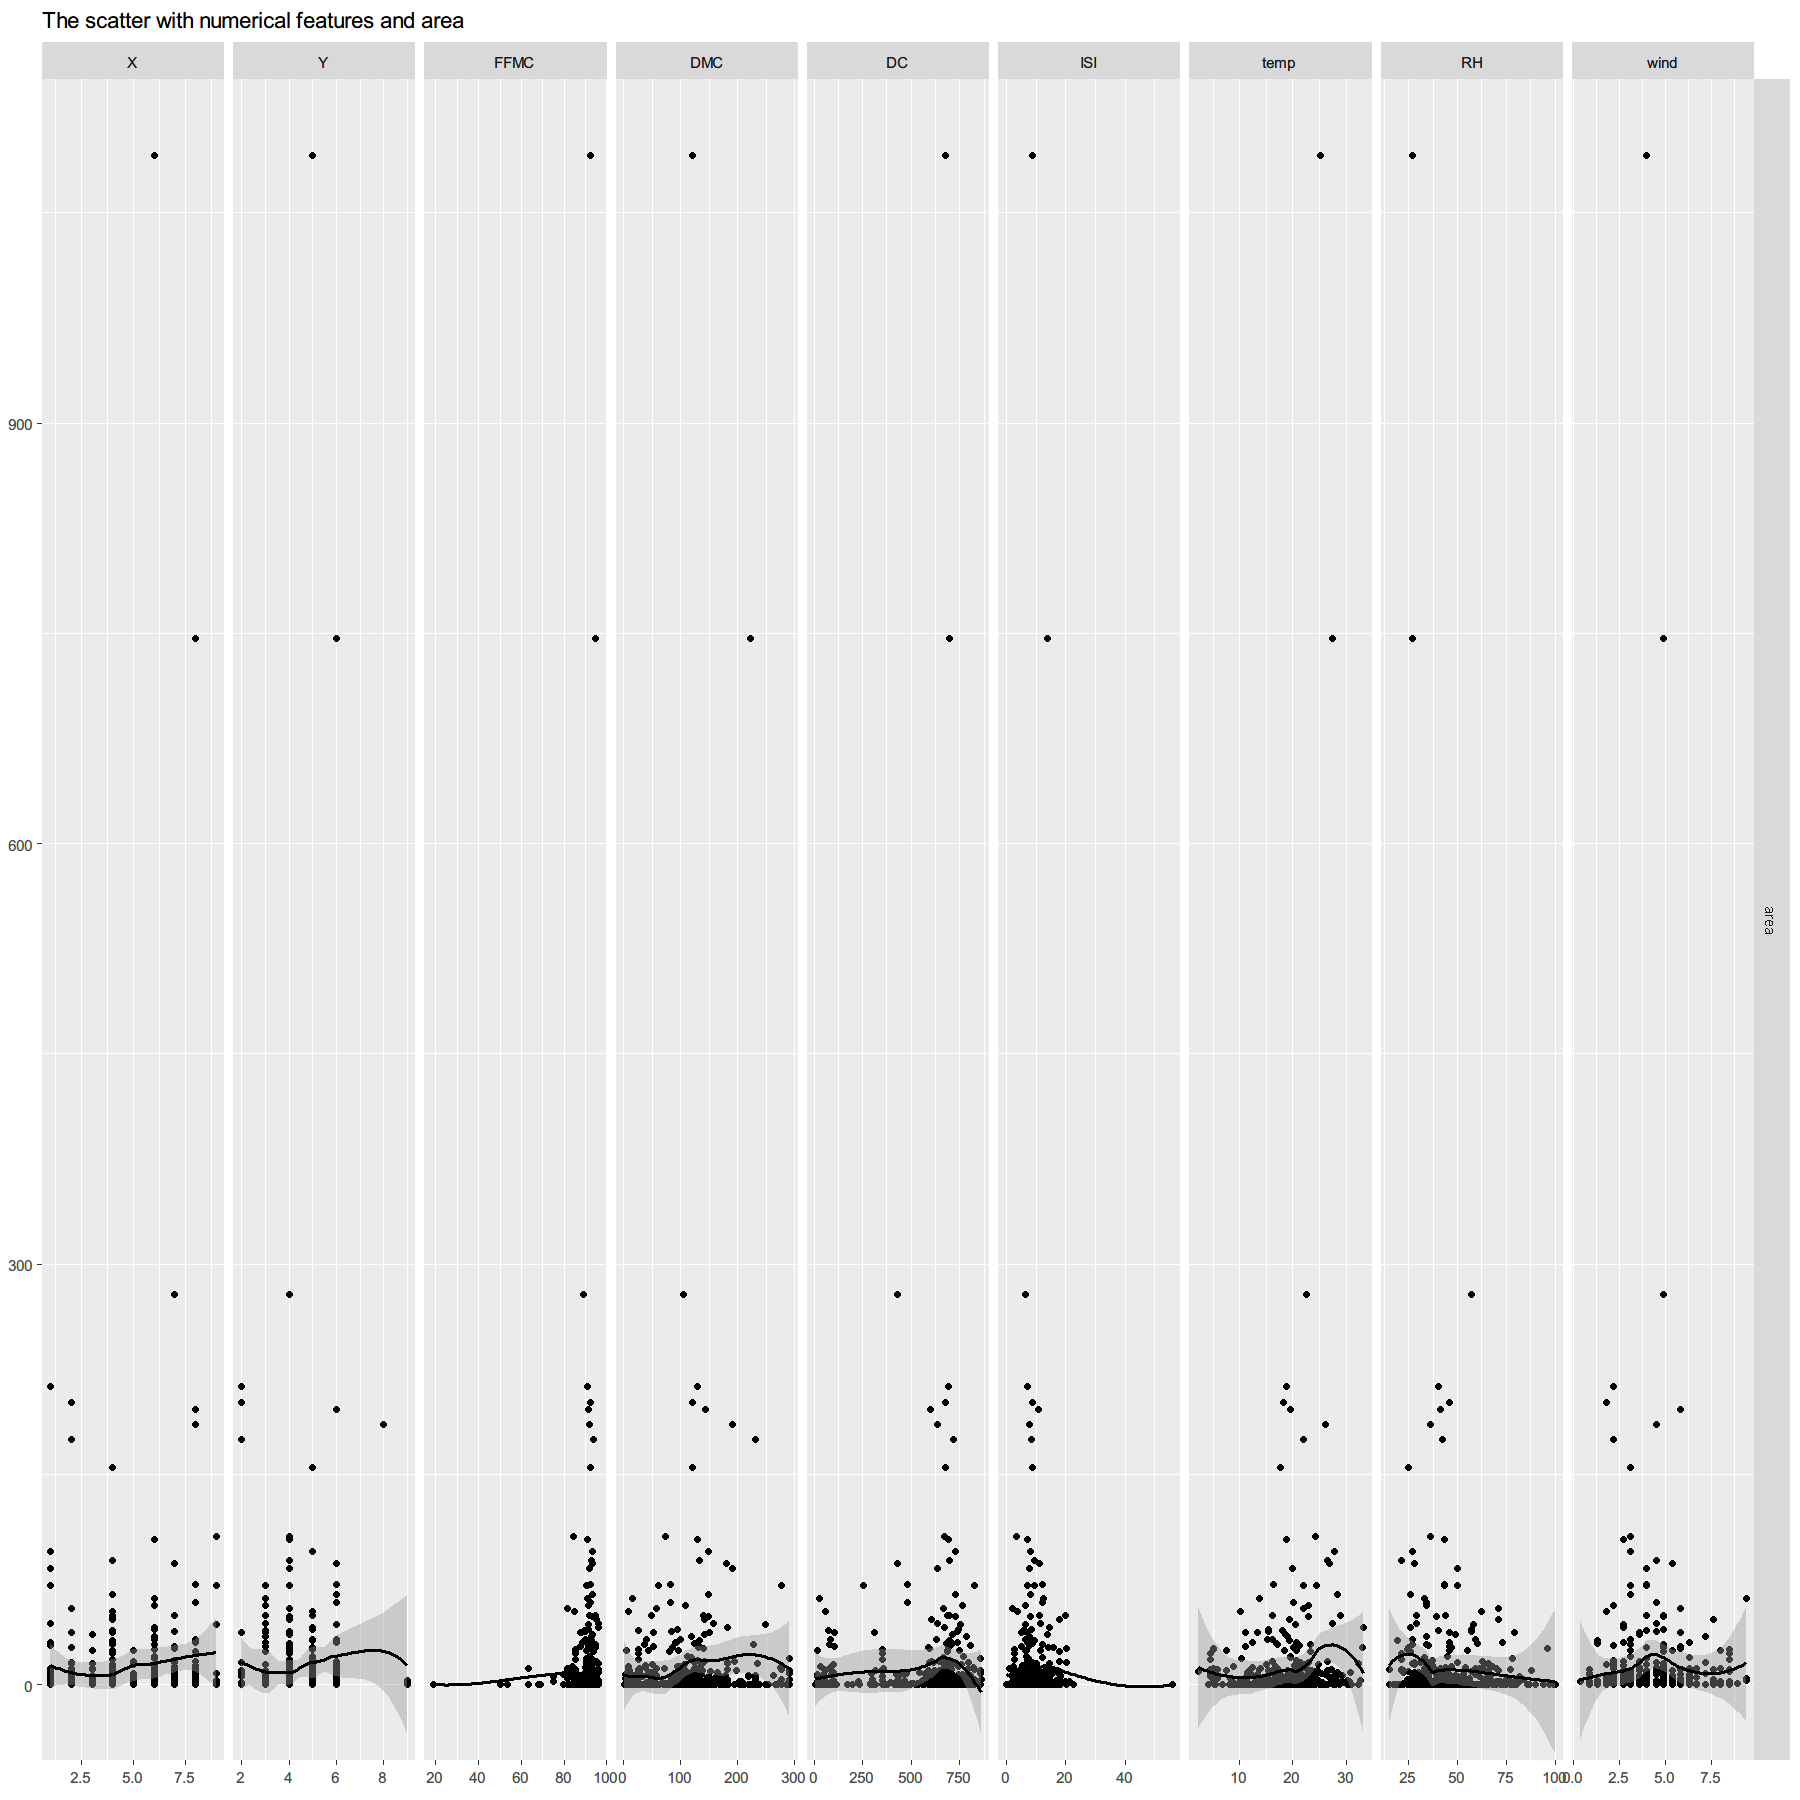

In [55]:
fire_data %>%
  select(X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, area) %>%
  ggduo(c("X", "Y", "FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind"), "area",
        title = "The scatter with numerical features and area", mapping = NULL)

The output of scatter is hard to observe. It is necessary to apply log scale on `area`.
Plot the scatter with the logged `area` value.

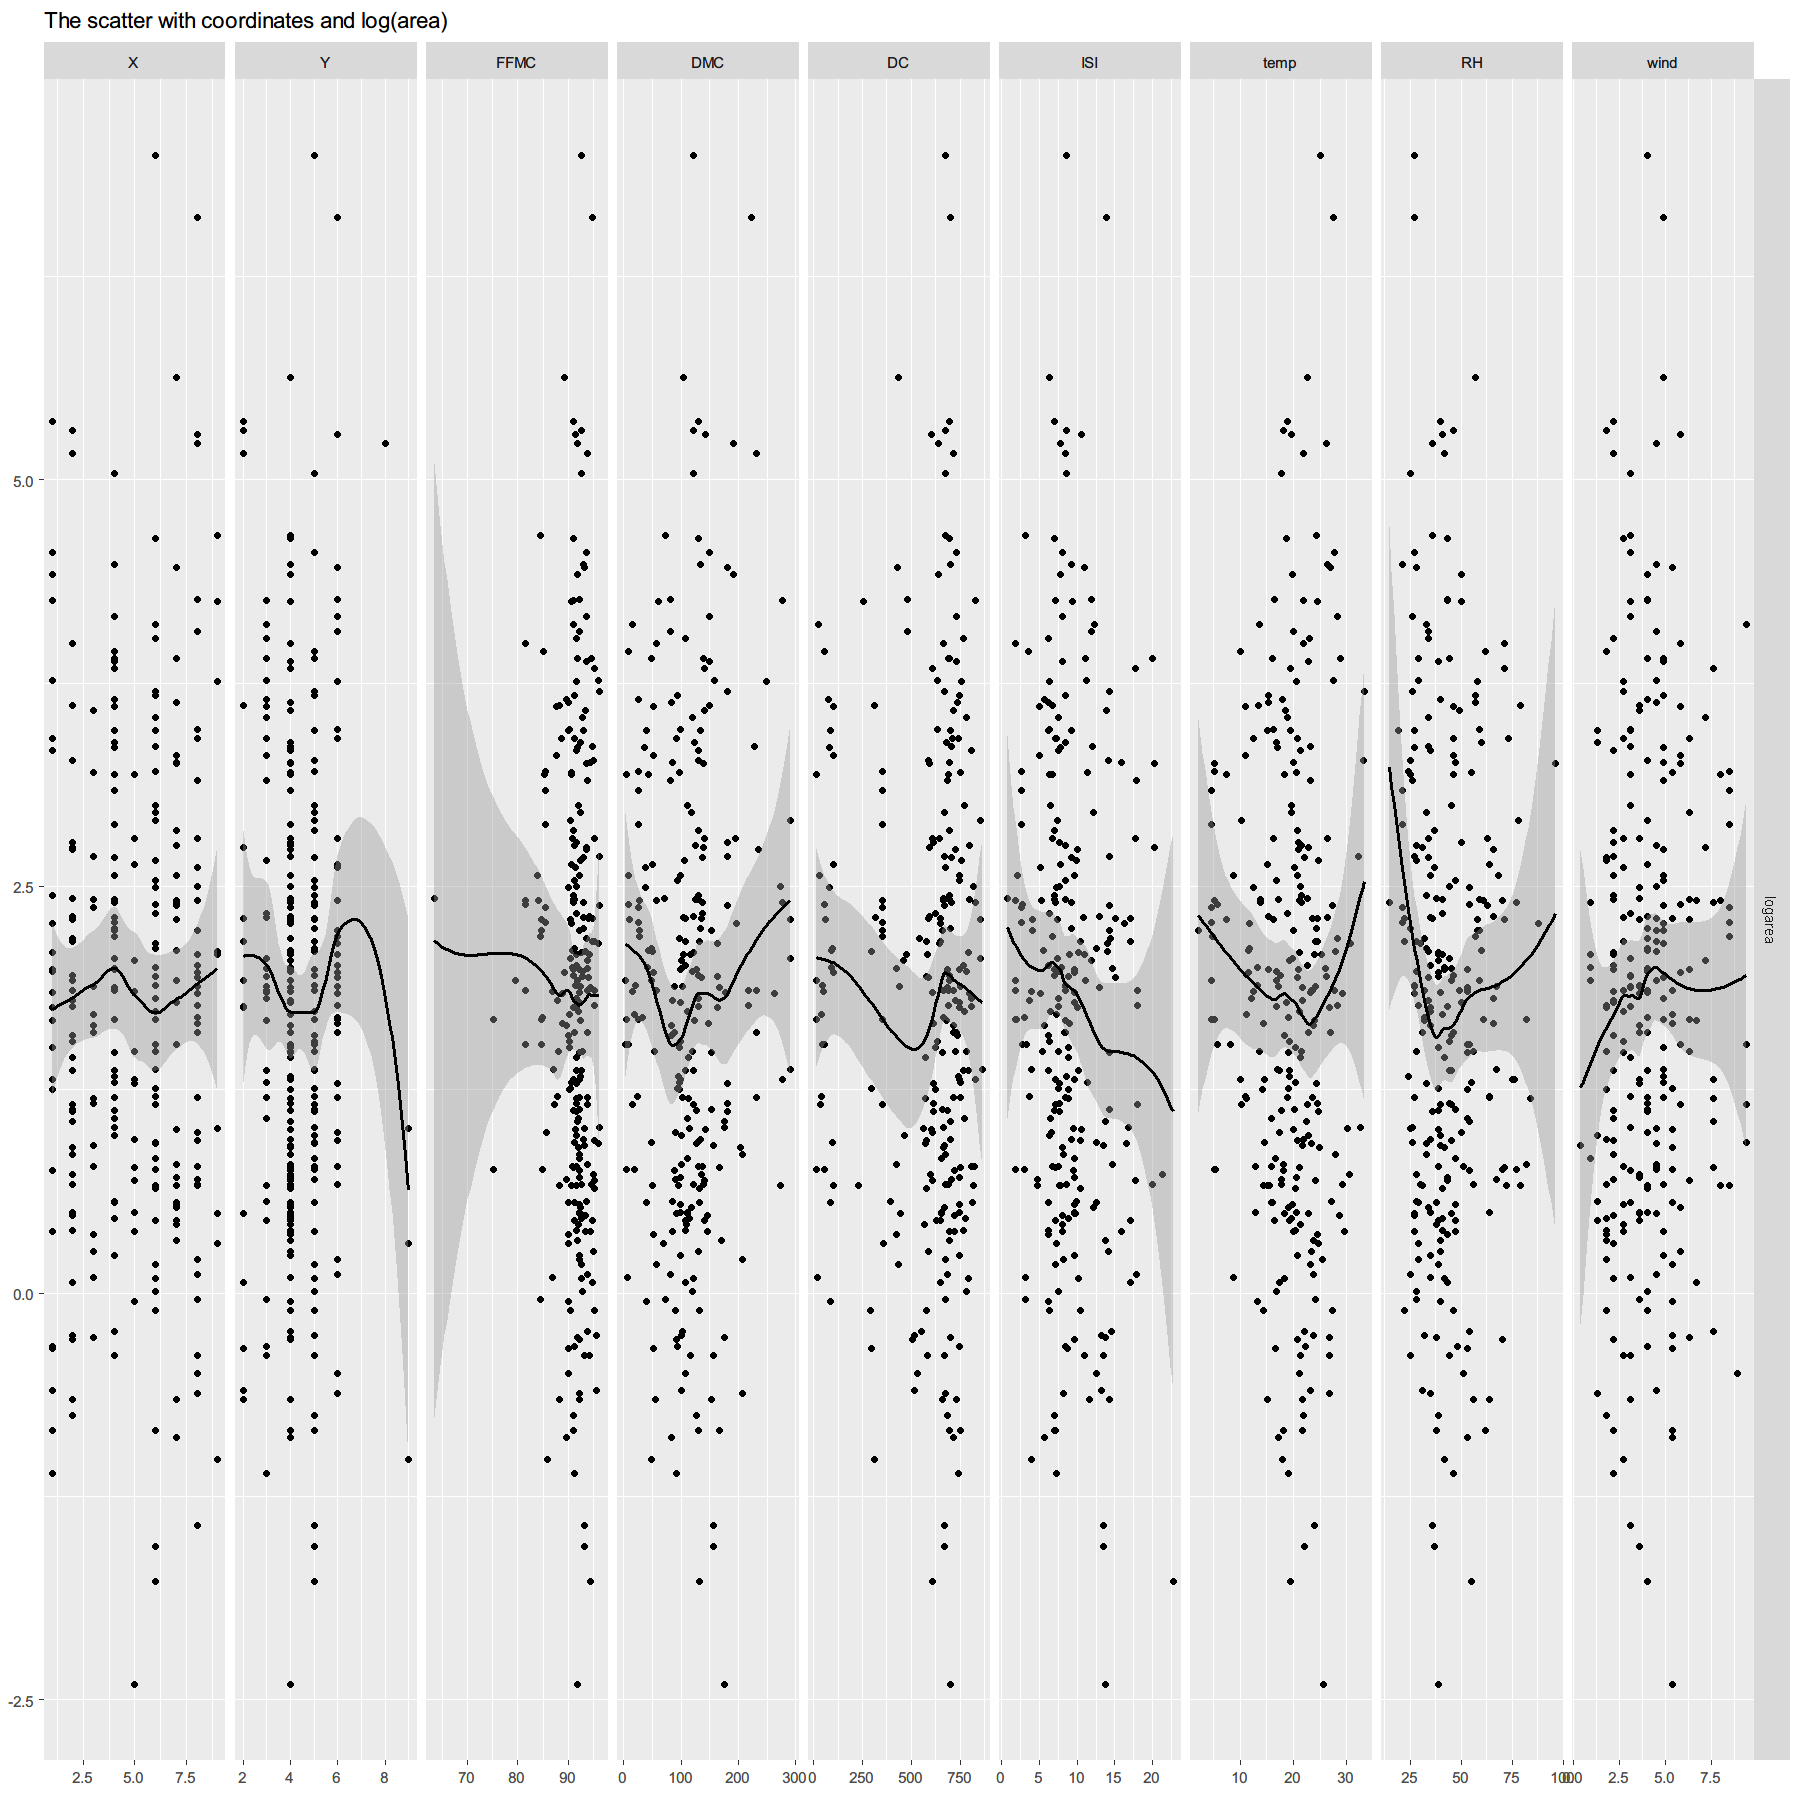

In [57]:
fire_data %>%
  mutate(logarea = log(area)) %>%
  select(X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, logarea) %>%
  filter(logarea != -Inf) %>%
  ggduo(c("X", "Y", "FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind"), "logarea",
        title = "The scatter with coordinates and log(area)", mapping = NULL)

From this plot, the distribution of `area` is easier to be modelled. Although the correlation still does not show
the linearity between logged `area` and the numerical features, it is still beneficial for modelling.
Therefore, in the model development stage, the logged `area` is applied for modelling.

As for the categorical features which are `month` and `day`, it is necessary to explore the data.
The `month` and `day` can convert to numerical format, because they represent the date.
For example, the January can be considered as first month, so it can convert to a numeric, 1.
The Wednesday can be considered as the third day in the week, so it can be considered as 3 as well.
So, it is necessary to explore the data in each `month` and each `day` to see the correlation between them and `area`.

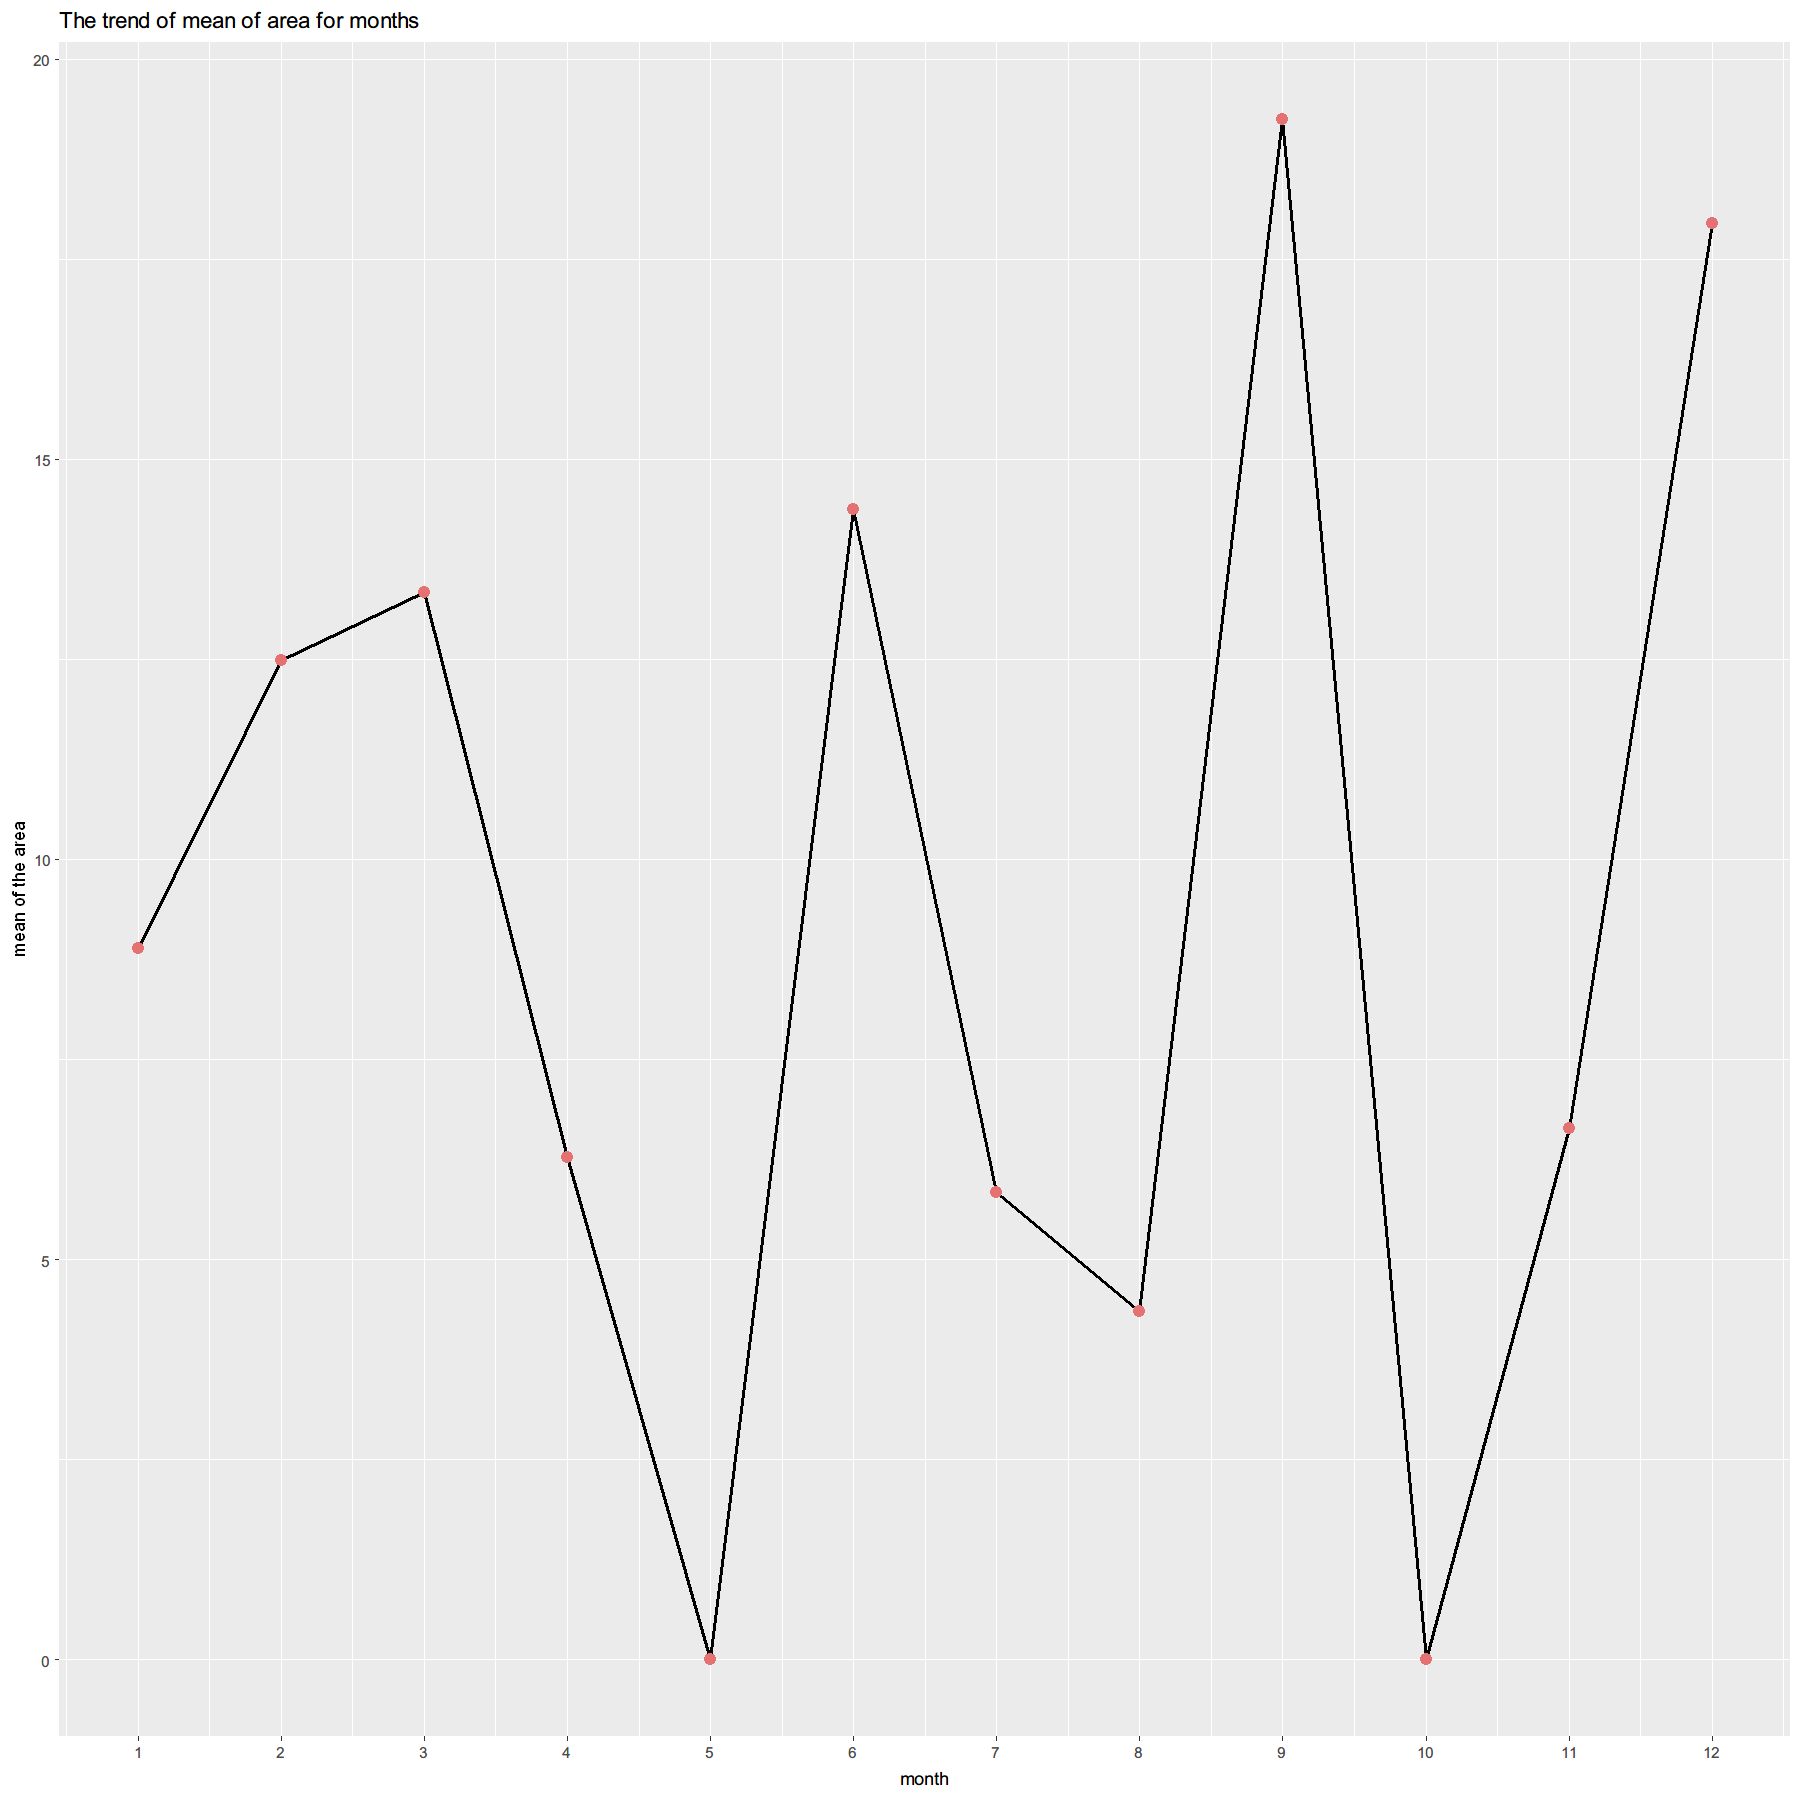

In [59]:
# transform the month as int
month_int <- sapply(fire_data$month, function(x) list("jan" = 1, "feb" = 2, "mar" = 3,
  "apr" = 4, "may" = 5, "jun" = 6, "jul" = 7, "aug" = 8, "sep" = 9, "oct" = 10,
  "nov" = 11, "dec" = 12)[[x]])
# plot
fire_data %>% select(month, area) %>% mutate(month_int = month_int) %>%
  group_by(month_int) %>%
  summarise(mean_area = mean(area)) %>% ggplot +
  geom_line(aes(x = month_int, y = mean_area), size = 1) +
  geom_point(aes(x = month_int, y = mean_area), size = 3, color = red) +
  xlab("month") + ylab("mean of the area") +
  scale_x_continuous(breaks = 1:12) +
  ggtitle("The trend of mean of area for months")

From the output of the plot, there is no relation between the order of the `month` with the `area` value. Therefore,
the `month` should be considered as categorical feature, and need to be one hot encoded.

Then, the feature `day` should be examined as well.

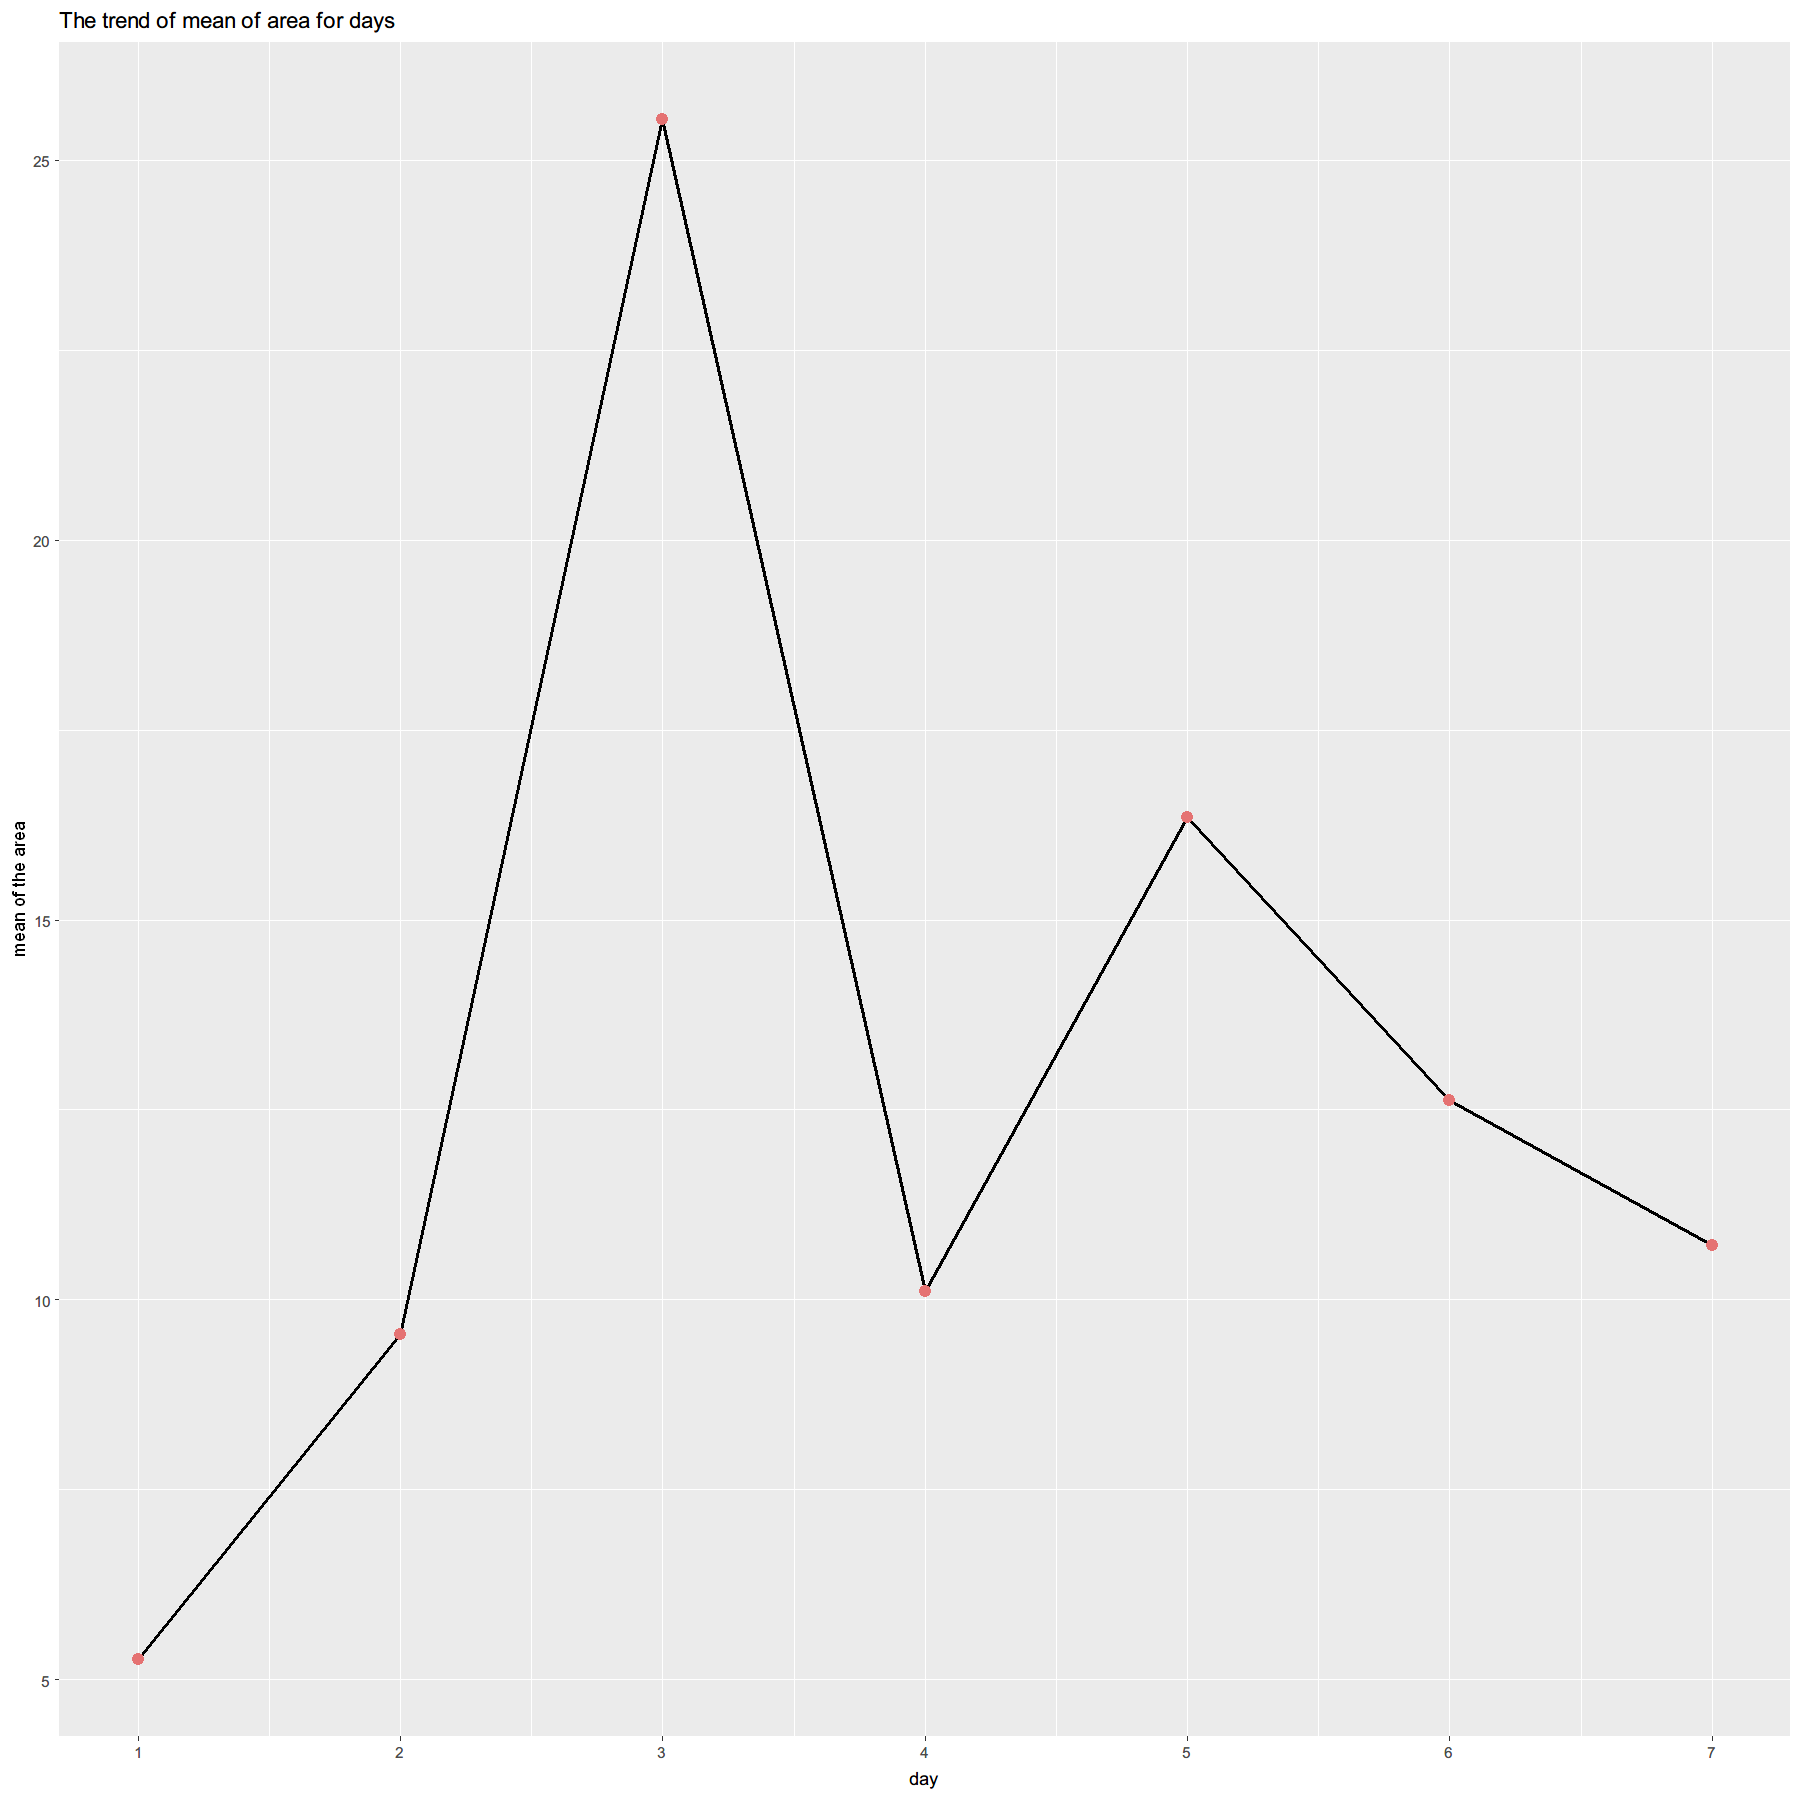

In [61]:
# transform the day of week as int
day_int <- sapply(fire_data$day, function(x) list("mon" = 1, "tue" = 2, "wed" = 3,
  "thu" = 4, "fri" = 5, "sat" = 6, "sun" = 7)[[x]])
# plot
fire_data %>% select(day, area) %>% mutate(day_int = day_int) %>% group_by(day_int) %>%
  summarise(mean_area = mean(area)) %>% ggplot +
  geom_line(aes(x = day_int, y = mean_area), size = 1) +
  geom_point(aes(x = day_int, y = mean_area), size = 3, color = red) +
  xlab("day") + ylab("mean of the area") +
  scale_x_continuous(breaks = 1:7) +
  ggtitle("The trend of mean of area for days")

From the output, there is no significant relationship between the order of the day with area. So, the `day` should be considered as categorical features.

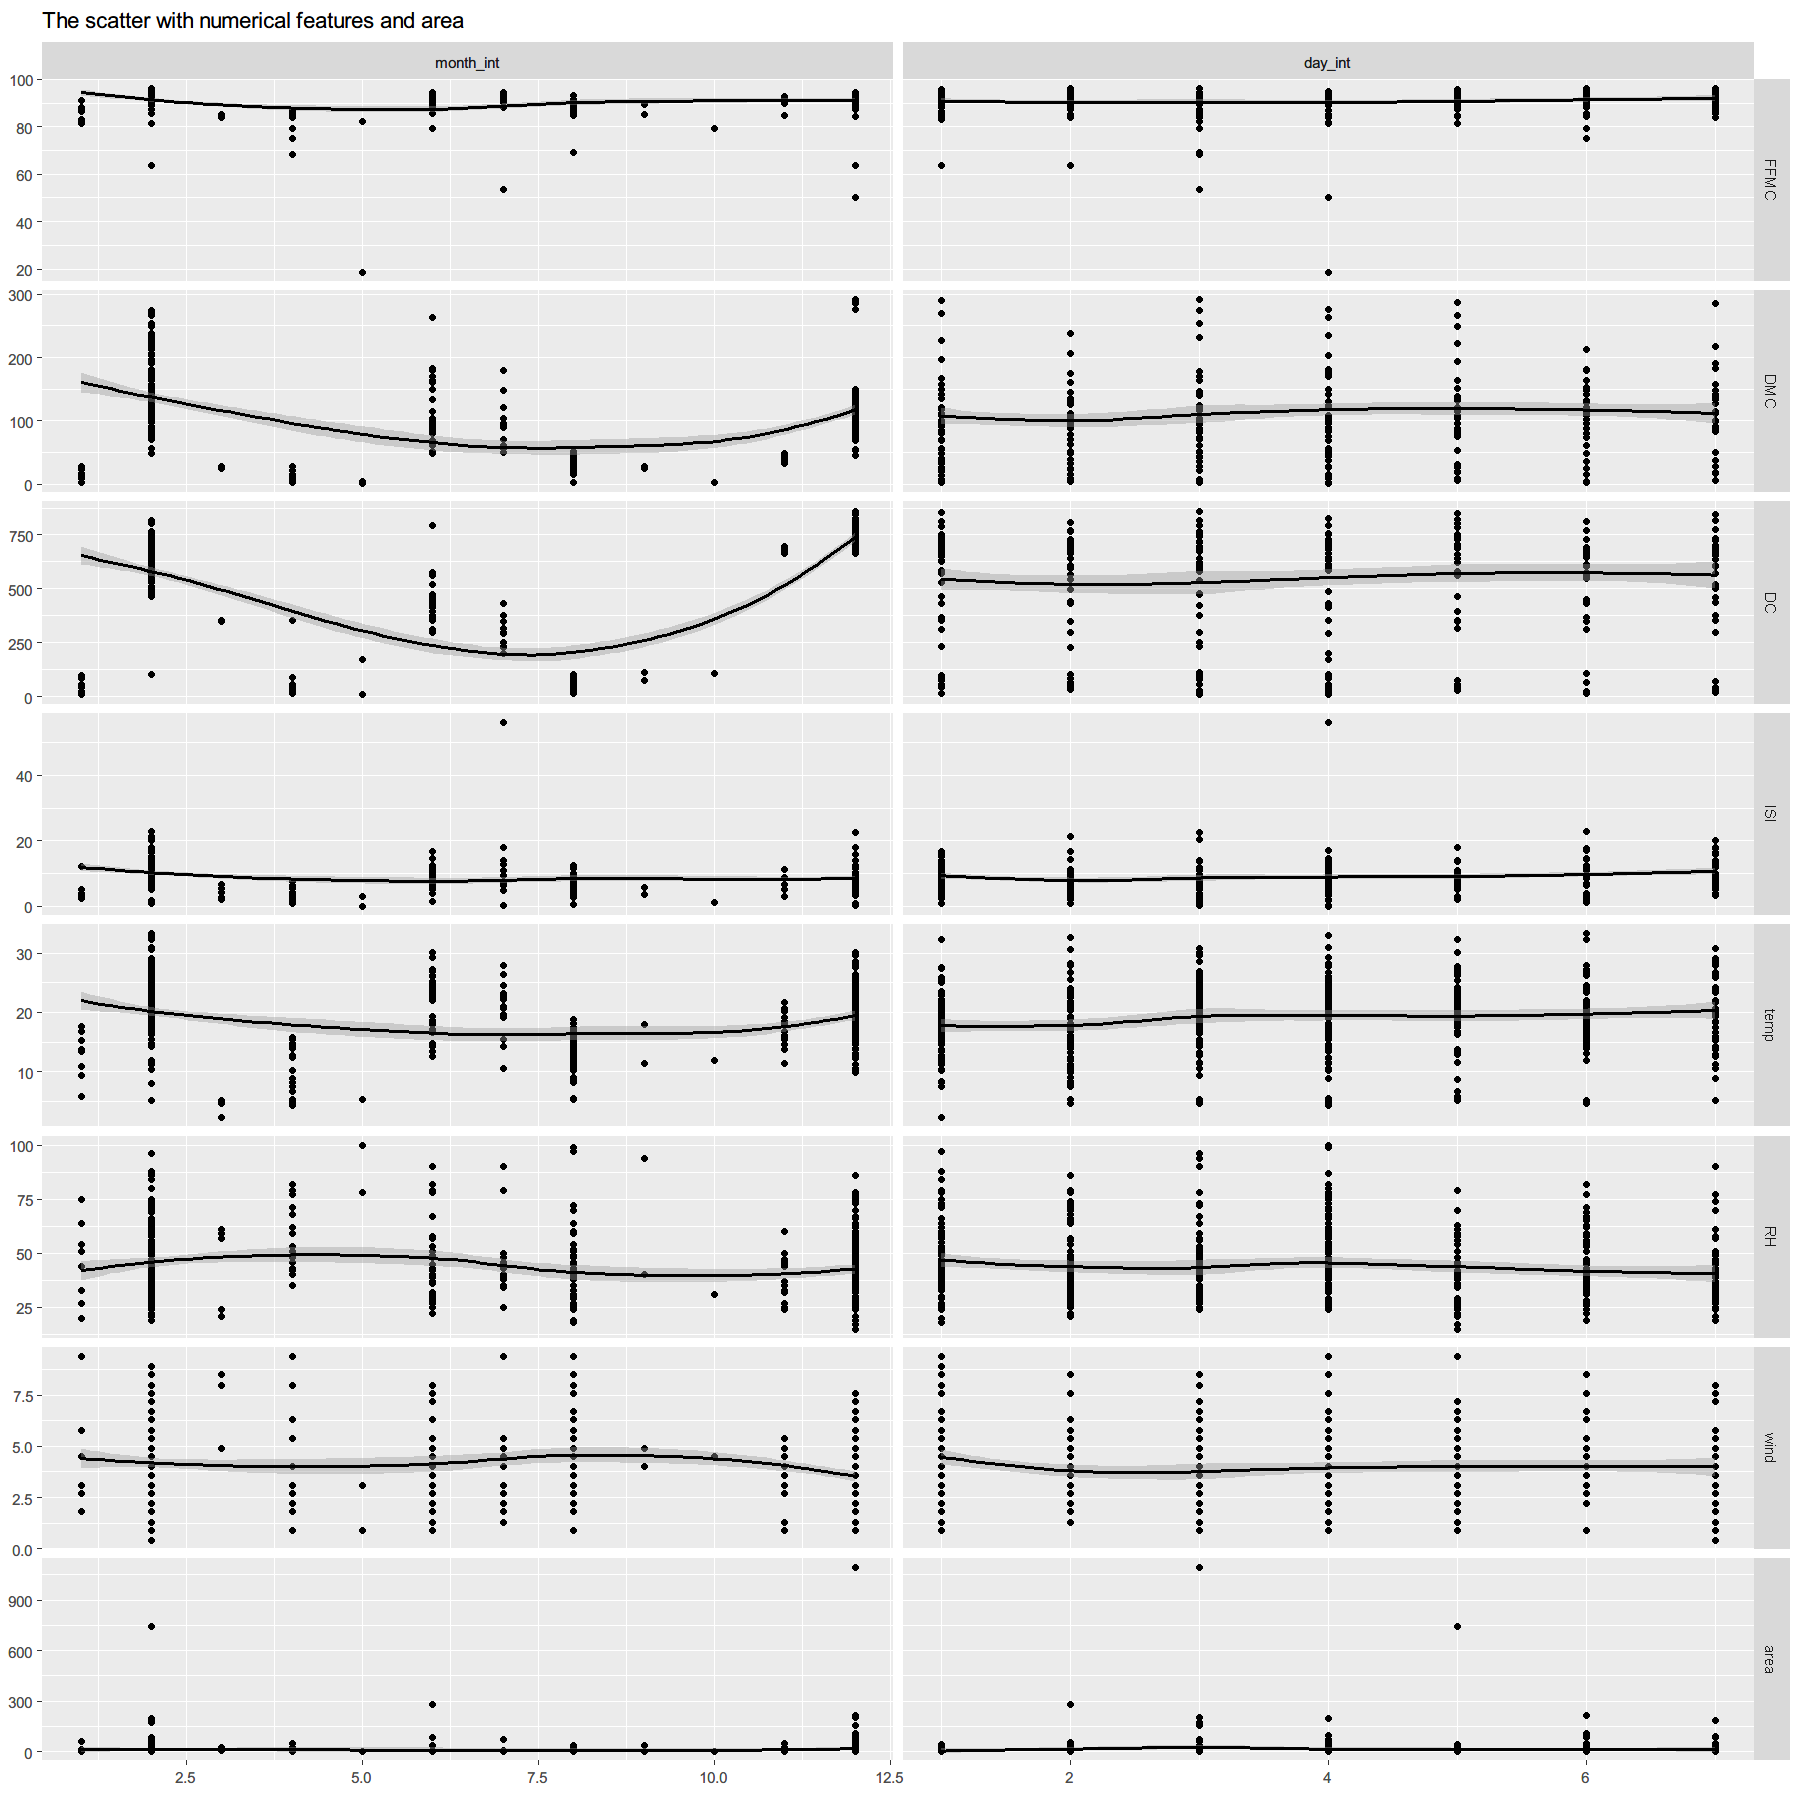

In [63]:
fire_data %>% mutate(day_int = day_int) %>% mutate(month_int = month_int) %>%
  select(month_int, day_int, FFMC, DMC, DC, ISI, temp, RH, wind, area) %>%
  ggduo(columnsX = c("month_int", "day_int"),
        columnsY = c("FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "area"),
        title = "The scatter with numerical features and area", mapping = NULL)

From the visualization, the `month` has some non-linear relation with other features such as `DC` and `temp`. As for `day`, it seems no significant relationship to others.

The next step is to visualize the location of data, which is represented by the `X` and `Y`. The visualization is applied by the `ggplot2::geom_tile` and other
`ggplot2` functions which can visualize the discrete data.

`summarise()` has grouped output by 'X'. You can override using the `.groups` argument.



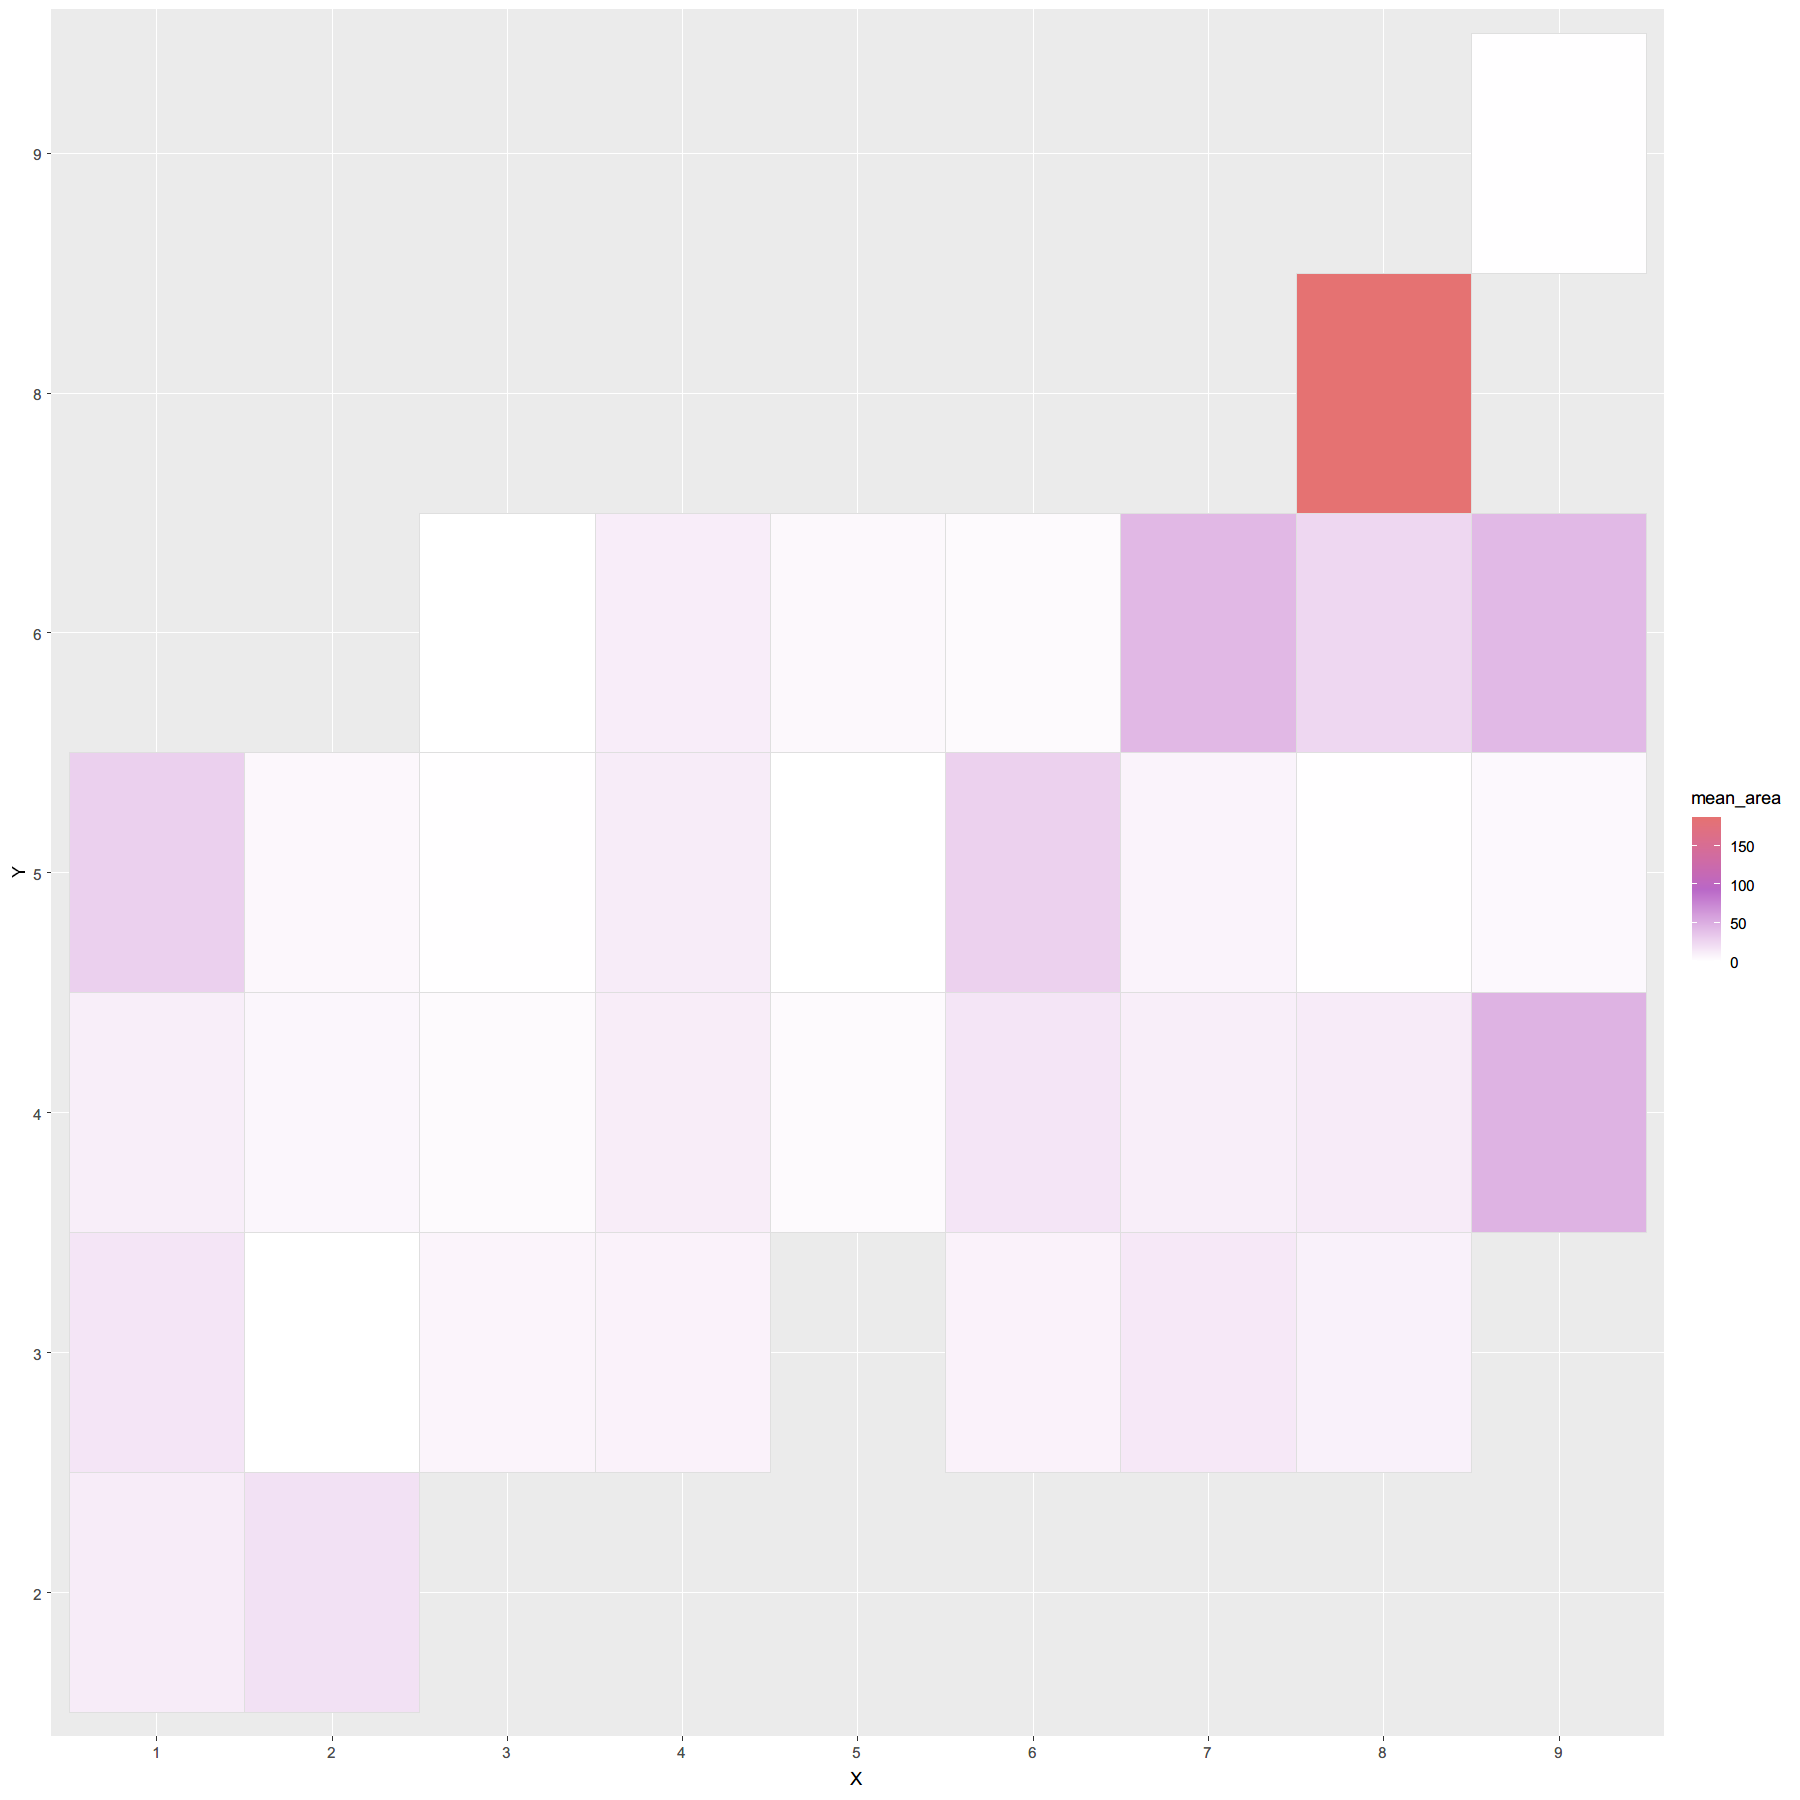

In [65]:
fire_data %>% select(X, Y, area) %>% mutate(X = as.factor(X), Y = as.factor(Y)) %>%
  group_by(X, Y) %>% summarise(mean_area = mean(area)) %>% ggplot +
  geom_tile(aes(X, Y, fill = mean_area), color = gray) +
  scale_fill_gradientn(colors = c(white, purple, red))

From the output, it is clearly that, the tile is not independent with the nearby location.
The location in the center is significant lower than the area when `X` is large. This plot indicates the fire area is related to
the location.

## 3. Model Development<a class="anchor" id="sec_3"></a>


### Preprocessing
Before modelling, the featurization is very important. In the preprocessing stage, some outliers found in the
EDA stage will be removed. Also, because many area values are 0, they can be mutated as binary boolean
target label for better modelling.

Also, the features can be manipulated further. An important method is to generate the interaction features.
The function `generate_comb_features` is defined to generate the multiplied features from existed numerical
features. Another method for featurization is to generate polynomial features. For example, for feature
`temp`, it is possible to generate `temp^2` with the value powered by 2, and `temp^3` with the value powered
by 3. If the value is scaled, there will be some negative values, the squared feature will lose the negative
sign; therefore, only the cubed features are applied.

In [68]:
# generate combination features
generate_comb_features <- function(data) {
  data_comb <- data %>% as.data.frame
  for (i in 1:(length(numerical_vars) - 1)) {
    for (j in (i+1):length(numerical_vars)) {
      numerical_var1 <- numerical_vars[i]
      numerical_var2 <- numerical_vars[j]
      new_name <- paste(numerical_var1, numerical_var2, sep = ":")
      data_comb[,new_name] <- data_comb[,numerical_var1] * data_comb[,numerical_var2]
    }
  }
  data.frame(data_comb)
}

# generate polynomial features
generate_polynomial_features <- function(data, power) {
  data_poly <- data %>% as.data.frame
  for (numerical_var in numerical_vars) {
    new_name <- paste0(numerical_var, ".", power)
    data_poly[,new_name] <- data_poly[,numerical_var] ^ power
  }
  data.frame(data_poly)
}

### Split data for training and testing

According to the specification pdf, the data should be divided as train data (80%) and test data (20%).

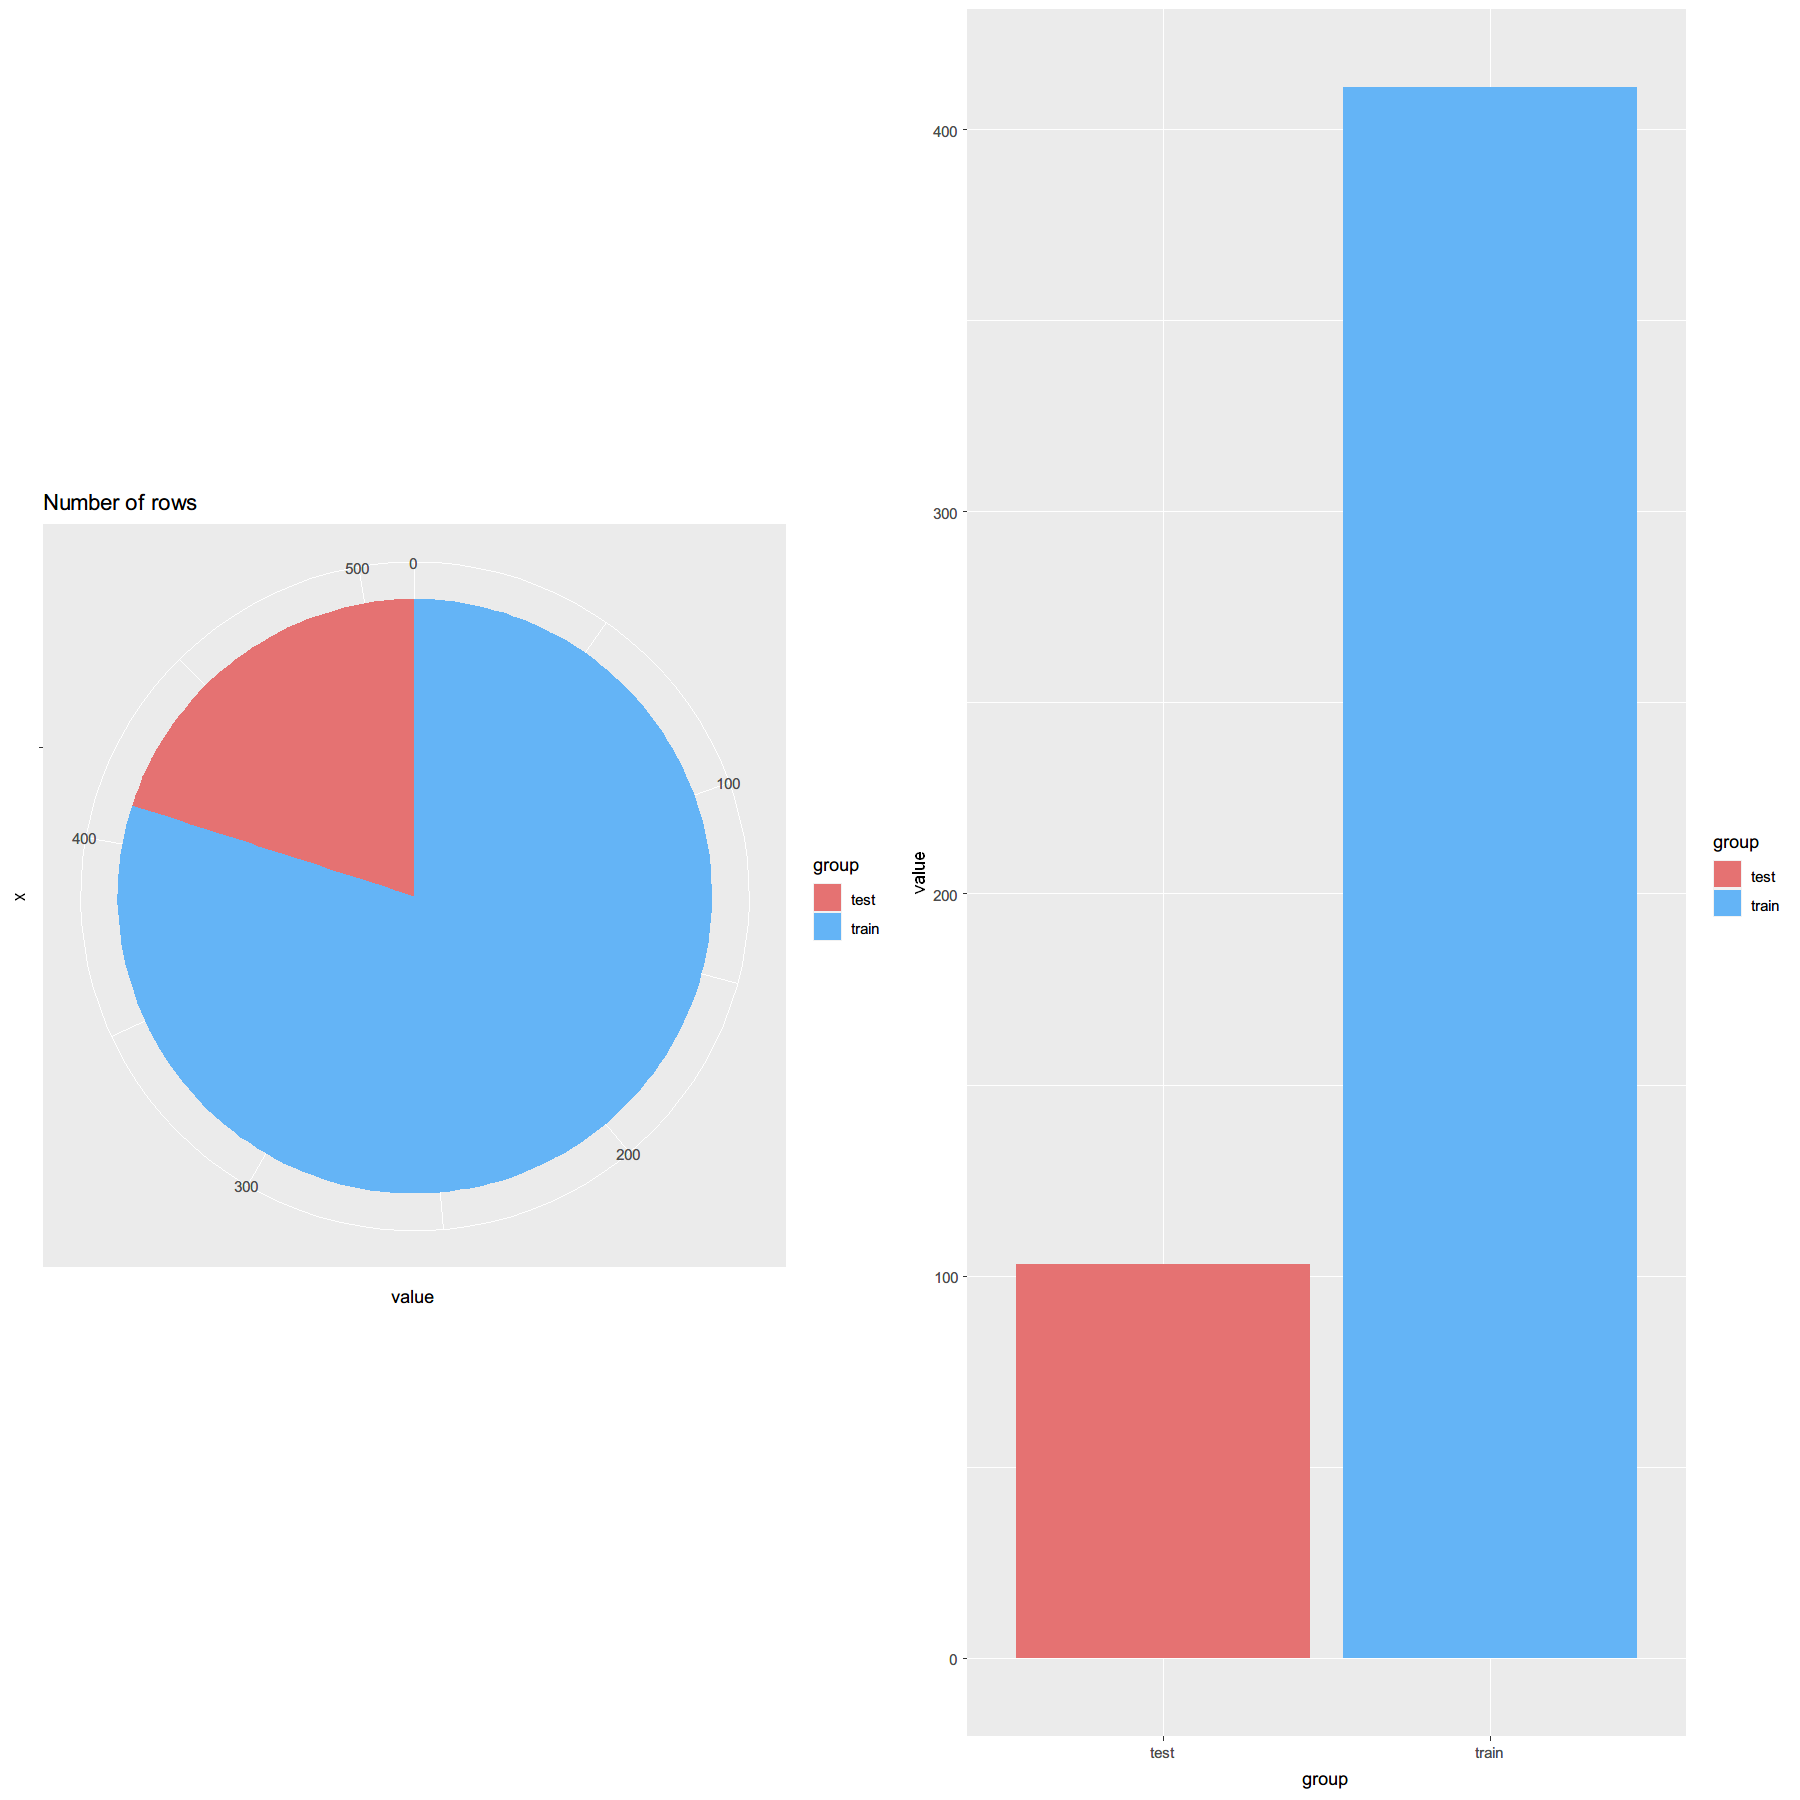

In [69]:
set.seed(42)
train_mask <- sample(1:nrow(fire_data_processed),
                     size = 0.8 * nrow(fire_data_processed), replace = FALSE)
train_data <- fire_data_processed[train_mask,]
test_data <- fire_data_processed[-train_mask,]
# apply the features generation
train_data_comb <- train_data %>% generate_comb_features %>% generate_polynomial_features(power = 3)
test_data_comb <- test_data %>% generate_comb_features %>% generate_polynomial_features(power = 3)
# plot chart for the amounts of train data and test data
data_sizes <- data.frame(group=c("train", "test"), value=c(nrow(train_data), nrow(test_data)))
g1 <- data_sizes %>% ggplot(aes(x="", y=value, fill=group)) + geom_bar(stat = "identity") +
  coord_polar("y") + ggtitle("Number of rows") + scale_fill_manual(values = c(red, blue))
g2 <- data_sizes %>% ggplot(aes(x=group, y=value, fill=group)) + geom_bar(stat = "identity") +
  scale_fill_manual(values = c(red, blue))
grid.arrange(g1, g2, nrow = 1)

From the pie chart and bar chart, the data has been divided correctly. As the data has been add a boolean column
`fire`, which is TRUE if `area` > 0, the distribution of `fire` need to be visualized as well.

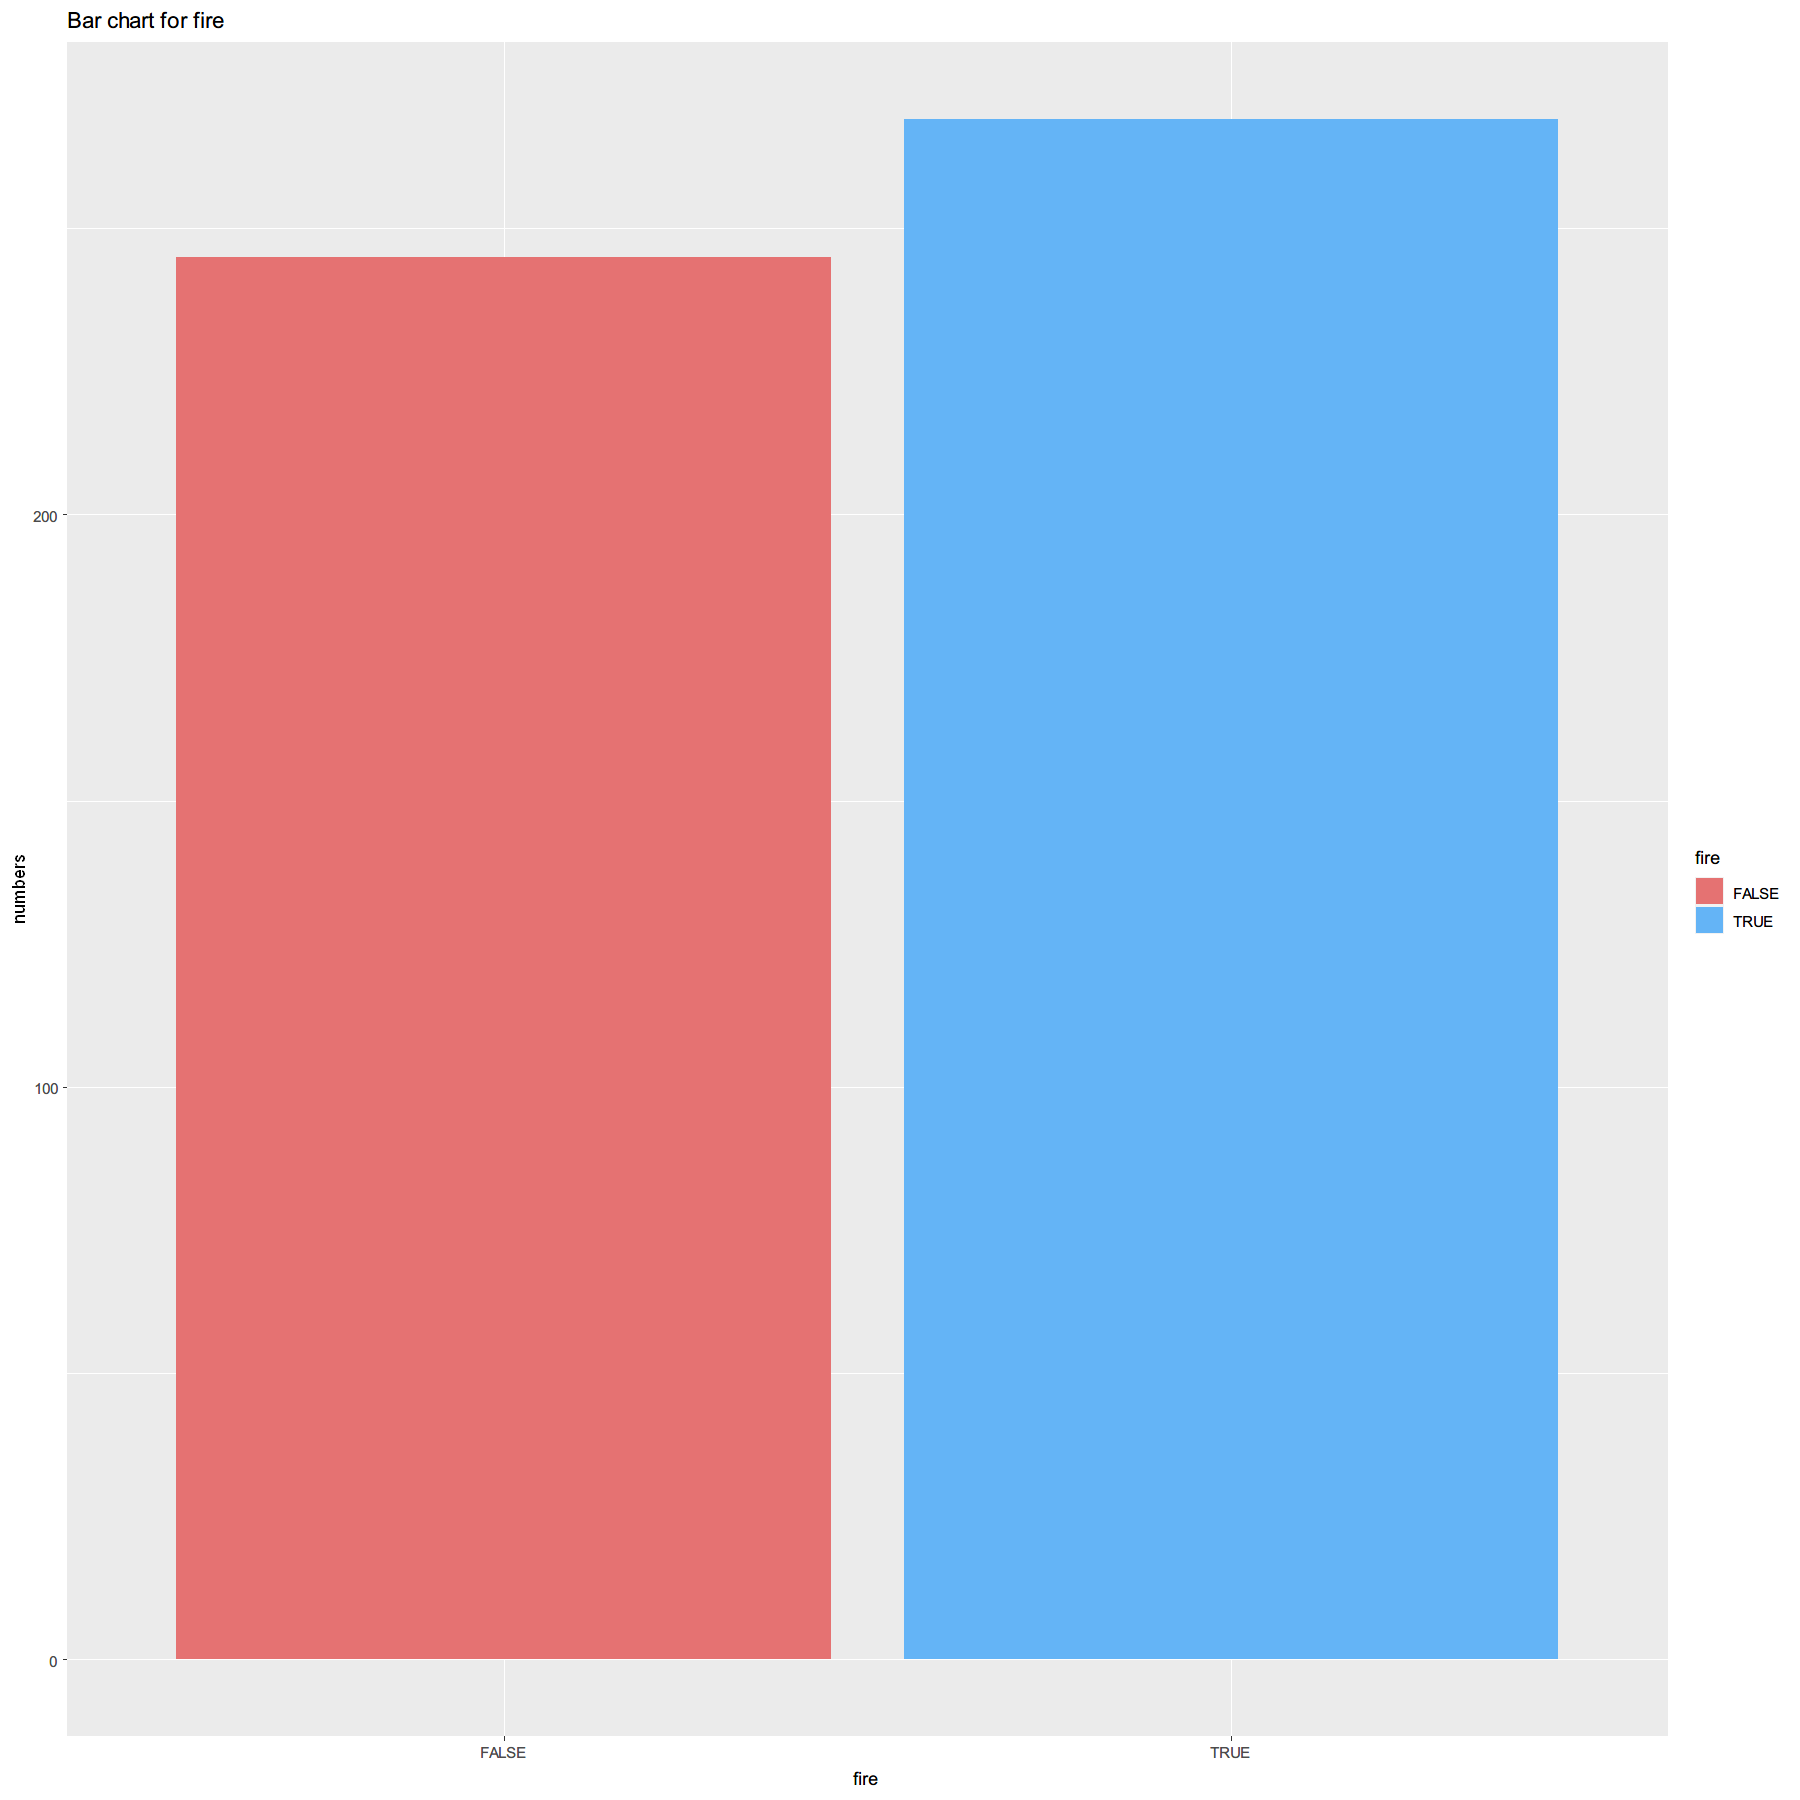

In [70]:
fire_count <- fire_data_processed %>% count(fire)
fire_count %>% ggplot(aes(x = fire, y = n, fill = fire)) + geom_bar(stat = "identity") +
  scale_fill_manual(values = c(red, blue)) +
  ggtitle("Bar chart for fire") +
  labs(y = "numbers")

From the plot, the amounts of the data indicating firing and not firing can be considered as balanced. Therefore,
whether it is fired can be considered as a variable for model prediction.

Therefore, a compound model can be built by a regressor and classifier. The predicted area value is 0, if the
classifier predict the `fire` is FALSE. For other data classified as `fire` == TRUE, the regressor can predict
the accurate value of `area`. For more details, please refer to the Compound Models section.

### Define metric functions
#### Regressor metrics

Implement the metrics functions by the package `MLmetrics` (Yan, 2020).

In [71]:
r2 <- function(y_test, y_pred)
        MLmetrics::R2_Score(y_true = y_test, y_pred = y_pred)
mse <- function(y_test, y_pred)
        MLmetrics::MSE(y_true = y_test %>% unlist, y_pred = y_pred)
rmse <- function(y_test, y_pred)
        MLmetrics::RMSE(y_true = y_test %>% unlist, y_pred = y_pred)
mae <- function(y_test, y_pred)
        MLmetrics::MAE(y_true = y_test %>% unlist, y_pred = y_pred)

#### Classifier metrics

In [72]:
accuracy <- function(y_test, y_pred)
        MLmetrics::Accuracy(y_true = y_test, y_pred = y_pred)
f1 <- function(y_test, y_pred)
        MLmetrics::F1_Score(y_true = y_test %>% unlist, y_pred = y_pred %>% unlist)
# confusion matrix is not return a scalar, only for show
confusion_matrix <- function(y_test, y_pred)
        table(y_test %>% unlist, y_pred)

### Model abstract class

For better code reusable and logic, the RC class is widely used in this assignment. The `AbstractModel` class,
`AbstractRegression` class and `AbstractClassifier` class are the wrappers for the model used in the assignment.
Each model has common methods, which are,

* `fit`: the method let the Model fit the train data
* `predict`: the method for prediction with given test data
* `get_default_formula`: the method to get default formula, which is the target column, which is `fire` or `area`, against others except another target column.
* `evaluate`: the method for calculating the score with given true label, predicted label, and the metric function defined above.
* `pred_evaluate`: the combination of `predict` and `evaluate`, calculating the score by given test data (containing features and targets) automatically.

Besides, from EDA, y needed to be logged for better modelling. However, there are many `area` value equals to 0, and
$log(0)$ is not feasible for modelling. A log bias should be introduced. Therefore, the new label can be calculated
as,
$$
t = log(y + bias)
$$

After prediction, the predicted label can be calculated as,
$$
\hat{y} = e^{\hat{t}} - bias
$$

The algorithm of reverse log has been implemented in `AbstractRegression$logy_revert`.

In [73]:
AbstractModel <- setRefClass("AbstractModel",
  fields = list(train = "data.frame", need_comb_data = "logical",
                use_regularizer = "logical"),
  methods = list(
    initialize = function() {},
    fit = function(train, ...) {},
    predict = function(test, ...) {},
    get_default_formula = function(formula) {},
    # the argument evaluate_func can be r2, mse, accuracy, f1,
    # which will be defined in Model Comparison section
    evaluate = function(y_test, y_pred, evaluate_func) evaluate_func(y_test, y_pred),
    pred_evaluate = function(test, evaluate_func) {}
))

AbstractRegression <- setRefClass("AbstractRegression", contains = "AbstractModel",
  fields = list(is_logy = "logical", log_bias = "numeric"),
  methods = list(
    initialize = function(is_logy = FALSE, log_bias = 0, ...) {
      .self$is_logy <- is_logy
      .self$log_bias <- log_bias
    },
    logy_revert = function(pred) {
      if (.self$is_logy) pred %>% exp %>% (function(x) x - .self$log_bias)
      else pred
    },
    get_default_formula = function(formula) {
      if (is.null(formula)) {
        if (.self$is_logy) log(area + .self$log_bias) ~ . - fire
        else area ~ . - fire
      }
    },
    pred_evaluate = function(test, evaluate_func) {
      y_test <- test[,"area"]
      y_pred <- .self$predict(test)
      evaluate_func(y_test %>% unlist, y_pred)
    }
))

AbstractClassifier <- setRefClass("AbstractClassifier",
  contains = "AbstractModel", methods = list(
    get_default_formula = function(formula) {
      if (is.null(formula)) fire ~ . - area
      else formula
    },
    pred_evaluate = function(test, evaluate_func) {
      y_test <- test[,"fire"]
      y_pred <- .self$predict(test)
      evaluate_func(y_test %>% unlist, y_pred)
    }
))

The bias of log can also be considered as a hyperparameter for modelling. To improve the performance of the models,
hyperparameter grid search is implemented below for choosing optimized hyperparameter.

In [74]:
grid_search_1d <- function(xs, best_func, pred_evaluate_func) {
  # calculate the result by given pred_evaluate function
  results <- sapply(xs, pred_evaluate_func)
  # get the best function, max for r2, min for mse
  best_result <- best_func(results)
  best_x <- xs[which(results == best_result)[1]]
  print(paste0("Best hyperparameter value is ", best_x))
  print(paste0("Best value is ", best_result))
  # return the geom_path object for visualization
  list(results =  data.frame(x = xs, result = results),
       x = best_x,
       best_result = best_result
  )
}

grid_search_2d <- function(xs, ys, best_func, pred_evaluate_func) {
  # initialize a matrix for storing results
  results <- matrix(nrow = length(xs) * length(ys), ncol = 3) %>%
          `colnames<-`(c("x", "y", "value"))
  # loop all posible hyperparameter to calculate each result
  index <- 1
  for (i in 1:length(xs)) {
    for (j in 1:length(ys)) {
      results[index, ] <- c(xs[i], ys[j], pred_evaluate_func(xs[i], ys[j]))
      index <- index + 1
    }
  }
  results <- as.data.frame(results)
  # locate best hyperparameter
  best_result <- best_func(results$value)
  max_index <- which(results$value == best_result)[1]
  print(paste0("Best x: ", results$x[max_index]))
  print(paste0("Best y: ", results$y[max_index]))
  max_x_index <- which(xs == results$x[max_index])
  max_y_index <- which(ys == results$y[max_index])
  # return the geom_tile and annotation objects for visualization
  list(tile = geom_tile(data = results,
                        mapping = aes(x = as.factor(x), y = as.factor(y), fill = value)),
    annotation = annotate("text", x = max_x_index, y = max_y_index, size = 3,
                          label = paste0("best=", round(best_result, 1))),
    x = results$x[max_index],
    y = results$y[max_index],
    best_result = best_result)
}

# a function for evaluate the model automatically
evaluate_model <- function(model, evaluate_func) {
  if (model$need_comb_data) model$pred_evaluate(test_data_comb, evaluate_func)
  else model$pred_evaluate(test_data, evaluate_func)
}

### Build simple models

The simple models are the models which is formed by one regressor.
In this section, linear regression, knn regression and decision tree will be built.

#### Linear Regression
First of all, the linear regression is a potential good model for this data.
To solve the overfitting problem, Lasso(L1), Ridge(L2) and elastic net regularization
are useful method for linear regression. Lasso regularization has good performance on
feature selection and Ridge regularization is good for avoiding overfitting. As for
elastic net is a generic way which contains the Lasso (alpha = 1) and Ridge (alpha = 0).

Therefore, to find the best regularization method, implementing the elastic net is a
suitable way.

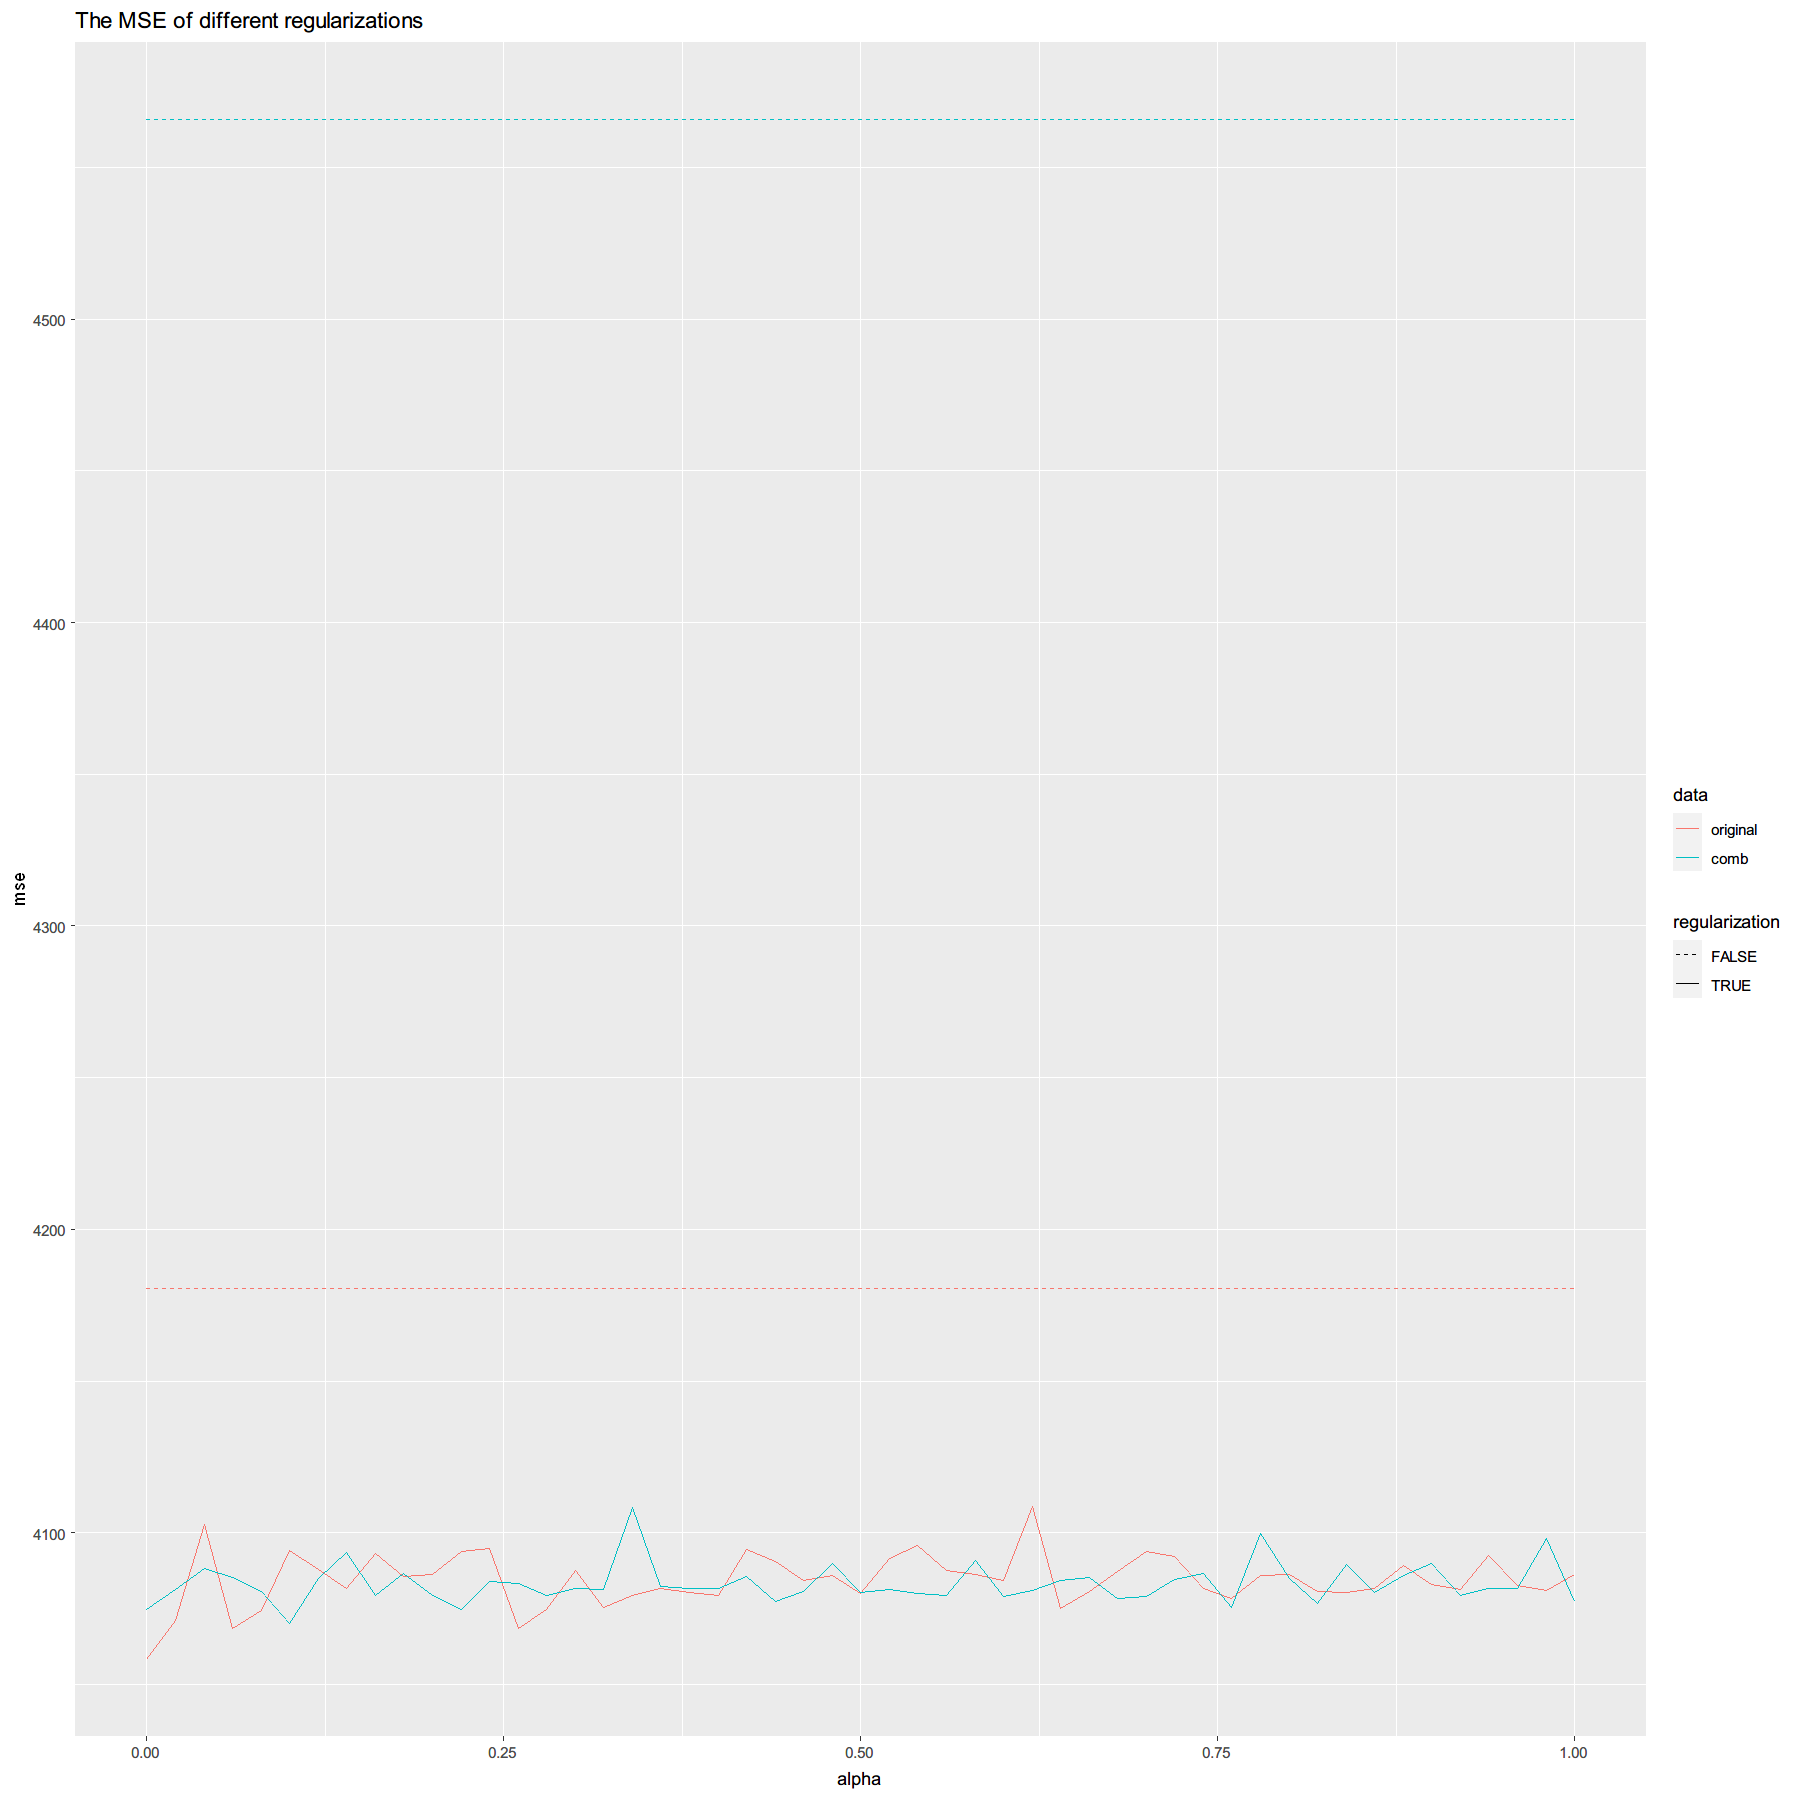

In [75]:
# search best regularizer for linear regression by cross validation
# calculate the mse without regularization as control group
cvlm <- cv.glm(rbind(train_data, test_data),
               glm(area ~ . - fire, data = rbind(train_data, test_data),
                   family = "gaussian"),
               K = 10)
original_cvlm_mse <- cvlm[["delta"]][1]
cvlm <- cv.glm(rbind(train_data_comb, test_data_comb),
               glm(area ~ . - fire, data = rbind(train_data_comb, test_data_comb),
                   family = "gaussian"),
               K = 10)
comb_cvlm_mse <- cvlm[["delta"]][1]

# set potential alpha values
alphas <- seq(0, 1, 0.02)

# the elastic net for original data (without combined and polynomial features)
original_glmnet <- alphas %>% lapply(FUN = function(alpha) {
  cv.glmnet(rbind(train_data_comb,test_data_comb) %>%
                    select(!c("area", "fire")) %>% data.matrix,
            rbind(train_data_comb,test_data_comb)[, "area"] %>% data.matrix,
            alpha = alpha, family = "gaussian", nfolds = 10)
})
# the elastic net for data with combined and polynomial features
comb_glmnet <- alphas %>% lapply(FUN = function(alpha) {
  cv.glmnet(rbind(train_data,test_data) %>%
                    select(!c("area", "fire")) %>% data.matrix,
            rbind(train_data,test_data)[, "area"] %>% data.matrix,
            alpha = alpha, family = "gaussian", nfolds = 10)
})
# calculate the mse
original_mse <- sapply(original_glmnet, function(x) x$cvm %>% min)
comb_mse <- sapply(comb_glmnet, function(x) x$cvm %>% min)

# combine the data for visualization
regularization_mse_data <- data.frame(alpha = alphas, original = original_mse,
                                      comb = comb_mse, regularizer = TRUE)
no_regularization_mse_data <- data.frame(alpha = alphas, original = original_cvlm_mse,
                                         comb = comb_cvlm_mse, regularizer = FALSE)
melted_regularization_mse <- rbind(regularization_mse_data, no_regularization_mse_data) %>%
  melt(id.vars = c("alpha", "regularizer"))
# plot
ggplot(melted_regularization_mse) +
  geom_line(aes(x = alpha, y = value, color = variable, linetype = regularizer)) +
  labs(color = "data", linetype = "regularization", y = "mse") +
  scale_linetype_manual(values=c(2,1)) +
  ggtitle("The MSE of different regularizations")

From the output, it is clearly that the model with regularization (dash line) has advantages compared with the model without regularization (solid line).
The `comb_data`, which is the data has extra features like polynomial features, has no advantage compared with the original data, when the regularization
is applied.

In [76]:
# choose best regularizer for both comb_data and original data
best_original_glmnet <- original_glmnet[[which.min(original_mse)]]
regularizer_for_original <- list(lambda = best_original_glmnet$lambda.min,
                                 alpha = alphas[which.min(original_mse)])

best_comb_glmnet <- comb_glmnet[[which.min(comb_mse)]]
regularizer_for_comb <- list(lambda = best_comb_glmnet$lambda.min,
                             alpha = alphas[which.min(comb_mse)])

# print the result
sprintf("The best regularizer for original_data is: Lambda = %.3f, Alpha = %.2f",
        regularizer_for_original$lambda, regularizer_for_original$alpha)
sprintf("The best regularizer for comb_data is: Lambda = %.3f, Alpha = %.2f",
        regularizer_for_comb$lambda, regularizer_for_comb$alpha)

[1] "The best regularizer for original_data is: Lambda = 521.439, Alpha = 0.00"

[1] "The best regularizer for comb_data is: Lambda = 22.439, Alpha = 0.10"

From the output, the best alpha value has been printed above. When the lambda value is high, the influence of the regularizer to model will be higher.
When the alpha value is closed to 0, regularizer will be more aggressive on feature selection.

Implement a `LinearRegression` class inheriting to `AbstractRegression` for easier implementing `lm` built-in function and `glmnet` models.

[1] "Best hyperparameter value is 66.6863310409252"
[1] "Best value is 297.118355885175"
[1] "Best hyperparameter value is 6.04964746441295"
[1] "Best value is 355.481460369871"
[1] "Best hyperparameter value is 24.5325301971094"
[1] "Best value is 312.709155005653"


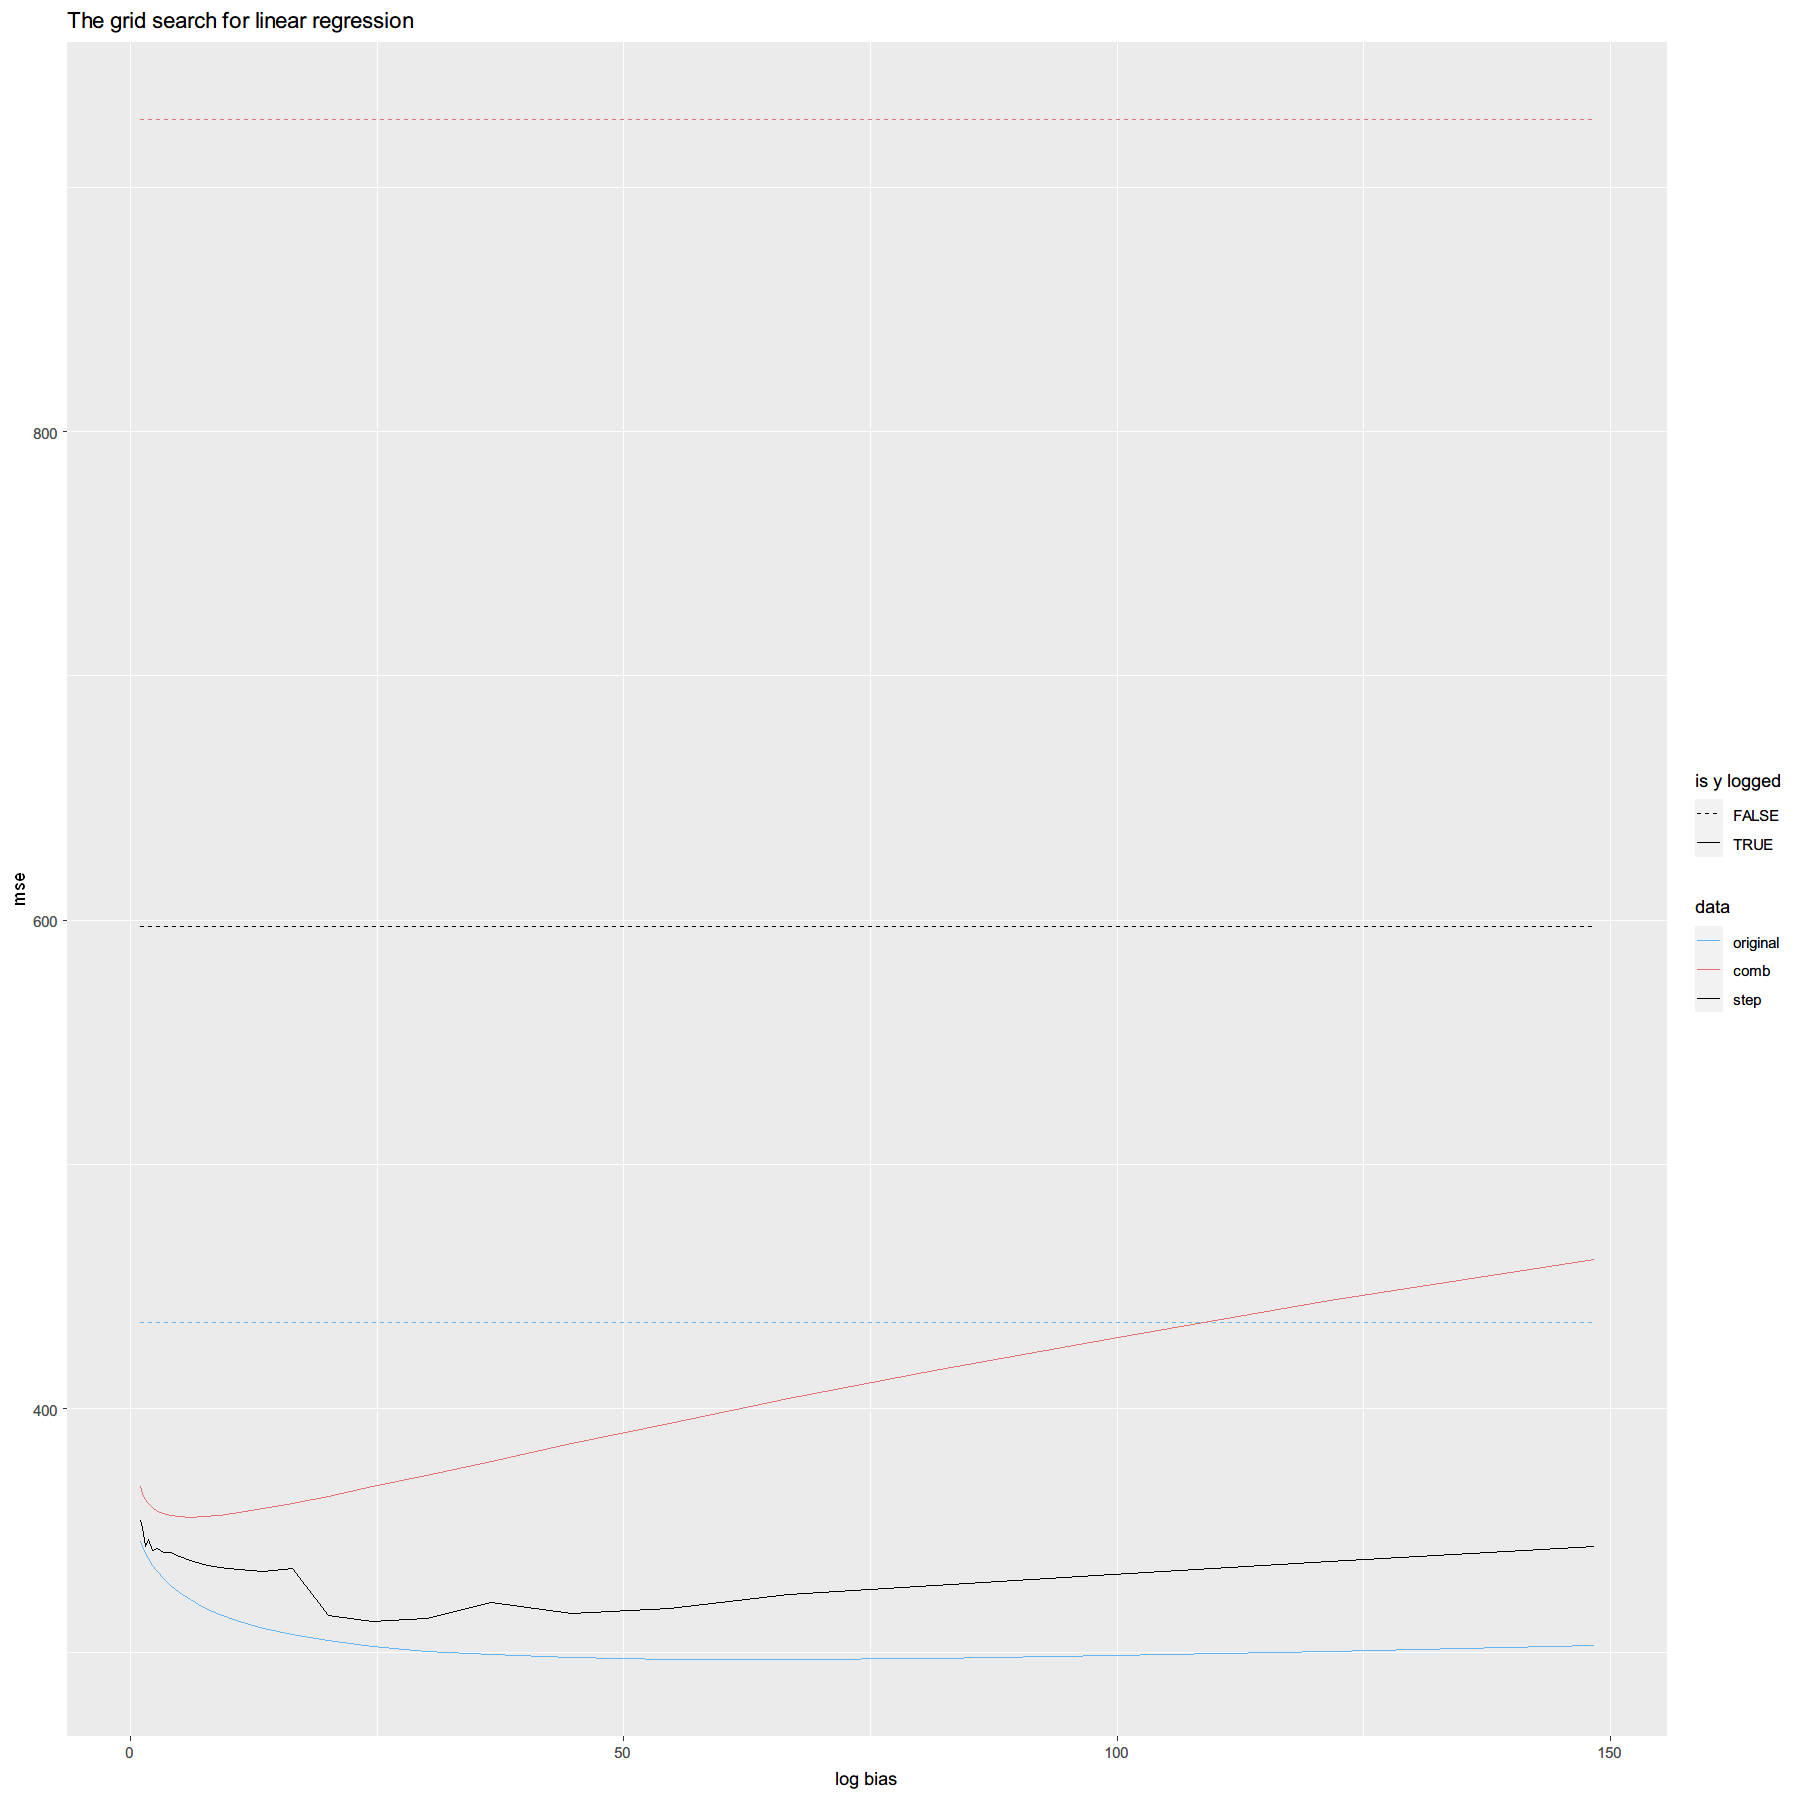

In [77]:
# linear regression
LinearRegression <- setRefClass("LinearRegression", contains = "AbstractRegression",
                                fields = c("model", "x_train", "y_train"), methods = list(
  fit = function(train, comb_data, regularizer = NULL, formula = NULL) {
    # build and fit the model by given train data
    # record the input parameters
    .self$train <- train
    .self$need_comb_data <- comb_data
    formula <- .self$get_default_formula(formula)
    # build model
    .self$model <- {
      # if no regularizer, build a ordinary lm model
      if (is.null(regularizer)) lm(formula = formula, data = .self$train)
      else {
        # if there is a regularizer, build a glmnet model
        .self$use_regularizer <- TRUE
        .self$x_train <- model.matrix(formula, data = .self$train)
        .self$y_train <- .self$train[, "area"] %>% unlist
        glmnet(x = .self$x_train, y = .self$y_train, alpha = 0.5,
               lambda = regularizer$lambda)
      }
    }
    .self
  },
  predict = function(test) {
    # predict the value by given test data
    if (length(.self$use_regularizer) == 0)
      .self$model %>% predict.lm(test) %>% (.self$logy_revert)
    else
      .self$model %>% predict.glmnet(model.matrix(.self$get_default_formula(NULL),
                                                  data = test))
  },
  step = function(k = 2) {
    # this method is for stepwise feature selection
    .self$model <- stats::step(.self$model, trace = 0, k = k)
    .self
  }
))

# hyperparameter grid search
# for original data
lr_grid_search_result1 <- grid_search_1d(exp(seq(0, 5, 0.2)), min, function(x)
    LinearRegression(TRUE, x)$fit(train_data, FALSE)$pred_evaluate(test_data, mse))
# for comb_data
lr_grid_search_result2 <- grid_search_1d(exp(seq(0, 5, 0.2)), min, function(x)
    LinearRegression(TRUE, x)$fit(train_data_comb, TRUE)$pred_evaluate(test_data_comb, mse))
# for comb_data with feature selection
lr_grid_search_result3 <- grid_search_1d(exp(seq(0, 5, 0.2)), min, function(x)
    LinearRegression(TRUE, x)$fit(train_data_comb, TRUE)$step()$pred_evaluate(test_data_comb, mse))
# record the number of parameters
lr_grid_search_len <- length(lr_grid_search_result1$results$x)
# combine the results for visualization for logged area
lr_grid_search_results <- data.frame(
  x = lr_grid_search_result1$results$x,
  original = lr_grid_search_result1$results$result,
  comb = lr_grid_search_result2$results$result,
  step = lr_grid_search_result3$results$result,
  logged_y = rep(TRUE, lr_grid_search_len)
)
# calculate the results for area which is not logged as comparison
lr_original_mse_no_log <- LinearRegression(FALSE, 0)$fit(train_data, FALSE)$
        pred_evaluate(test_data, mse)
lr_comb_mse_no_log <- LinearRegression(FALSE, 0)$fit(train_data_comb, TRUE)$
        pred_evaluate(test_data_comb, mse)
lr_step_mse_no_log <- LinearRegression(FALSE, 0)$fit(train_data_comb, TRUE)$
        step()$pred_evaluate(test_data_comb, mse)

lr_grid_search_results_no_log <- data.frame(
  x = lr_grid_search_result1$results$x,
  original = rep(lr_original_mse_no_log, lr_grid_search_len),
  comb = rep(lr_comb_mse_no_log, lr_grid_search_len),
  step = rep(lr_step_mse_no_log, lr_grid_search_len),
  logged_y = rep(FALSE, lr_grid_search_len)
)
# melt the results together for visualization
lr_grid_search_results_melt <-
  rbind(lr_grid_search_results, lr_grid_search_results_no_log) %>%
  melt(id.vars = c("x", "logged_y"))

ggplot(lr_grid_search_results_melt) +
  geom_line(mapping = aes(x = x, y = value, color = variable, linetype = logged_y)) +
  labs(color = "data", linetype = "is y logged", x = "log bias", y = "mse") +
  scale_linetype_manual(values=c(2,1)) +
  scale_color_manual(values = c(blue, red, "black")) +
  ggtitle("The grid search for linear regression")

From the plot output, the original data without any extra feature get best score, which
is minimum mse. The `comb_data` gets the worst result. The AIC sub-selection gets the
result between the original data and `comb_data`. From the plot, the linear regression
is suitable for the data with no extra features.

Then, select the best hyperparameter and build the linear regression
as a potential model for comparison.

In [78]:
select_best_grid_result <- function(grid_search_results, best_func = min) {
  grid_search_results_values <- grid_search_results %>%
          sapply(function(x) x$best_result) %>% unlist
  which(grid_search_results_values == best_func(grid_search_results_values))
}

lr_grid_search_results <- list(lr_grid_search_result1,
                               lr_grid_search_result2,
                               lr_grid_search_result3)
lr_best_parameter_index <- select_best_grid_result(lr_grid_search_results, min)
linear_regression <- if (lr_best_parameter_index == 1) {
  LinearRegression(TRUE, lr_grid_search_result1$x)$fit(train_data, FALSE)
} else if (lr_best_parameter_index == 2) {
  LinearRegression(TRUE, lr_grid_search_result2$x)$fit(train_data_comb, TRUE)
} else if (lr_best_parameter_index == 3) {
  LinearRegression(TRUE, lr_grid_search_result3$x)$fit(train_data_comb, TRUE)$step()
}

linear_regression %>% evaluate_model(mse)

[1] 297.1184

#### KNN Regression

K-nearest-neighbours is a powerful machine learning algorithm for classification and
regression. In this section, the KNN regression is used for predict the area value.

Implement a `KNNRegression` class with `FNN::knn` function to fit the data (Li, 2020).

In [79]:
# KNN Regressor
KNNRegression <- setRefClass("KNNRegressor", contains = "AbstractRegression",
  fields = list(k = "numeric", x_train = "data.frame", y_train = "numeric"),
  methods = list(
    initialize = function(k, is_logy = FALSE, log_bias = 0) {
      .self$k <- k
      .self$is_logy <- is_logy
      .self$log_bias <- log_bias
    },
    fit = function(train, comb_data) {
      .self$need_comb_data <- comb_data
      .self$train <- train
      .self$x_train <- train %>% select(!c("area", "fire"))
      .self$y_train <- train[, "area"] %>% unlist
      if (.self$is_logy) {
        .self$y_train <- .self$y_train %>% (function(x) log(x + .self$log_bias))
      }
      .self
    },
    predict = function(test) {
      x_test <- test %>% select(!c("area", "fire"))
      knn.reg(train = .self$x_train, y = .self$y_train,
              test = x_test, k = .self$k)$pred %>% (.self$logy_revert)
    }
))

As there are 2 hyperparameter (K and log bias) in this model, the hyperparameter grid search has 2 dimension to plot.
The `geom_tile` is used for 2D grid search.

[1] "Best x: 89"
[1] "Best y: 81.4508686649681"


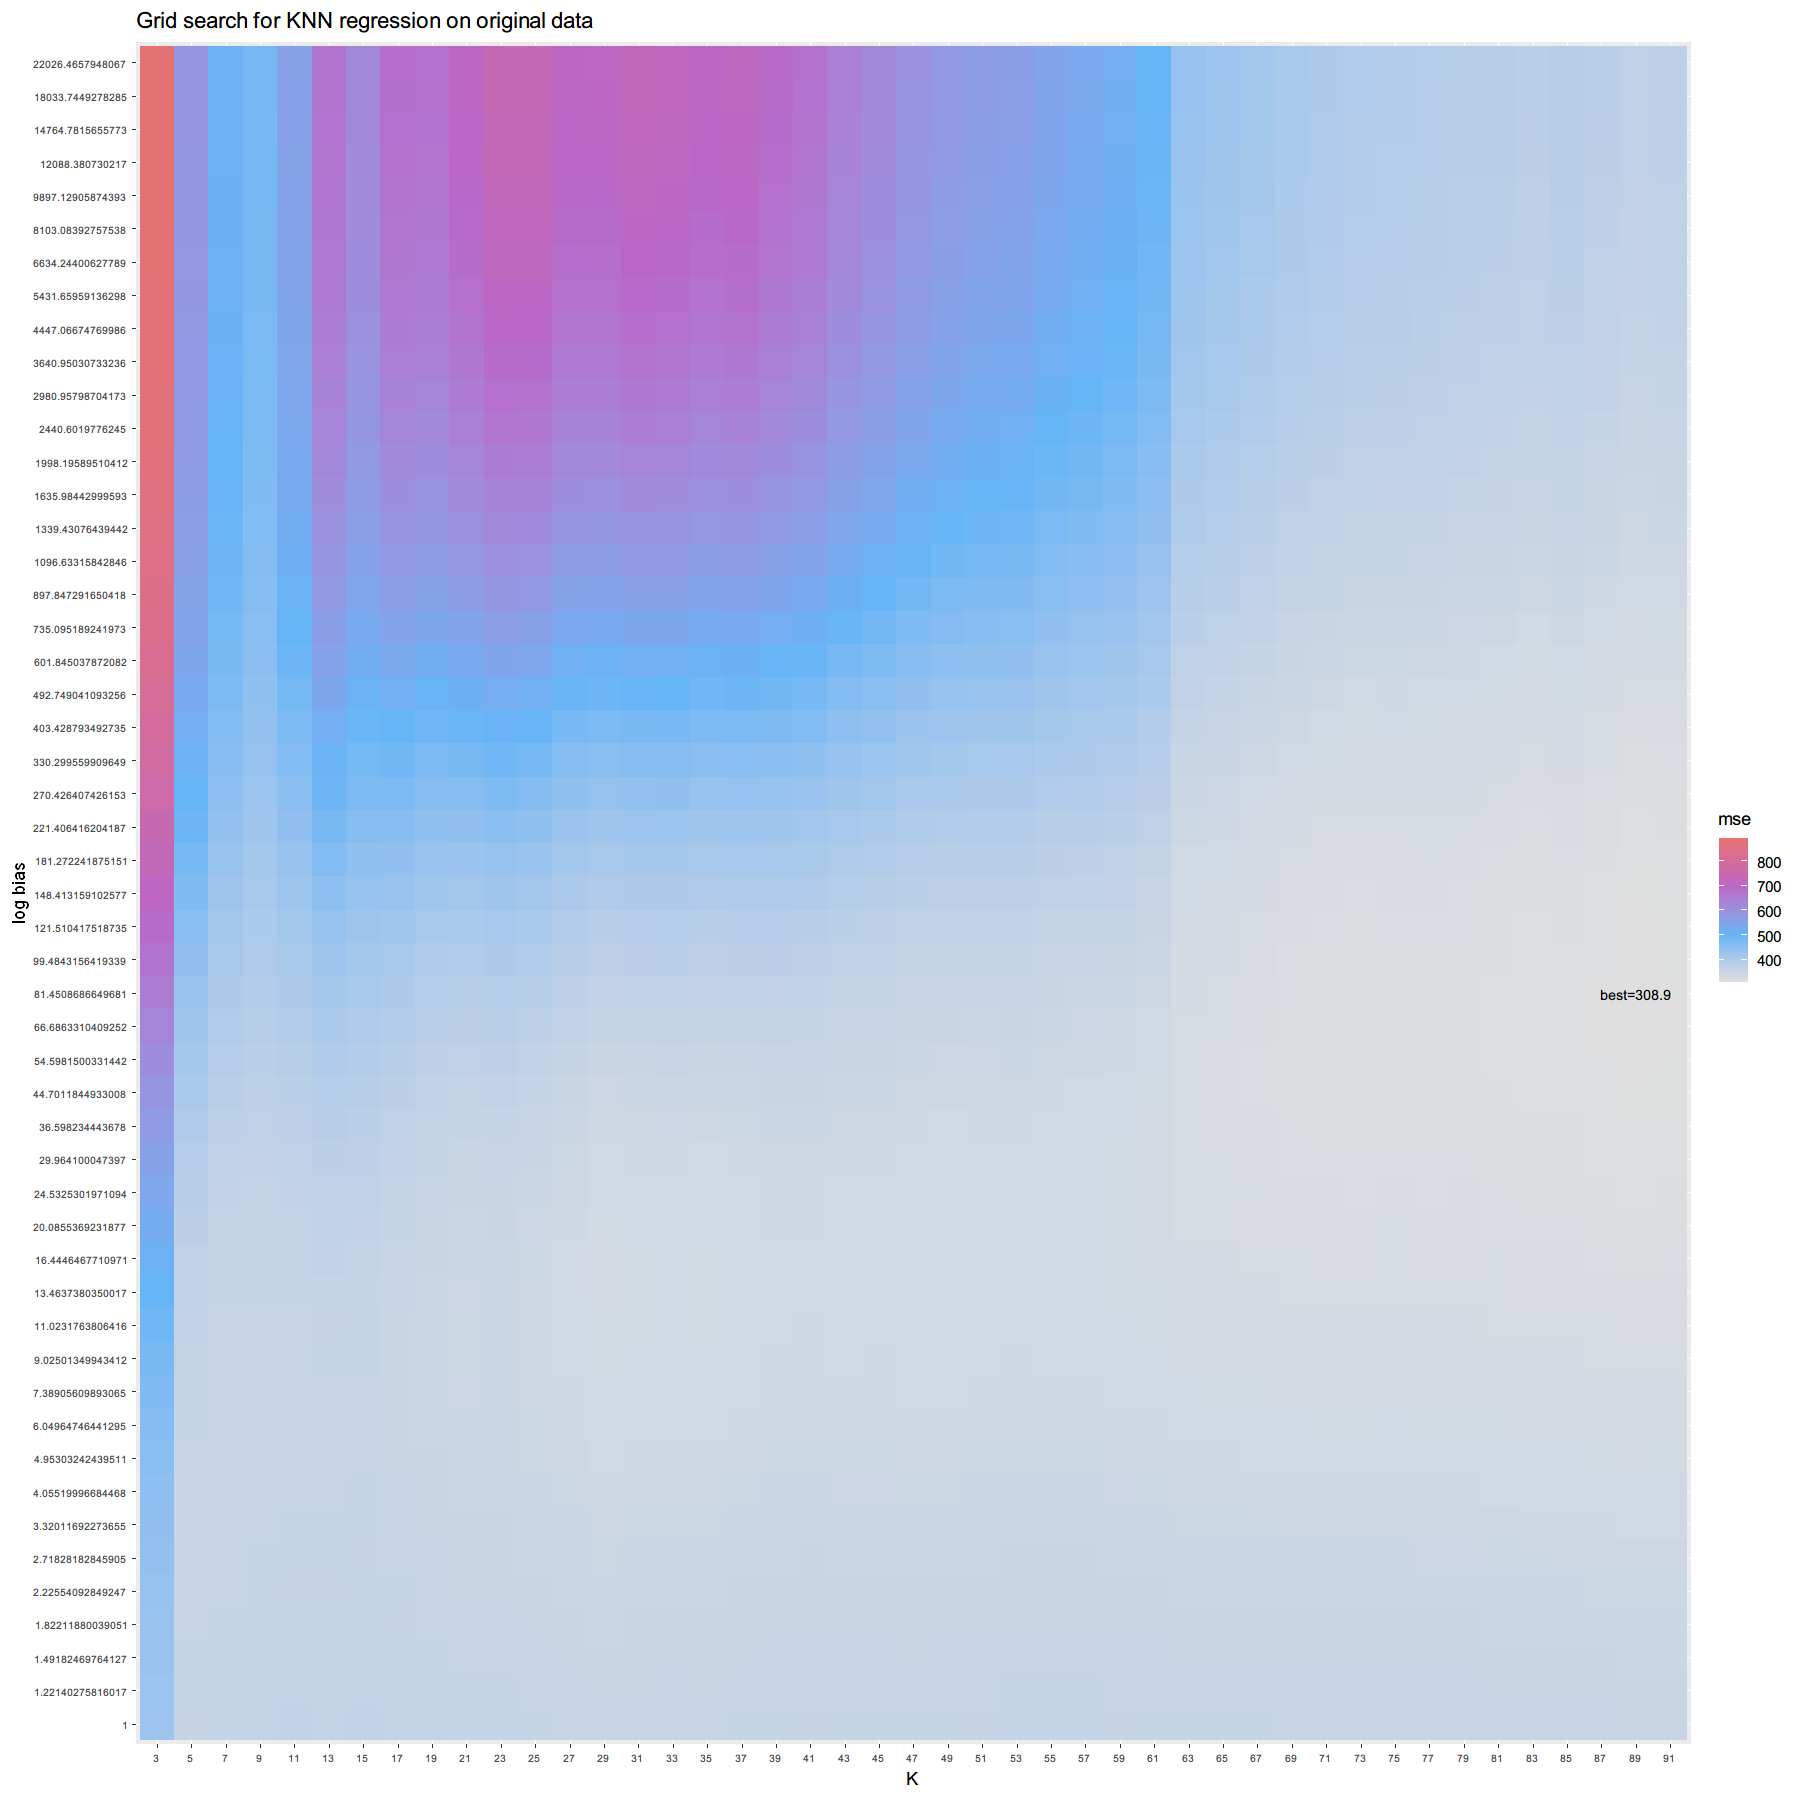

In [80]:
# grid search of KNN with original features
knn_reg_grid_search_result1 <- grid_search_2d(xs = seq(3, 91, 2), ys = exp(seq(0, 10, 0.2)),
                                              min, function(x, y) {
  KNNRegression(x, TRUE, y)$fit(train_data, FALSE)$pred_evaluate(test_data, mse)
})

ggplot() + knn_reg_grid_search_result1$tile + knn_reg_grid_search_result1$annotation +
  scale_fill_gradientn(colors = c(gray, blue, purple, red)) +
  labs(x = "K", y = "log bias", fill = "mse") +
  theme(axis.text = element_text(size = 6)) +
  ggtitle("Grid search for KNN regression on original data")

[1] "Best x: 11"
[1] "Best y: 99.4843156419339"


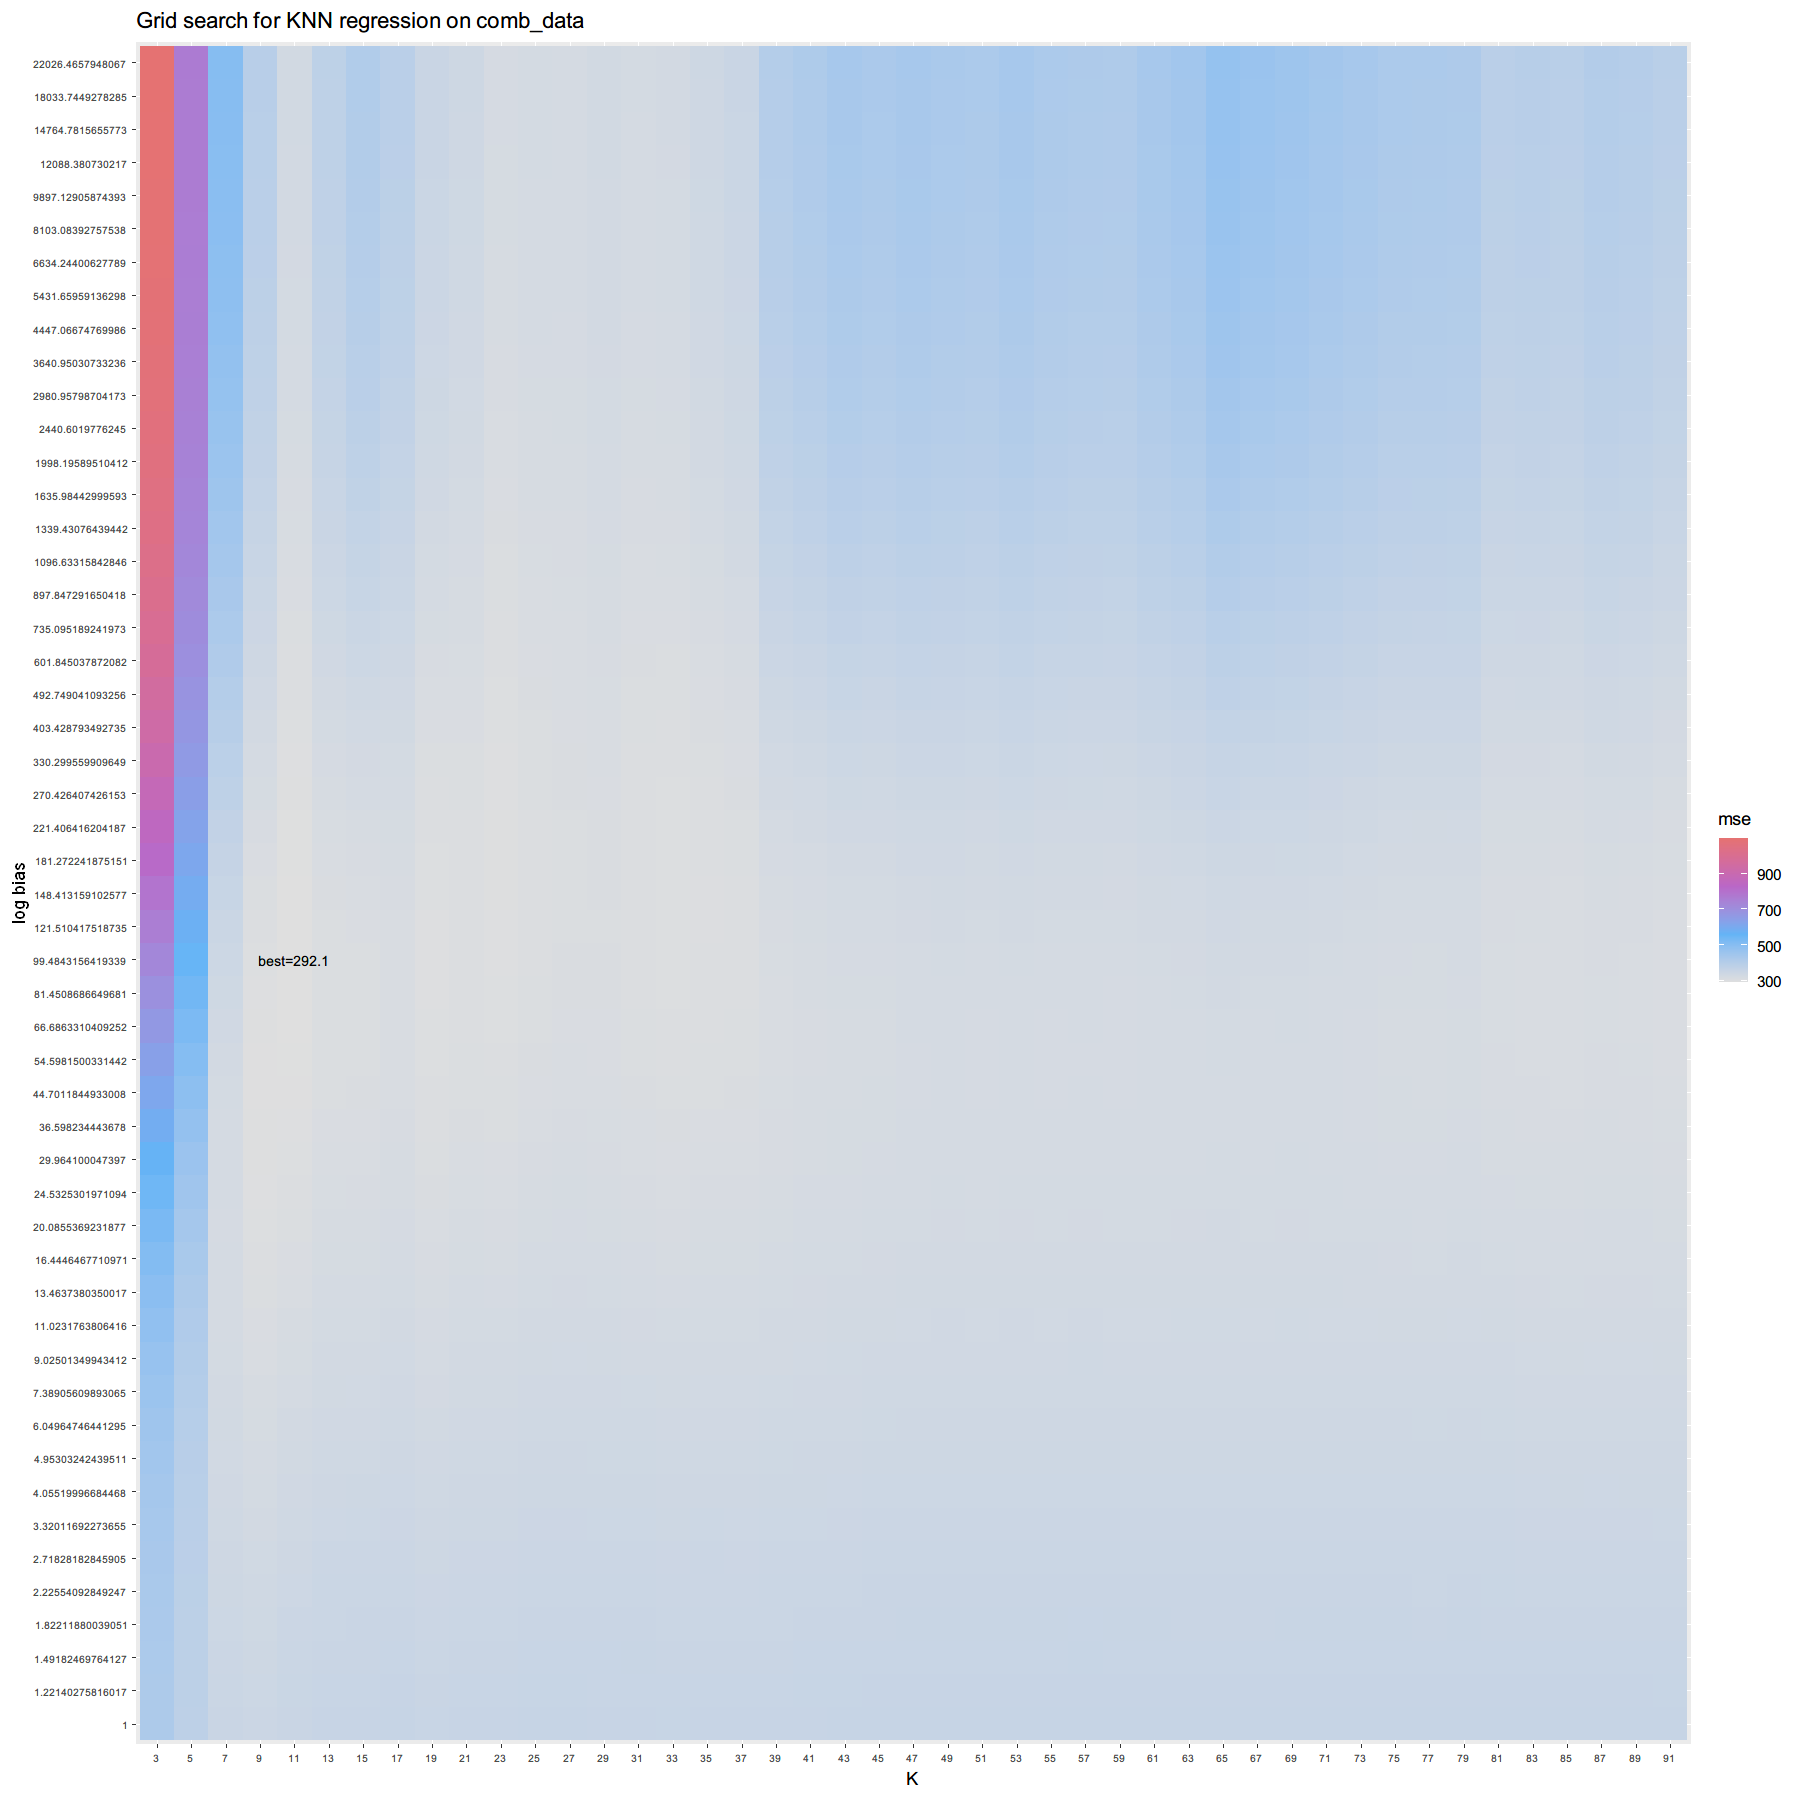

In [81]:
# grid search of KNN with combination features
knn_reg_grid_search_result2 <- grid_search_2d(xs = seq(3, 91, 2), ys = exp(seq(0, 10, 0.2)),
                                              min, function(x, y) {
  KNNRegression(x, TRUE, y)$fit(train_data_comb, TRUE)$pred_evaluate(test_data_comb, mse)
})

ggplot() + knn_reg_grid_search_result2$tile + knn_reg_grid_search_result2$annotation +
  scale_fill_gradientn(colors = c(gray, blue, purple, red)) +
  labs(x = "K", y = "log bias", fill = "mse") +
  theme(axis.text = element_text(size=6)) +
  ggtitle("Grid search for KNN regression on comb_data")

In [82]:
# get best knn regression
knn_reg_grid_search_results <- list(knn_reg_grid_search_result1,
                                    knn_reg_grid_search_result2)
knn_reg_best_parameter_index <- select_best_grid_result(knn_reg_grid_search_results, min)

knn_regression <- if (knn_reg_best_parameter_index == 1) {
  KNNRegression(knn_reg_grid_search_result1$x, TRUE, knn_reg_grid_search_result1$y)$
          fit(train_data, FALSE)
} else if (knn_reg_best_parameter_index == 2) {
  KNNRegression(knn_reg_grid_search_result2$x, TRUE, knn_reg_grid_search_result2$y)$
          fit(train_data_comb, TRUE)
}
knn_regression %>% evaluate_model(mse)

[1] 292.0738

#### Decision Tree

Decision tree is another machine learning algorithm that has good interpretability.
It can be used for classification and regression as well.

Here the decision tree for regression is implemented as `DecisionTreeRegression` class.

[1] "Best hyperparameter value is 6.68589444227927"
[1] "Best value is 338.542793713863"
[1] "Best hyperparameter value is 0.49658530379141"
[1] "Best value is 373.270677349838"


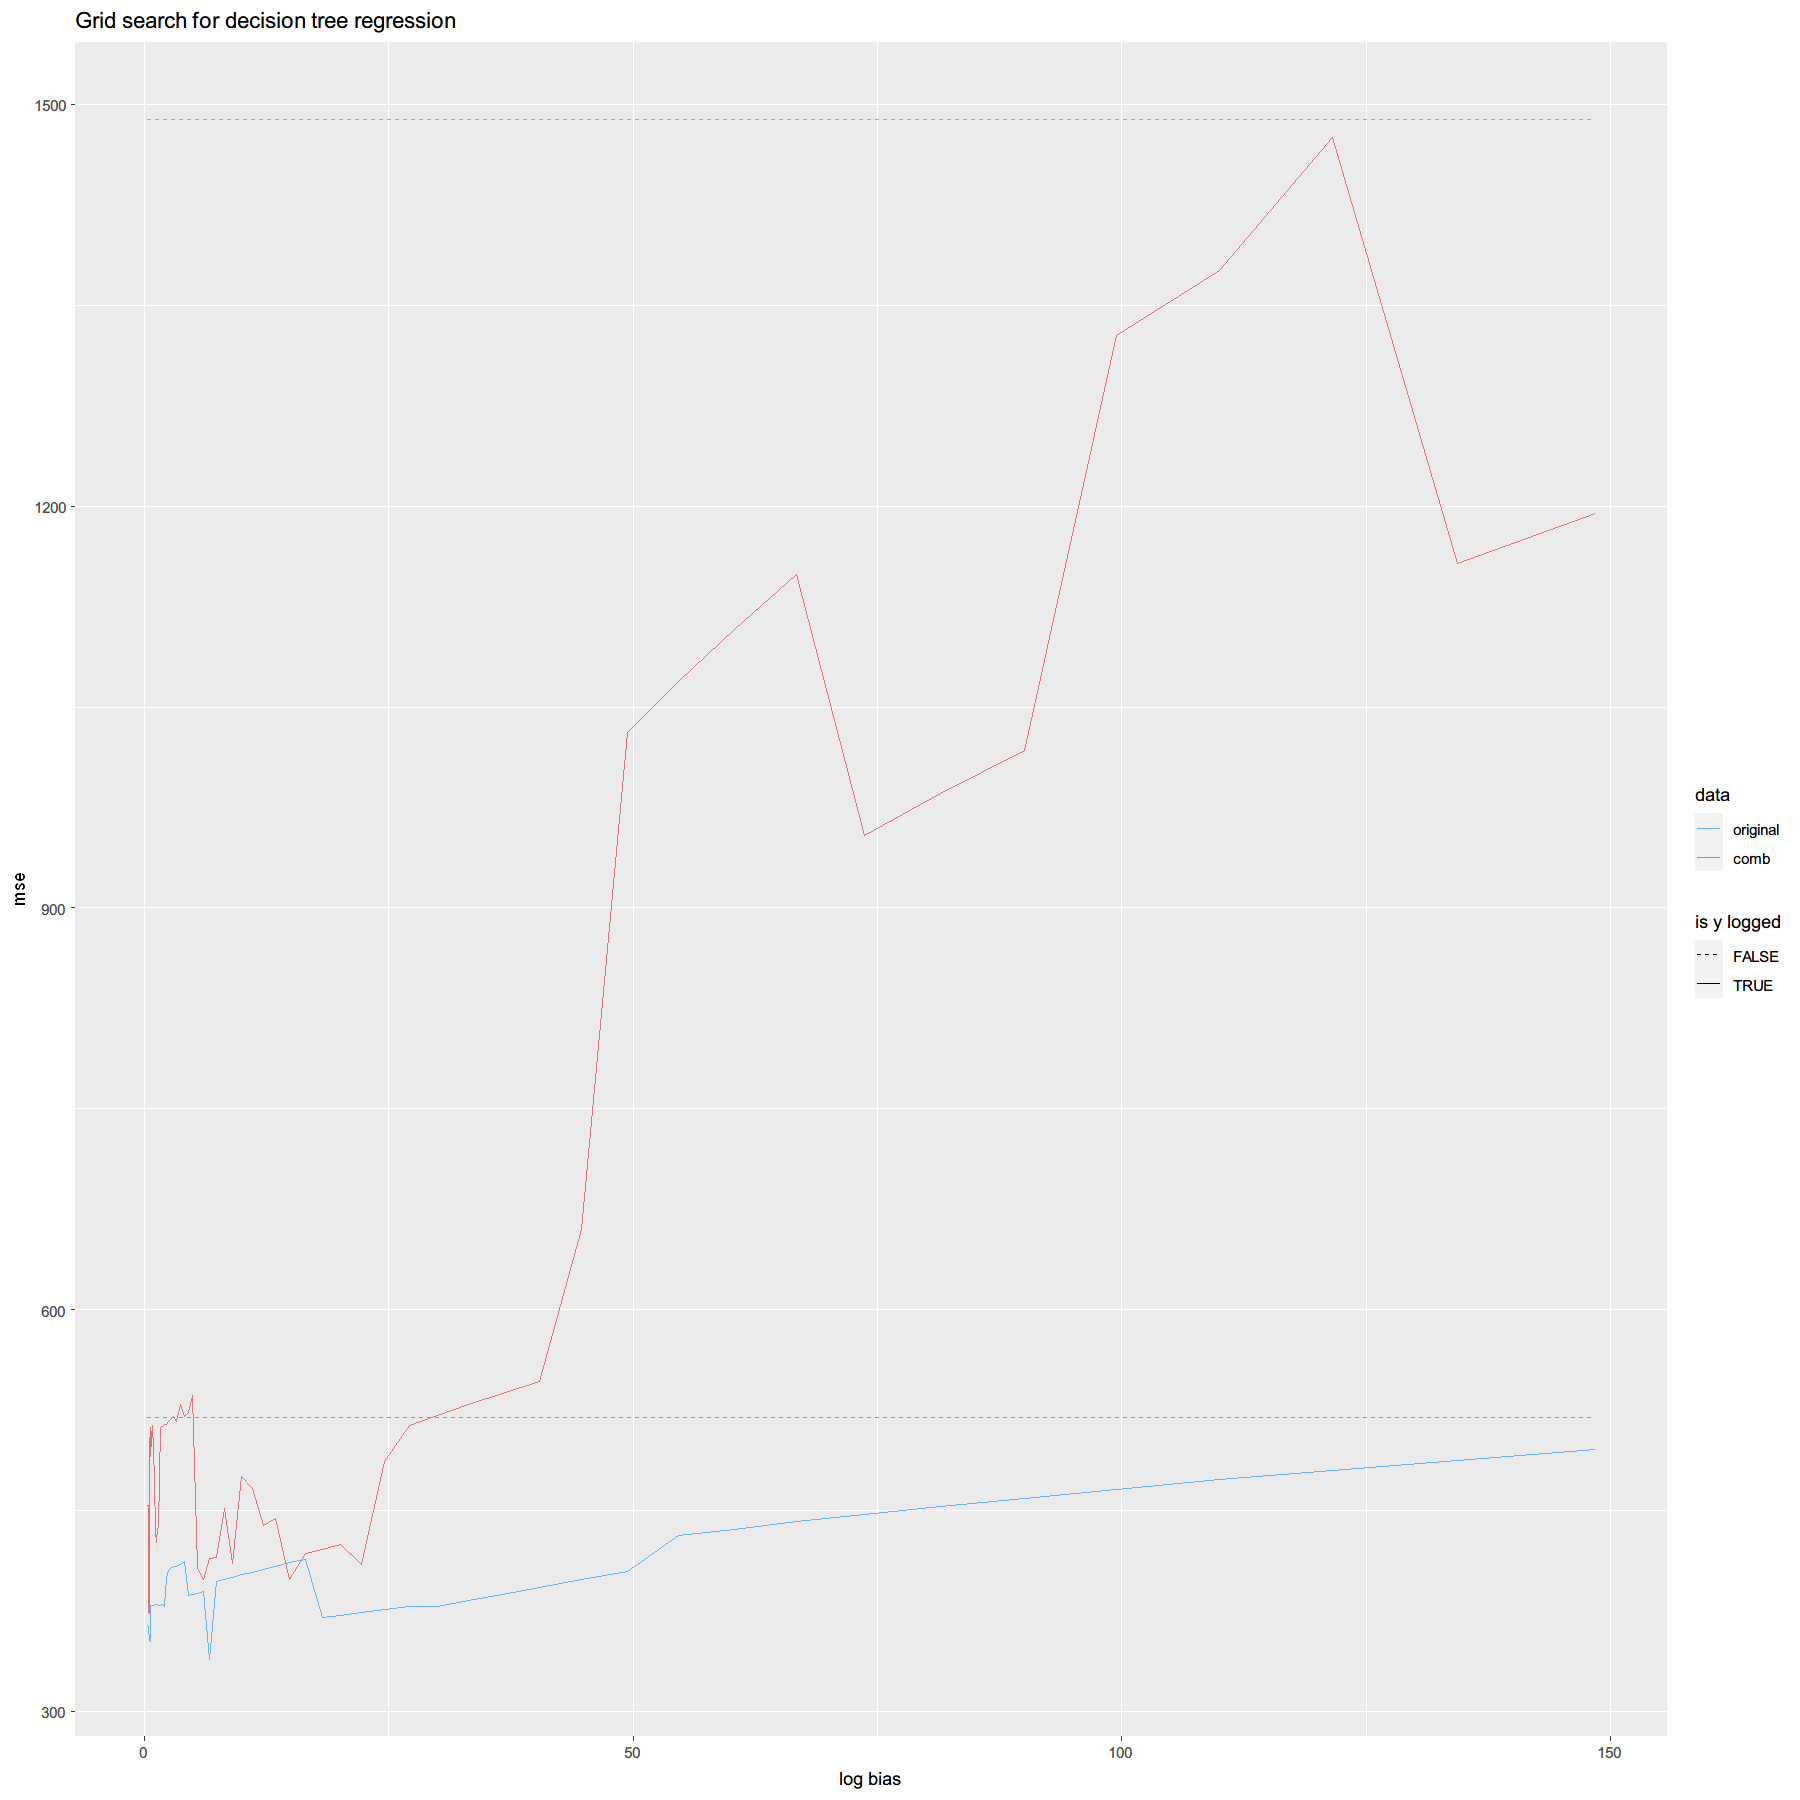

In [83]:
# Decision Tree Regression
DecisionTreeRegression <- setRefClass("DecisionTreeRegression",
  contains = "AbstractRegression",
  fields = c("model"),
  methods = list(
    fit = function(train, comb_data, formula = NULL) {
      .self$need_comb_data <- comb_data
      .self$train <- train
      formula <- .self$get_default_formula(formula)
      .self$model <- tree(formula = formula, data = .self$train)
      .self
    },
    predict = function(test) {
      .self$model %>% stats::predict(test) %>% (.self$logy_revert)
    }
))

# grid search
decision_tree_reg_grid_search_result1 <- grid_search_1d(exp(seq(-1, 5, 0.1)), min, function(x)
  DecisionTreeRegression(TRUE, x)$fit(train_data, FALSE)$pred_evaluate(test_data, mse))
decision_tree_reg_grid_search_result2 <- grid_search_1d(exp(seq(-1, 5, 0.1)), min, function(x)
  DecisionTreeRegression(TRUE, x)$fit(train_data_comb, TRUE)$pred_evaluate(test_data_comb, mse))

decision_tree_reg_grid_search_len <-
        length(decision_tree_reg_grid_search_result1$results$x)

decision_tree_reg_grid_search_results <- data.frame(
  x = decision_tree_reg_grid_search_result1$results$x,
  original = decision_tree_reg_grid_search_result1$results$result,
  comb = decision_tree_reg_grid_search_result2$results$result,
  logged_y = rep(TRUE, decision_tree_reg_grid_search_len)
)
# calculate the results for area which is not logged as comparison
decision_tree_regression_original_mse_no_log <- DecisionTreeRegression(FALSE, 0)$
        fit(train_data, FALSE)$pred_evaluate(test_data, mse)
decision_tree_regression_comb_mse_no_log <- DecisionTreeRegression(FALSE, 0)$
        fit(train_data_comb, TRUE)$pred_evaluate(test_data_comb, mse)

decision_tree_regression_grid_search_results_no_log <- data.frame(
  x = decision_tree_reg_grid_search_result1$results$x,
  original = rep(decision_tree_regression_original_mse_no_log,
                 decision_tree_reg_grid_search_len),
  comb = rep(decision_tree_regression_comb_mse_no_log,
             decision_tree_reg_grid_search_len),
  logged_y = rep(FALSE, decision_tree_reg_grid_search_len)
)

# melt the results together for visualization
decision_tree_regression_grid_search_results_melt <-
  rbind(decision_tree_reg_grid_search_results,
        decision_tree_regression_grid_search_results_no_log) %>%
  melt(id.vars = c("x", "logged_y"))

ggplot(decision_tree_regression_grid_search_results_melt) +
  geom_line(mapping = aes(x = x, y = value, color = variable, linetype = logged_y)) +
  labs(color = "data", linetype = "is y logged", x = "log bias", y = "mse") +
  scale_linetype_manual(values = c(2,1)) +
  scale_color_manual(values = c(blue, red)) +
  ggtitle("Grid search for decision tree regression")

From the output plot, the Decision Tree applied on the original data has better performance.
Therefore, choose the best one to build a Decision Tree regressor as a potential model.

In [84]:
# Build best decision tree
decision_tree_reg_grid_search_results <- list(decision_tree_reg_grid_search_result1,
                                              decision_tree_reg_grid_search_result2)
decision_tree_reg_best_parameter_index <-
        select_best_grid_result(decision_tree_reg_grid_search_results, min)
decision_tree_regression <- if (decision_tree_reg_best_parameter_index == 1) {
  DecisionTreeRegression(TRUE, decision_tree_reg_grid_search_result1$x)$
          fit(train_data, FALSE)
} else if (decision_tree_reg_best_parameter_index == 2) {
  DecisionTreeRegression(TRUE, decision_tree_reg_grid_search_result2$x)$
          fit(train_data_comb, TRUE)
}
decision_tree_regression %>% evaluate_model(mse)

[1] 338.5428

### Build compound models

The compound model is a complex model built by a classifier and a regressor. The new
label `fire` has been created for the classifier. If the classifier predict there is
no fire, the prediction for `area` is 0. If the classifier predict there is some fire,
the `area` will be predicted by the regressor for accurate `area` value. Moreover,
if the predicted value is less than 0, the result will be 0, because in the original data,
the `area` values are always positive.

Therefore, the classifiers need to be built, and the best of them will be chosen.

#### Classifiers
For classifiers, there is no need for logged y, so that the model development will be
easier.

Logistic regression is a linear model for classification. This will be implemented by
the class `LogisticRegression`.

In logistic regression, there is only one hyperparameter, which is the threshold for
classify from the probability to label. The default is 0.5, but it can also be a numeric
value between 0 and 1.

[1] "Best hyperparameter value is 0.4"
[1] "Best value is 0.553398058252427"
[1] "Best hyperparameter value is 0.44"
[1] "Best value is 0.563106796116505"
[1] "Best hyperparameter value is 0.4"
[1] "Best value is 0.572815533980582"


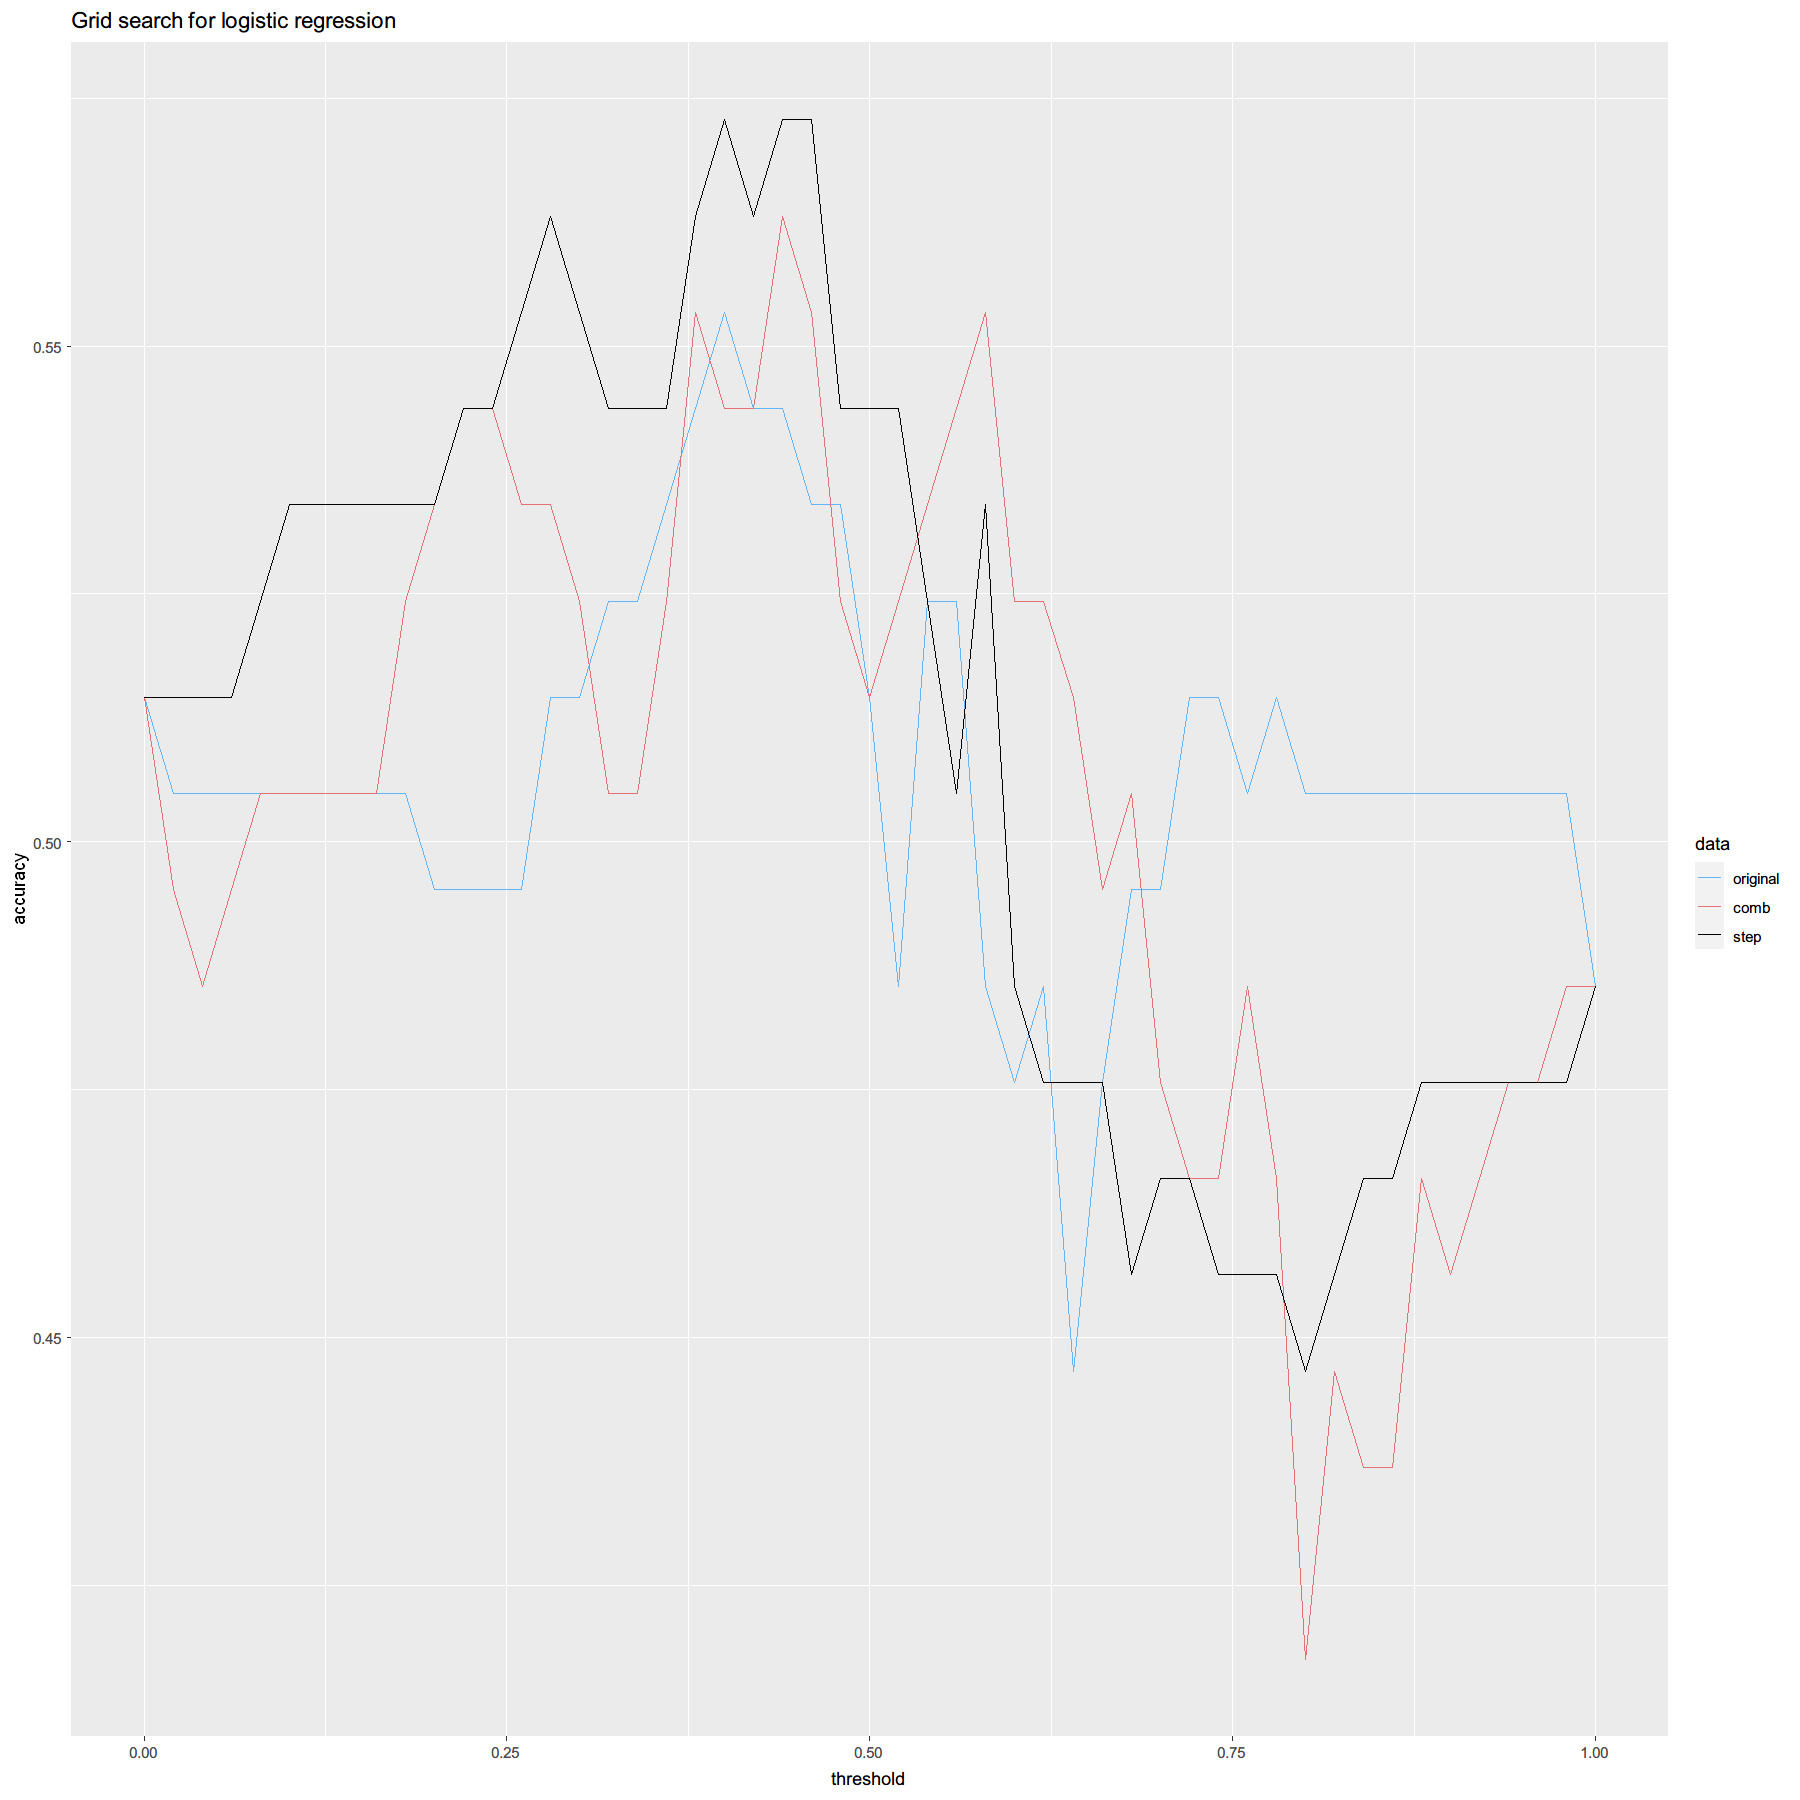

In [85]:
# Logistic Regression
LogisticRegression <- setRefClass("LogisticRegression",
  contains = "AbstractClassifier",
  fields = list(model = "glm", threshold = "numeric"),
  methods = list(
    initialize = function(threshold = 0.5) {
      .self$threshold <- threshold
    },
    fit = function(train, comb_data, formula = NULL) {
      .self$need_comb_data <- comb_data
      .self$train <- train
      formula <- .self$get_default_formula(formula)
      .self$model <- glm(formula = formula, family = binomial, data = .self$train)
      .self
    },
    predict = function(test) {
      prob <- .self$model %>% predict.glm(newdata = test, type = "response")
      prob > .self$threshold
    },
    set_threshold = function(threshold) {
      .self$threshold <- threshold
      .self
    },
    step = function(k = 2) {
      .self$model <- stepAIC(.self$model, k = k, direction = "backward", trace = 0)
      .self
    }
))

# Logistic regression with original dataset, combination feature dataset,
# and the dataset with stepwise sub-selection
logistic_regression1 <- LogisticRegression()$fit(train_data, FALSE)
logistic_regression2 <- LogisticRegression()$fit(train_data_comb, TRUE)
logistic_regression3 <- LogisticRegression()$fit(train_data_comb, TRUE)$step()

logistic_reg_grid_search_result1 <- grid_search_1d(seq(0, 1, 0.02), max, function(x)
    logistic_regression1$set_threshold(x)$pred_evaluate(test_data, accuracy))
logistic_reg_grid_search_result2 <- grid_search_1d(seq(0, 1, 0.02), max, function(x)
    logistic_regression2$set_threshold(x)$pred_evaluate(test_data_comb, accuracy))
logistic_reg_grid_search_result3 <- grid_search_1d(seq(0, 1, 0.02), max, function(x)
    logistic_regression3$set_threshold(x)$pred_evaluate(test_data_comb, accuracy))

logistic_reg_grid_search_len <- length(seq(0, 1, 0.02))

logistic_reg_grid_search_results_melt <- data.frame(
  x = logistic_reg_grid_search_result1$results$x,
  original = logistic_reg_grid_search_result1$results$result,
  comb = logistic_reg_grid_search_result2$results$result,
  step = logistic_reg_grid_search_result3$results$result
) %>% melt(id.vars = "x")

ggplot(logistic_reg_grid_search_results_melt) +
  geom_line(aes(x = x, y = value, color = variable)) +
  scale_color_manual(values = c(blue, red, "black")) +
  labs(color = "data", x = "threshold", y = "accuracy") +
  ggtitle("Grid search for logistic regression")

From the output, it is clearly that the model performs best when the threshold is between
0.35 to 0.5 . The sub-selected model is the best one.

In [86]:
# select the best logistic regression
logistic_reg_grid_search_results <- list(logistic_reg_grid_search_result1,
                                         logistic_reg_grid_search_result2,
                                         logistic_reg_grid_search_result3)
logistic_reg_reg_best_parameter_index <- select_best_grid_result(logistic_reg_grid_search_results, max)

logistic_regression <- if (logistic_reg_reg_best_parameter_index == 1) {
  logistic_regression1$set_threshold(logistic_reg_grid_search_result1$x)
} else if (logistic_reg_reg_best_parameter_index == 2) {
  logistic_regression2$set_threshold(logistic_reg_grid_search_result2$x)
} else if (logistic_reg_reg_best_parameter_index == 3) {
  logistic_regression3$set_threshold(logistic_reg_grid_search_result3$x)
}

logistic_regression %>% evaluate_model(accuracy)

[1] 0.5728155

KNN can also be used for classification task. The compound model can use knn classifier
in classification stage. The knn classifier is implemented as `KNNClassifier` class.

[1] "Best hyperparameter value is 1"
[1] "Best value is 0.601941747572815"
[1] "Best hyperparameter value is 1"
[1] "Best value is 0.572815533980582"


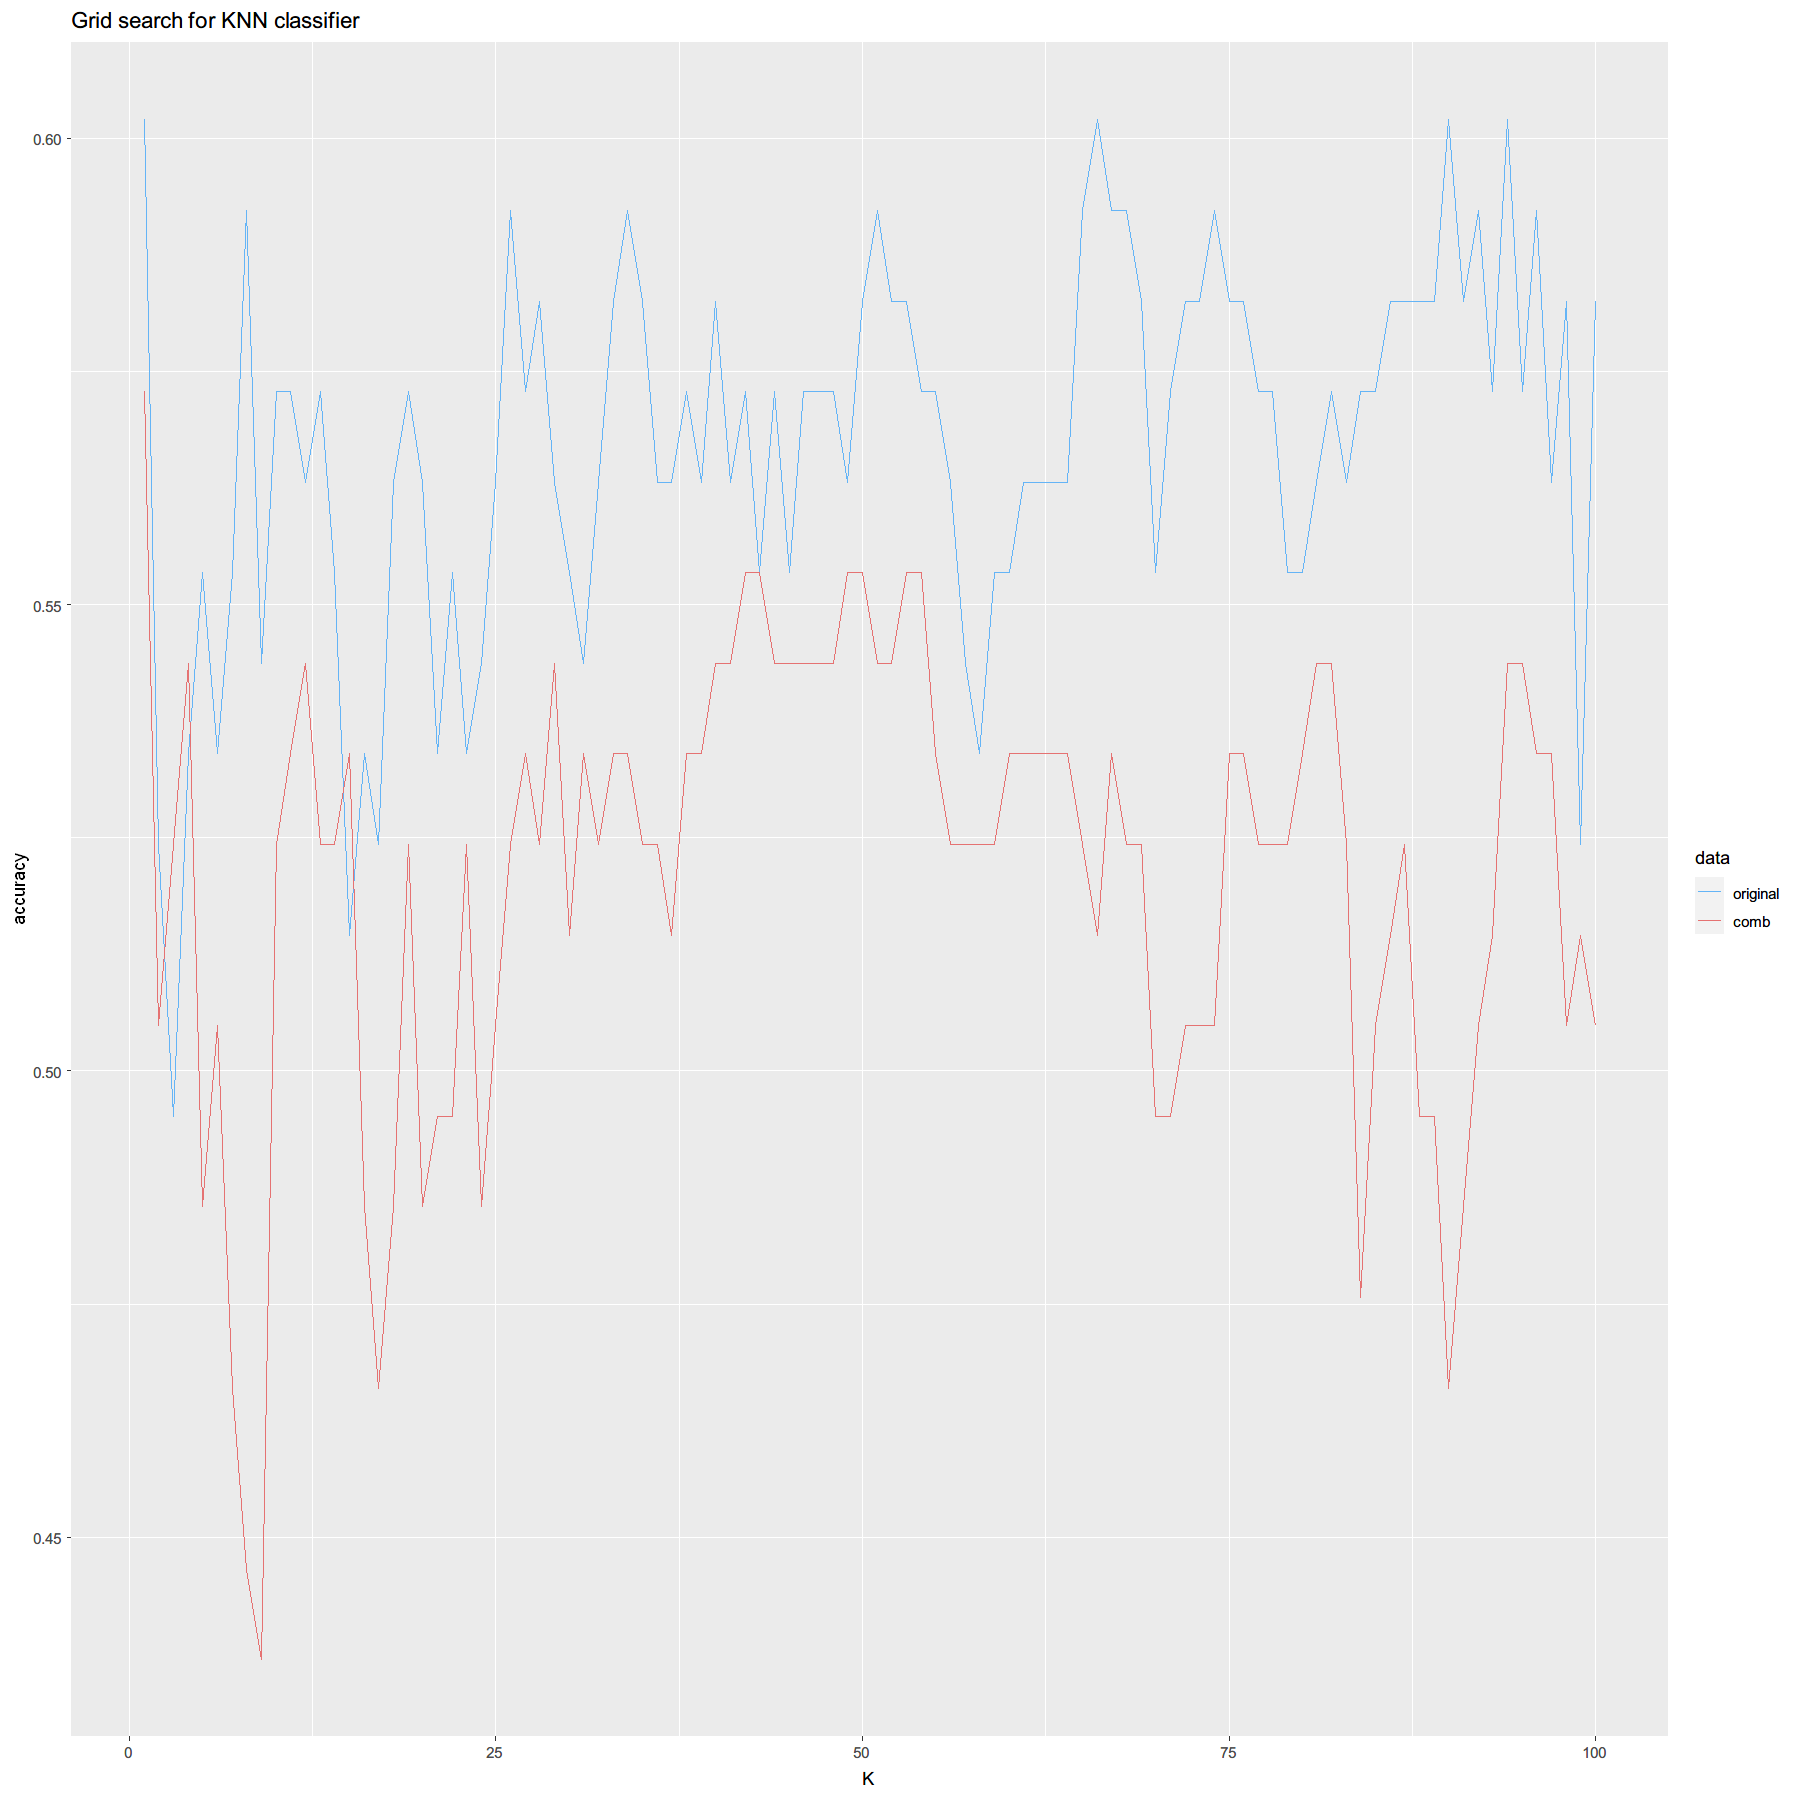

In [87]:
# KNN Classifier
KNNClassifier <- setRefClass("KNNClassifier", contains = "AbstractClassifier",
                             fields = list(k = "numeric", x_train = "data.frame", y_train = "logical"),
                             methods = list(
  initialize = function(k) {
    .self$k <- k
  },
  fit = function(train, comb_data) {
    .self$need_comb_data <- comb_data
    .self$x_train <- train %>% select(!c("area", "fire"))
    .self$y_train <- train[, "fire"] %>% unlist
    .self
  },
  predict = function(test) {
    x_test <- test %>% select(!c("area", "fire"))
    FNN::knn(train = .self$x_train, cl = .self$y_train, test = x_test, k = .self$k)
  }
))

# KNN classifier with original dataset and combination feature dataset
knn_cla_grid_search_result1 <- grid_search_1d(seq(1, 100, 1), max, function(x)
    KNNClassifier(x)$fit(train_data, FALSE)$pred_evaluate(test_data, accuracy))

knn_cla_grid_search_result2 <- grid_search_1d(seq(1, 100, 1), max, function(x)
    KNNClassifier(x)$fit(train_data_comb, TRUE)$pred_evaluate(test_data_comb, accuracy))

knn_cla_grid_search_len <- length(seq(1, 100, 1))

knn_cla_grid_search_results_melt <- data.frame(
  x = knn_cla_grid_search_result1$results$x,
  original = knn_cla_grid_search_result1$results$result,
  comb = knn_cla_grid_search_result2$results$result
) %>% melt(id.vars = "x")

ggplot(knn_cla_grid_search_results_melt) +
  geom_line(aes(x = x, y = value, color = variable)) +
  scale_color_manual(values = c(blue, red)) +
  labs(color = "data", x = "K", y = "accuracy") +
  ggtitle("Grid search for KNN classifier")

From the output of KNN classifier, the model applying on original data without any
modified features has better performance than the `comb_data`.

The best model will be selected in the next code block.

In [88]:
# grid search of KNN with original features
knn_cla_grid_search_results <- list(knn_cla_grid_search_result1, knn_cla_grid_search_result2)
knn_cla_best_parameter_index <- select_best_grid_result(knn_cla_grid_search_results, max)

knn_classifier <- if (knn_cla_best_parameter_index == 1) {
  KNNClassifier(knn_cla_grid_search_result1$x)$fit(train_data, FALSE)
} else if (knn_cla_best_parameter_index == 2) {
  KNNClassifier(knn_cla_grid_search_result2$x)$fit(train_data_comb, TRUE)
}

knn_classifier %>% evaluate_model(accuracy)

[1] 0.6019417

The decision tree is also suitable for classification. It will be implemented on the next
code block.

As there is no hyperparameter for decision tree classifier here, there is no need for
grid search.

In [89]:
# Decision tree classifier
DecisionTreeClassifier <- setRefClass("DecisionTreeClassifier", contains = "AbstractClassifier",
                                      fields = c("model"), methods = list(
  fit = function(train, comb_data, formula = NULL) {
    .self$need_comb_data <- comb_data
    formula <- .self$get_default_formula(formula)
    .self$model <- tree(formula = formula, data = train)
    .self
  },
  predict = function(test) {
    prob <- .self$model %>% stats::predict(newdata = test)
    prob > 0.5
  }
))

# Decision tree classifier with original dataset and combination feature dataset
decision_tree_cla_results <- c(
  DecisionTreeClassifier()$fit(train_data, FALSE)$pred_evaluate(test_data, accuracy),
  DecisionTreeClassifier()$fit(train_data_comb, TRUE)$pred_evaluate(test_data_comb, accuracy)
)
decision_tree_cla_results

[1] 0.5242718 0.5339806

After examining the results of decision tree classifier MSE for original data and `comb_data`,
the model applying on `comb_data` has better performance.
Next step is choosing the best one.

In [90]:
decision_tree_cla_best_parameter_index <-
        which(decision_tree_cla_results == max(decision_tree_cla_results))
decision_tree_classifier <- if (decision_tree_cla_best_parameter_index == 1) {
  DecisionTreeClassifier()$fit(train_data, FALSE)
} else if (decision_tree_cla_best_parameter_index == 2) {
  DecisionTreeClassifier()$fit(train_data_comb, TRUE)
}
decision_tree_classifier %>% evaluate_model(accuracy)

[1] 0.5339806

#### Compound Models

In this section, the `CompoundModel` class is implemented for the complex model which
is built by one classifier and one regressor.

The compound model will only be created by existed model built in above sections, so there
is no `fit` method in `CompoundModel`.

The compound model has these steps for predict `area` value.

1. Classify the data if there is a `fire` happening by the classifier.
  1.1 If the `fire` predicted is TRUE, return predicted `area` = 0
  1.2 If the `fire` predicted is FALSE, go to next step.
2. Use regressor to predict the accurate value of `area`.
3. Use ReLU ($f(x) = max(0, x)$) to set the negative value as 0.

With these steps, the compound model might have better performance than a single
regressor model.

In [91]:
CompoundModel <- setRefClass("CompoundModel", contains = "AbstractRegression",
  fields = list(classifier = "AbstractClassifier", regressor = "AbstractRegression"),
  methods = list(
    initialize = function(classifier, regressor) {
      .self$classifier <- classifier
      .self$regressor <- regressor
    },

    predict = function(test, test_comb) {
      # predict the data is fire or not fire
      fire_pred <- {
        if (.self$classifier$need_comb_data) .self$classifier$predict(test_comb)
        else .self$classifier$predict(test)
      }
      # the classifier returns TRUE or FALSE, then set FALSE as 0
      predict_by_regressor <- function(row) {
        # if it fires (area > 0), use regressor to predict the area
        if (fire_pred[row] == as.factor(TRUE)) {
          if (.self$regressor$need_comb_data) .self$regressor$predict(test_comb[row,])
          else .self$regressor$predict(test[row,])
        }
        # else predict the fire area as 0
        else 0
      }
      # use relu to set all negative prediction as 0
      relu <- function(pred) max(0, pred)
      # predict
      y_pred <- 1:nrow(test) %>% sapply(function(row) row %>% predict_by_regressor %>% relu)
      y_pred
    },

    pred_evaluate = function(test, test_comb, evaluate_func) {
      y_test <- test[,"area"]
      y_pred <- .self$predict(test, test_comb)
      evaluate_func(y_test %>% unlist, y_pred)
    }
))

Next step is using 2D grid search for compound model selection. The hyperparameter for
compound model is the regressor and classifier.


[1] "Best regressor: KNNRegressor"
[1] "Best classifier: LogisticRegression"


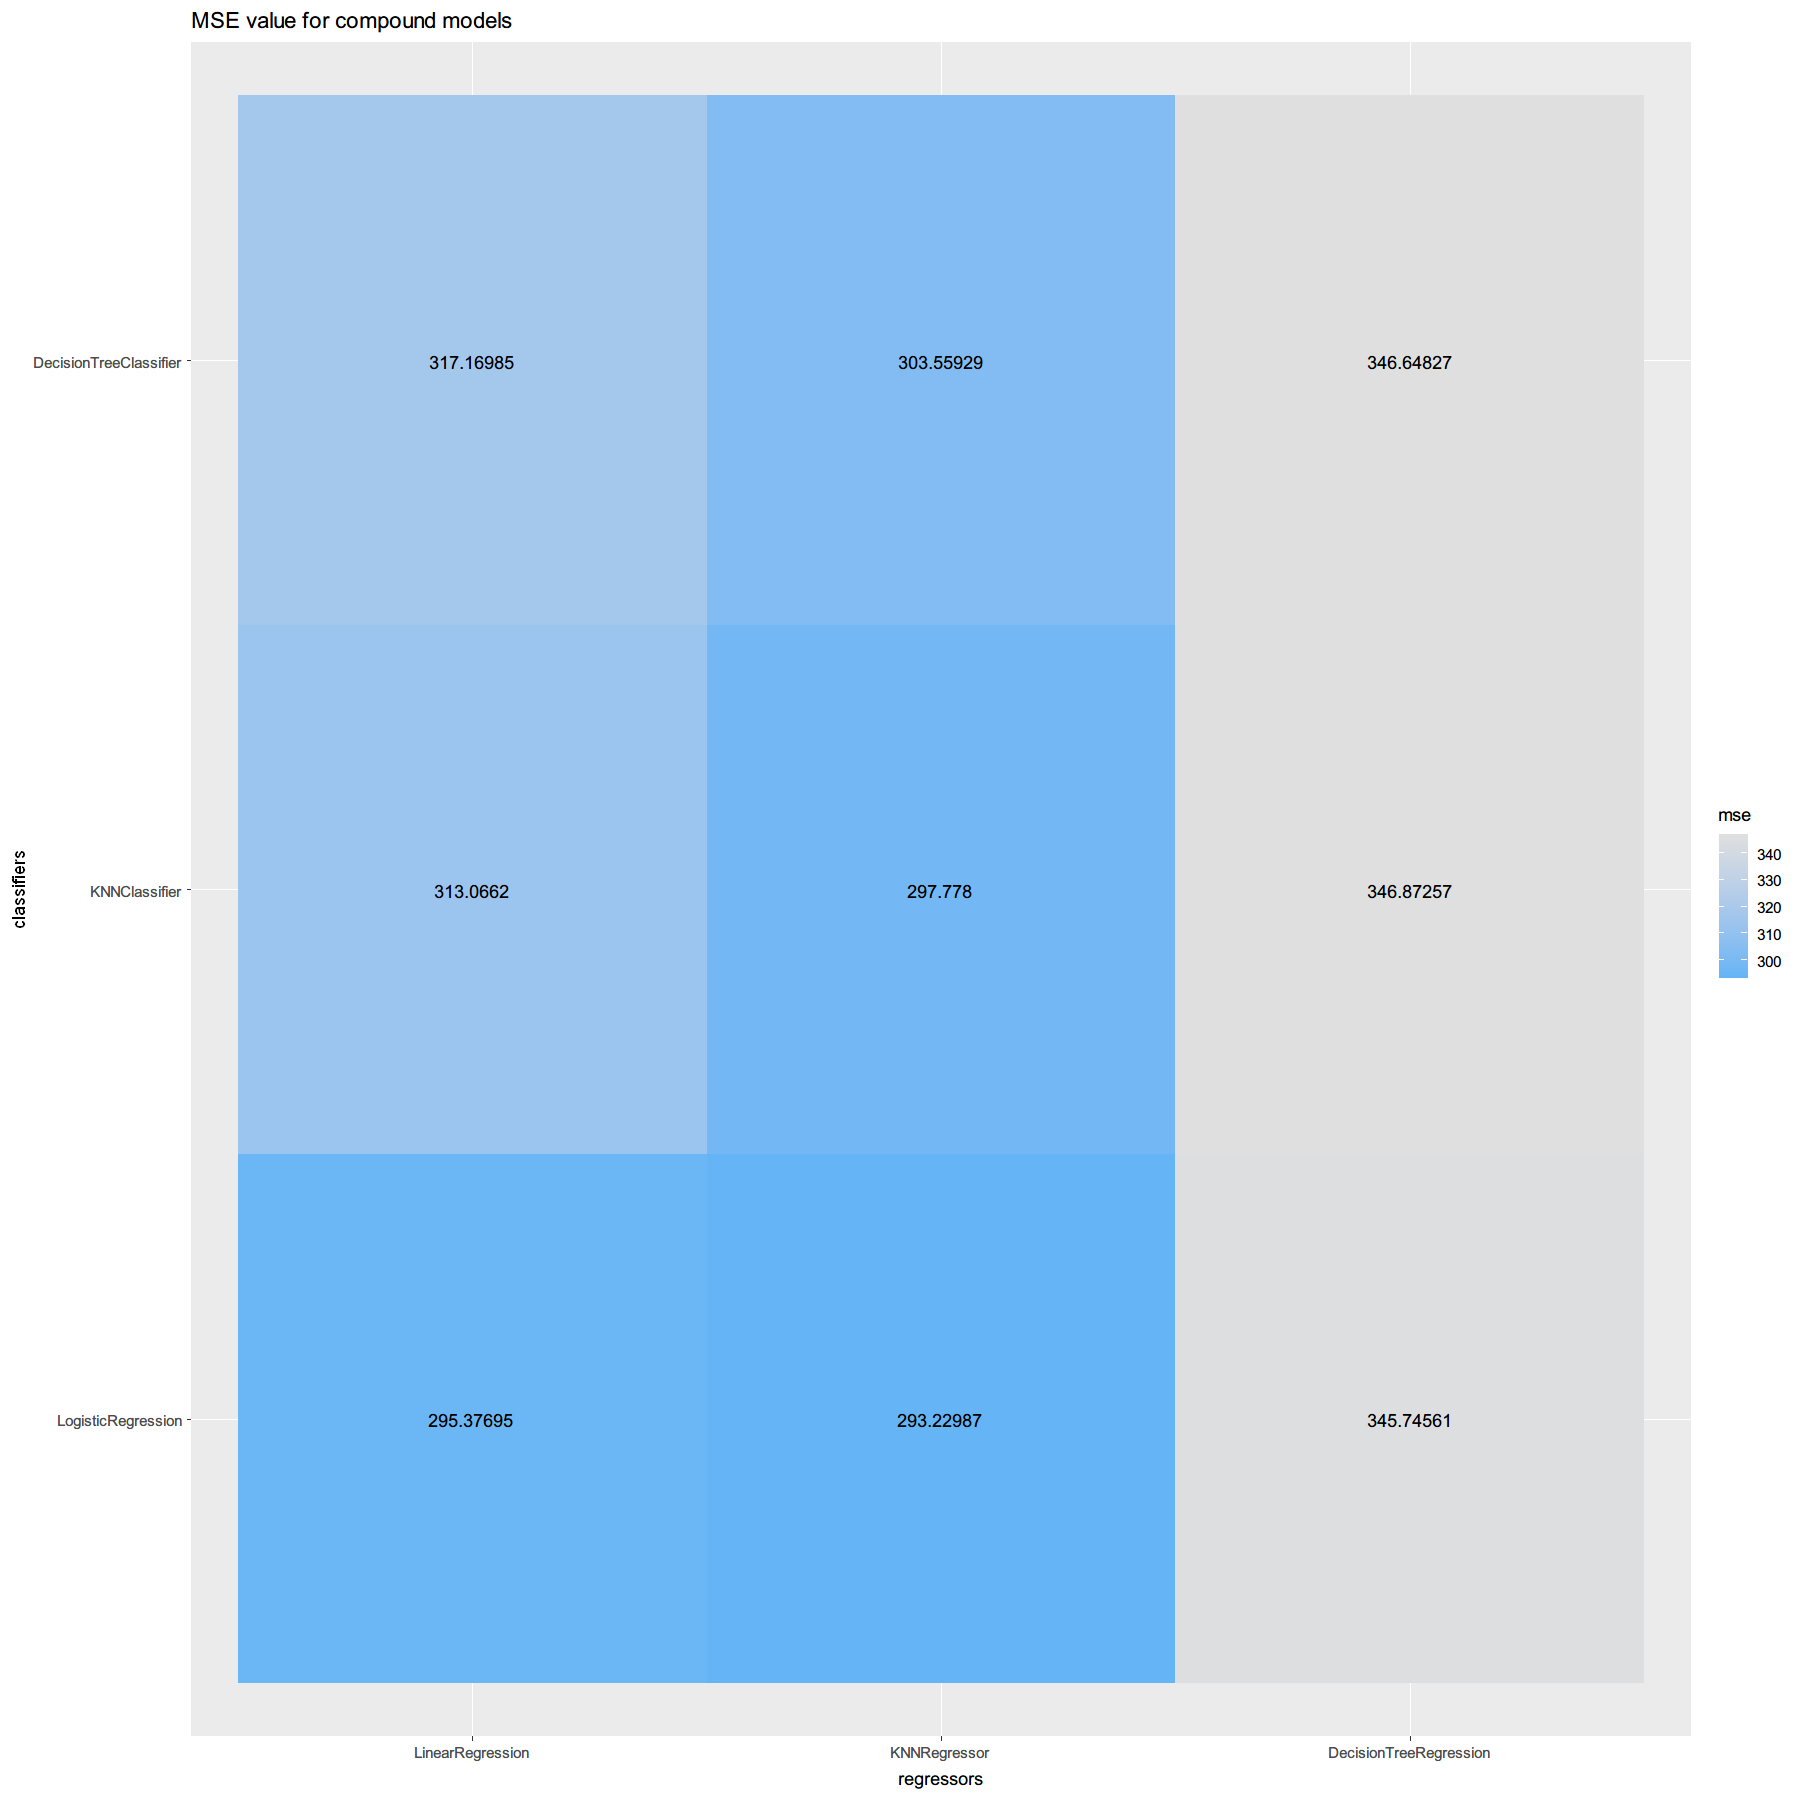

In [92]:
# prepare the list for grid search
regressors <- list(linear_regression, knn_regression, decision_tree_regression)
classifiers <- list(logistic_regression, knn_classifier, decision_tree_classifier)
# grid search of compound model with different regressors and classifiers
grid_search_for_compound_model <- function(regressors_in, classifiers_in,
                                           best_func = min, evaluate_func = mse) {
  results <- data.frame(regressors = character(), classifiers = character(), value = double())
  for (i in 1:length(regressors_in)) {
    reg <- regressors_in[[i]]
    for (j in 1:length(classifiers_in)) {
      cla <- classifiers_in[[j]]
      new_row <- list(regressors = i, classifiers = j,
                      value = CompoundModel(cla, reg)$
                                pred_evaluate(test_data, test_data_comb, evaluate_func))
      results <- rbind(results, new_row)
    }
  }
  best_result <- best_func(results$value)
  best_index <- which(results$value == best_result)[1]
  best_x_index <- results$regressors[best_index]
  best_y_index <- results$classifiers[best_index]
  results <- results %>%
    mutate(reg_name = sapply(regressors, function(x) class(regressors_in[[x]]))) %>%
    mutate(cla_name = sapply(classifiers, function(x) class(classifiers_in[[x]])))
  print(paste0("Best regressor: ", regressors_in[[best_x_index]] %>% class))
  print(paste0("Best classifier: ", classifiers_in[[best_y_index]] %>% class))

  list(tile = geom_tile(data = results, mapping = aes(x = regressors, y = classifiers,
                                                      fill = value)),
    annotation = annotate("text", x = best_x_index, y = best_y_index,
                          label = paste0("best=", best_result)),
    text = geom_text(data = results, aes(x = regressors, y = classifiers,
                                         label = round(value, 5))),
    regressors = regressors_in[best_x_index],
    classifiers = classifiers_in[best_y_index],
    best_result = best_result,
    results = results)
}

results <- grid_search_for_compound_model(regressors, classifiers)

ggplot() + results$tile + results$text +
  scale_x_discrete(limits = sapply(regressors, class)) +
  scale_y_discrete(limits = sapply(classifiers, class)) +
  scale_fill_gradientn(colors = c(blue, gray)) +
  labs(fill = "mse") +
  ggtitle("MSE value for compound models")

From the plot output, the compound model with LogisticRegression and KNNRegressor has
lowest MSE value.

In [93]:
# choose best compound model
compound_model <- CompoundModel(logistic_regression, knn_regression)
compound_model$pred_evaluate(test_data, test_data_comb, evaluate_func = mse)

[1] 293.2299

## 4. Model Comparsion<a class="anchor" id="sec_4"></a>

In the assignment, only 3 models are required to comparison. Therefore, the best 3 models
will be selected by observing the MSE in the first step.

In this section, one most suitable will be selected by more metrics for the last section,
Variable Identification and Explanation.

### Select best 3 models
The first step is to plot a bar chart to compare compound model with other 3 regression
models.

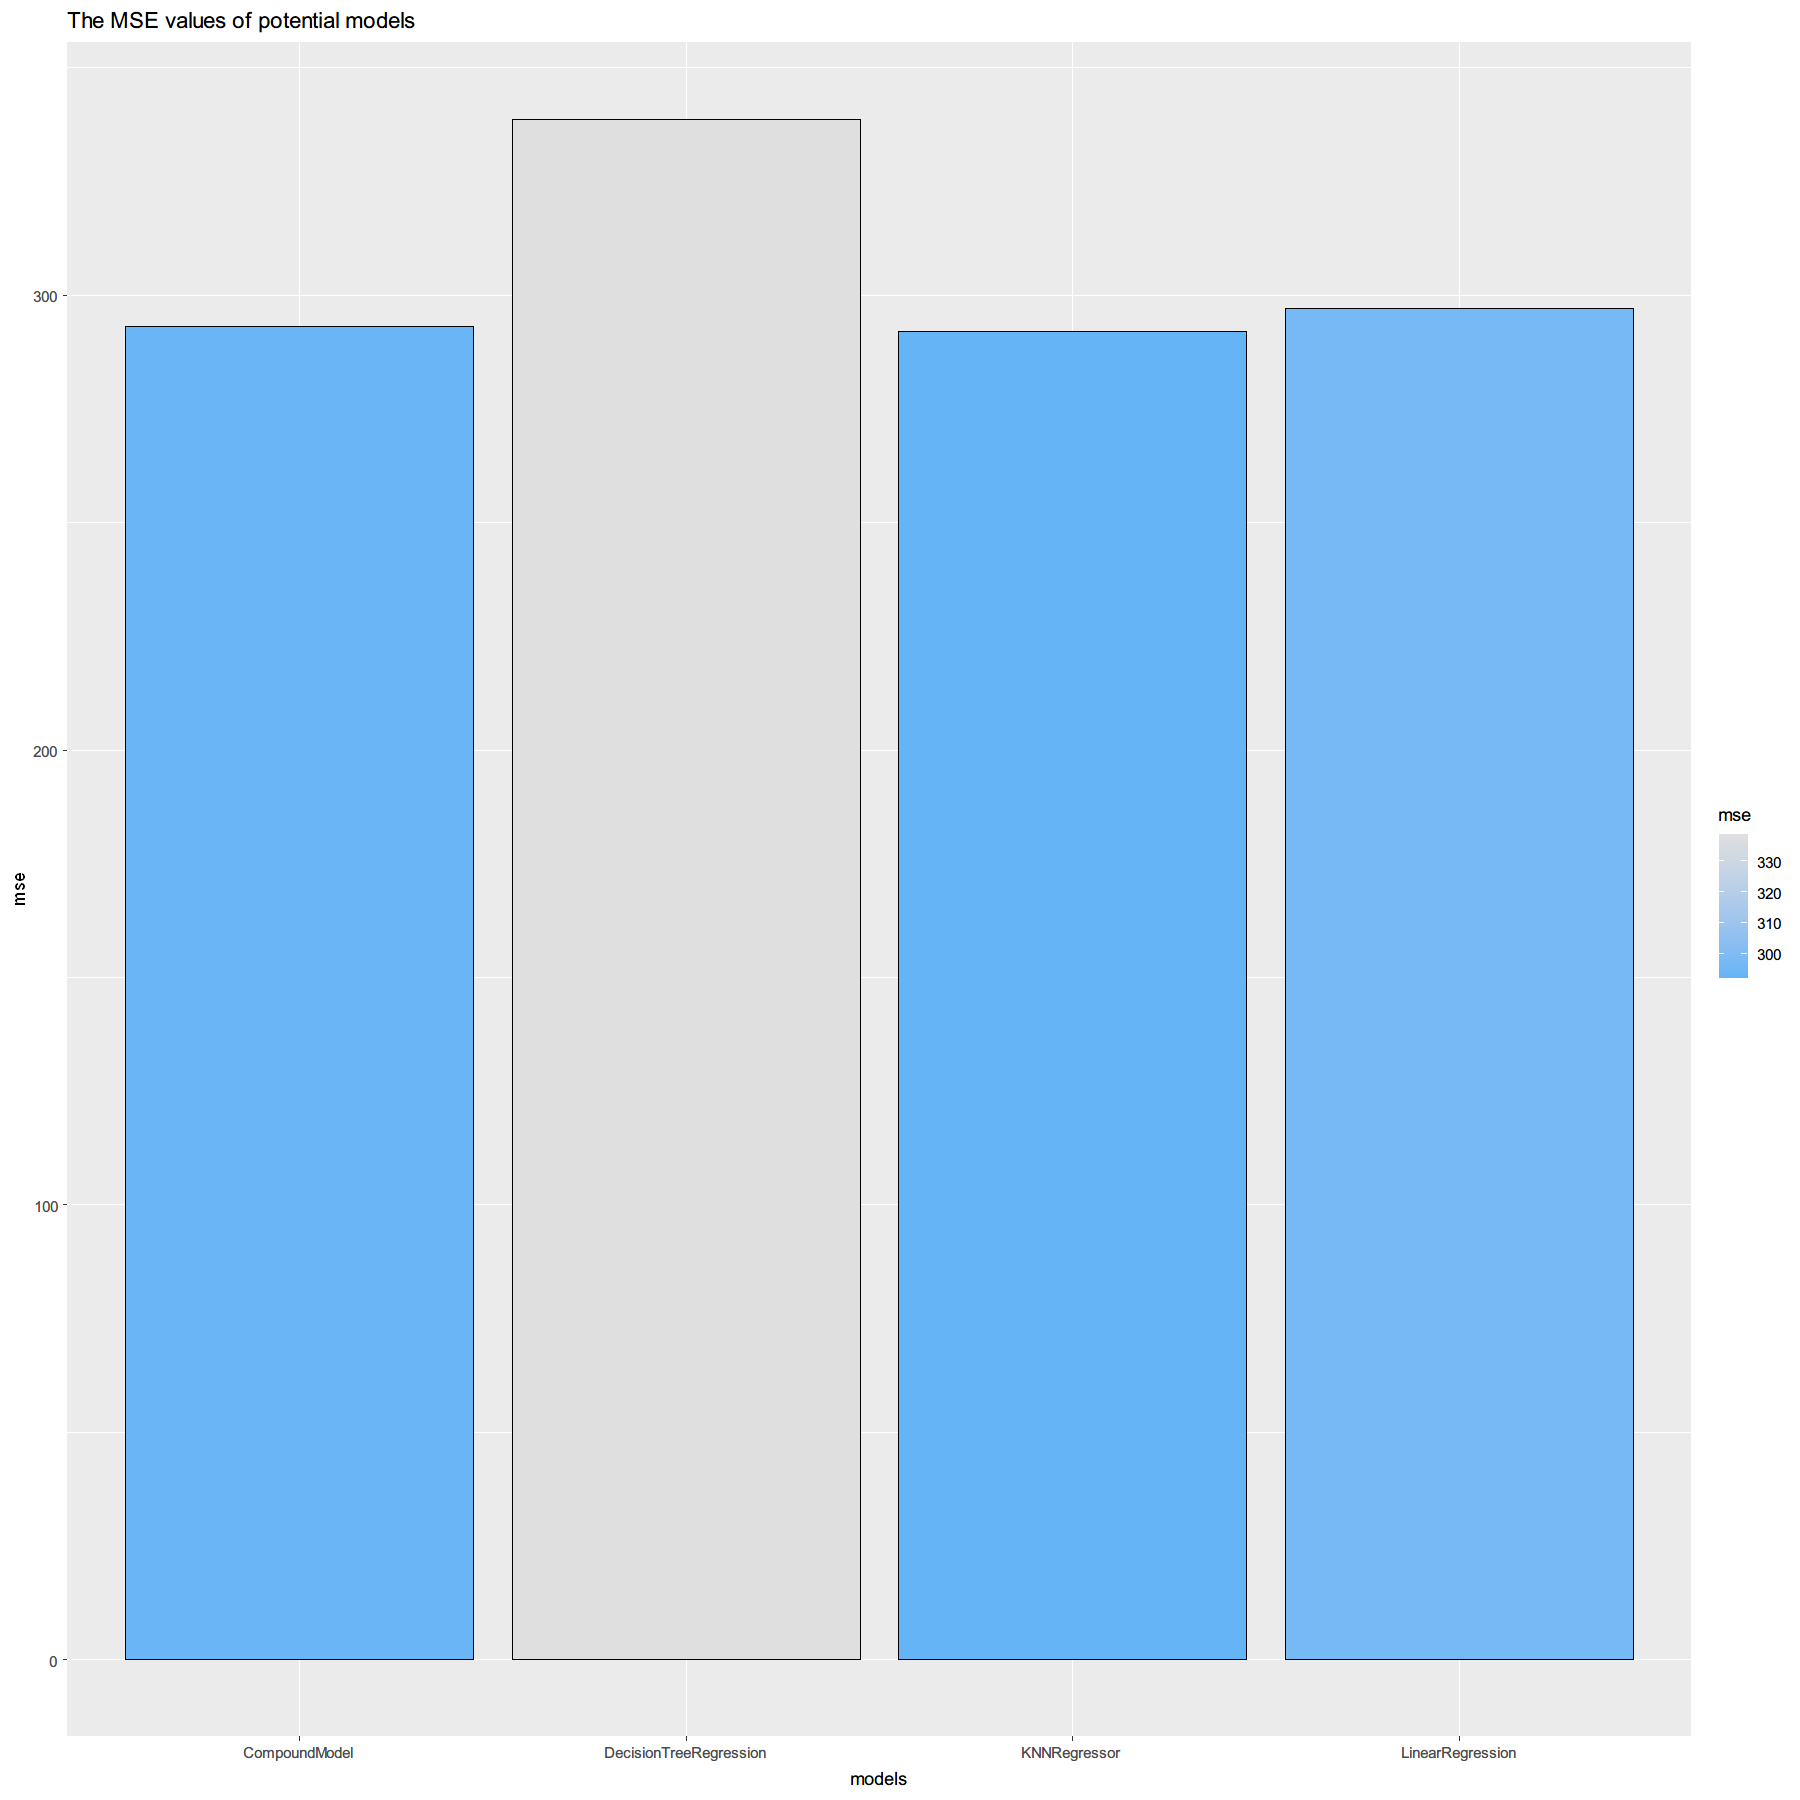

In [94]:
regressors_errors <- c(regressors %>% sapply(evaluate_model, evaluate_func = mse),
                       compound_model$pred_evaluate(test_data, test_data_comb,
                                                    evaluate_func = mse))

ggplot(data = data.frame(reg_name = c(sapply(regressors, class), "CompoundModel"),
                         error = regressors_errors)) +
  geom_bar(mapping = aes(x = reg_name, y = error, fill = error),
           stat = "identity", color = "black") +
  scale_fill_gradientn(colors = c(blue, gray)) +
  labs(x = "models", y = "mse", fill = "mse") +
  ggtitle("The MSE values of potential models")

From the plot, the DecisionTreeRegression performs bad compared with other models.

In this section, these 3 models will be compared with multiple metrics. The most common
metrics used in model development is MSE (Mean Squared Error).

### RMSE
Another common metric is RMSE (Rooted Mean of Squared Error).
As the RMSE (Rooted Mean of Squared Error) is the value of rooted MSE, and the function of root
is monotonically increasing; therefore, it will not change the order of the value of MSE.
However, the RMSE is the rooted square error, so it is meaningful to be compared with
MAE (Mean of Absolute Error). Therefore, it is necessary to observe the visualization of
RMSE.

Plot the bar chart for 3 selected models.

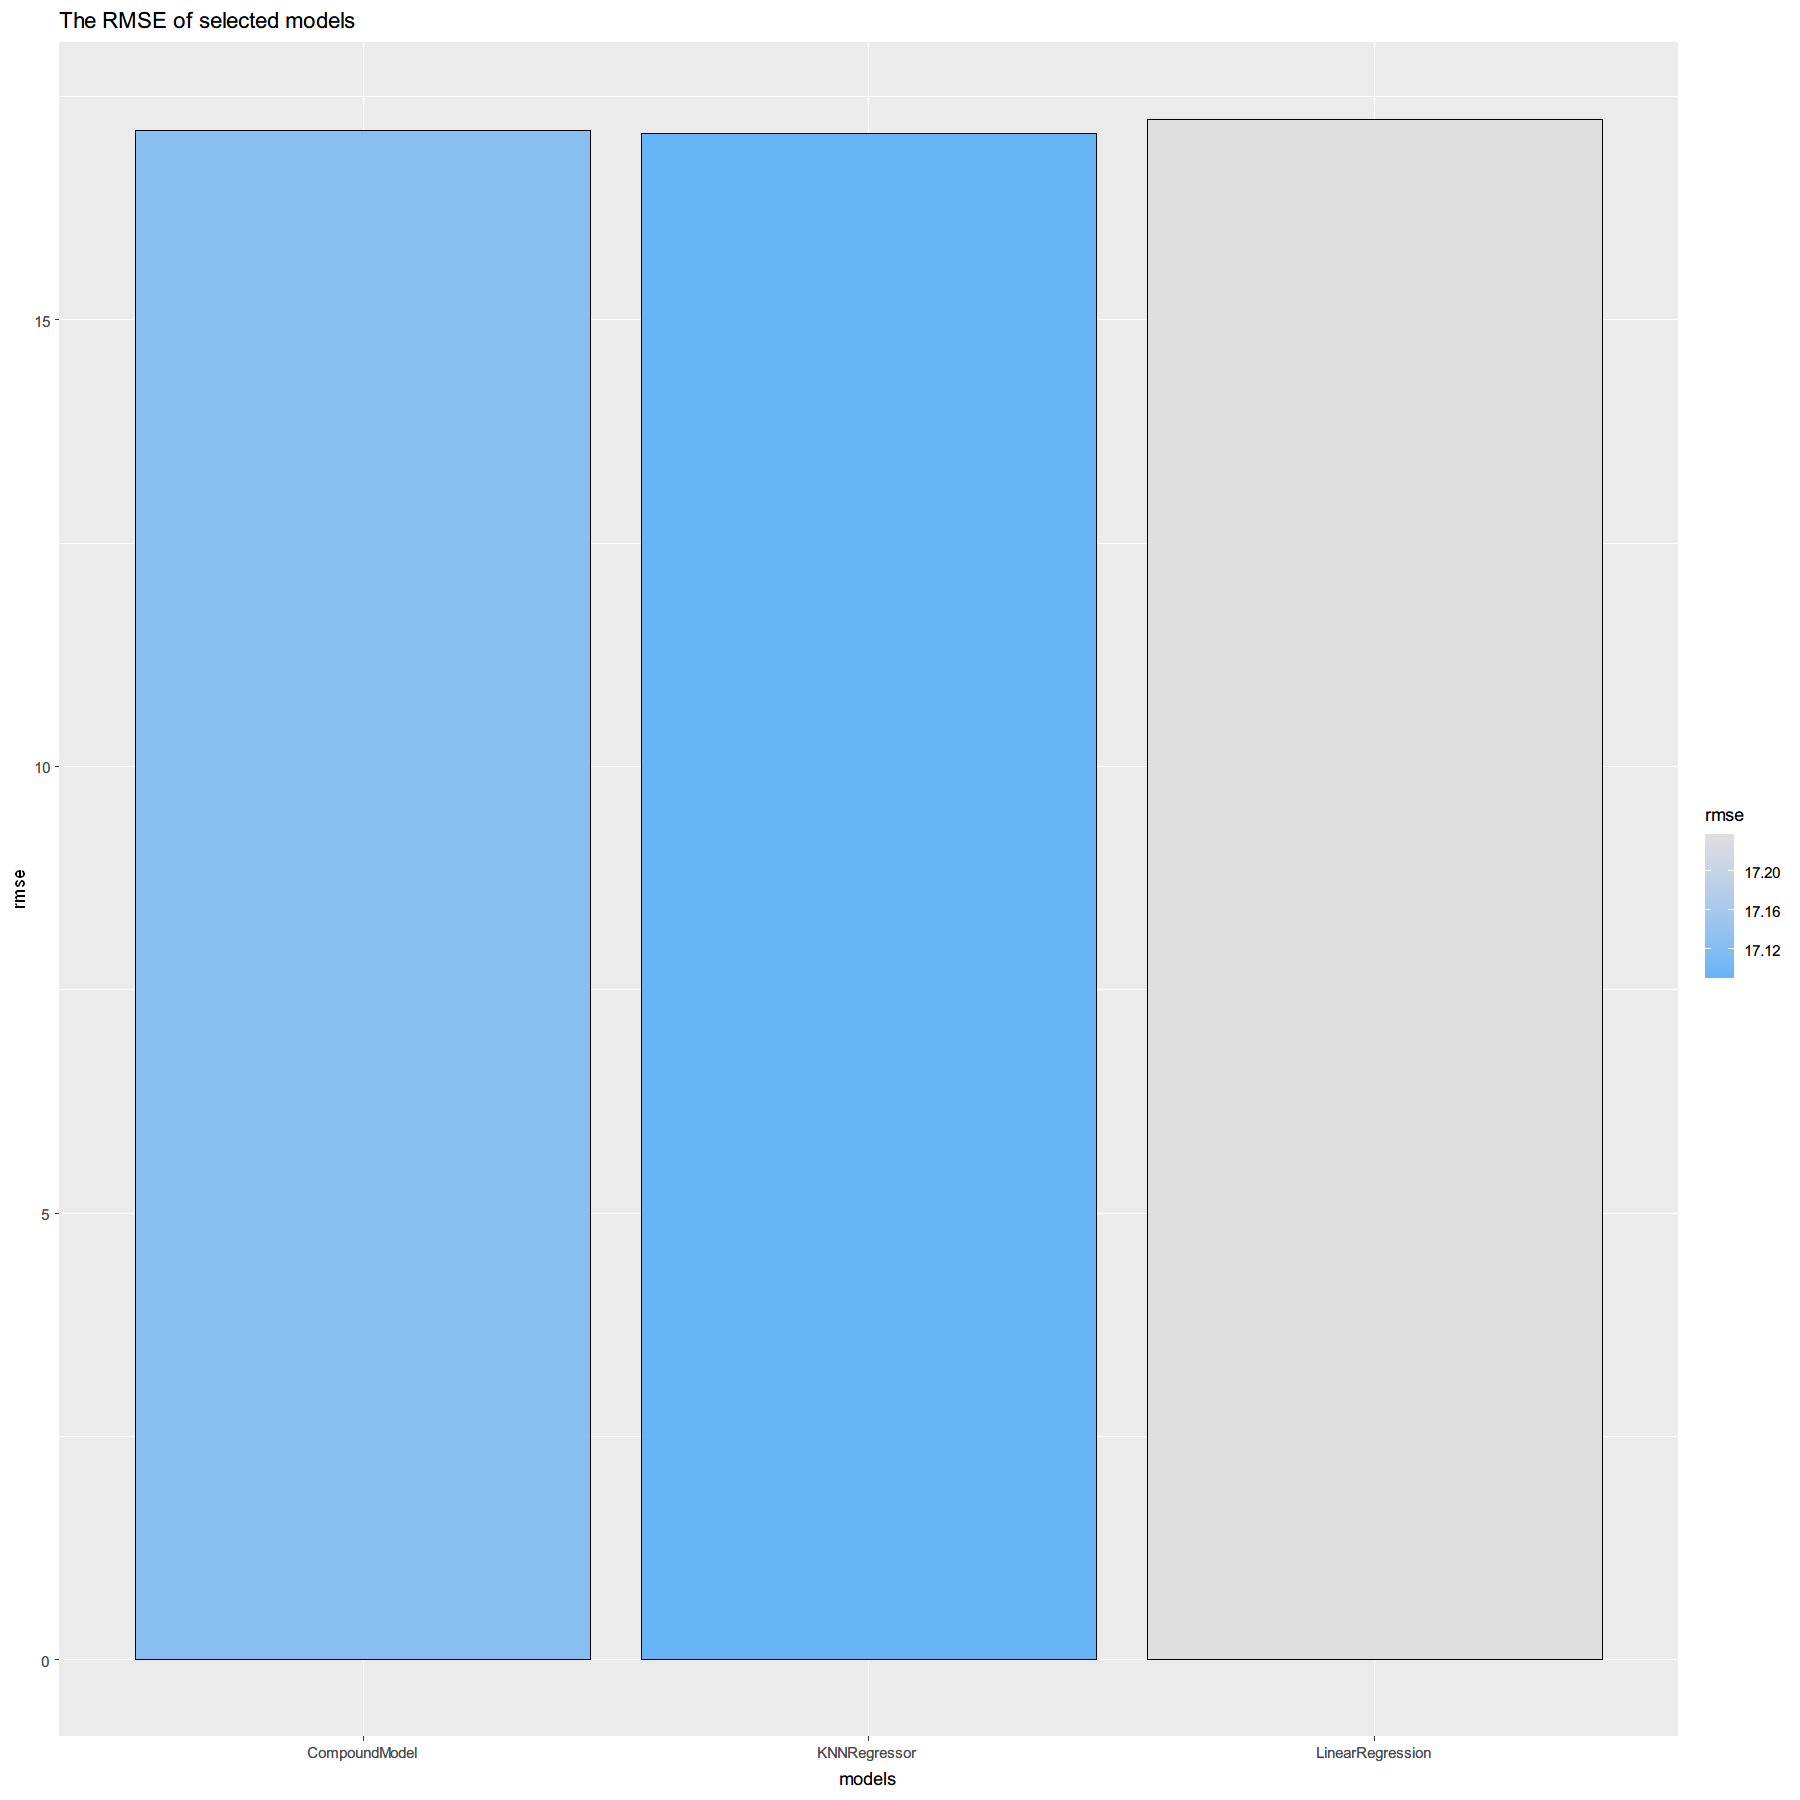

In [95]:
# choose top 3 models as required
models <- c(linear_regression, knn_regression, compound_model)
model_names <- models %>% sapply(class)
model_rmse <- c(sapply(models[-3], evaluate_model, evaluate_func = rmse),
               compound_model$pred_evaluate(test_data, test_data_comb, rmse))
ggplot(mapping = aes(x = model_names, y = model_rmse, fill = model_rmse)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_gradientn(colors = c(blue, gray)) +
  labs(x = "models", y = "rmse", fill = "rmse") +
  ggtitle("The RMSE of selected models")

From the result of RMSE, the KNNRegressor is the best model for this data. The Compound Model
has similar score, but the Linear Regression is not suitable.

### MAE
Besides, the MAE (Mean Absolute Error) is also a good metrics for regression, which is calculated by
the absolute value rather than the squared value, which means the metrics have larger tolerance
on errors.

Plot a bar chart for MAE of models.

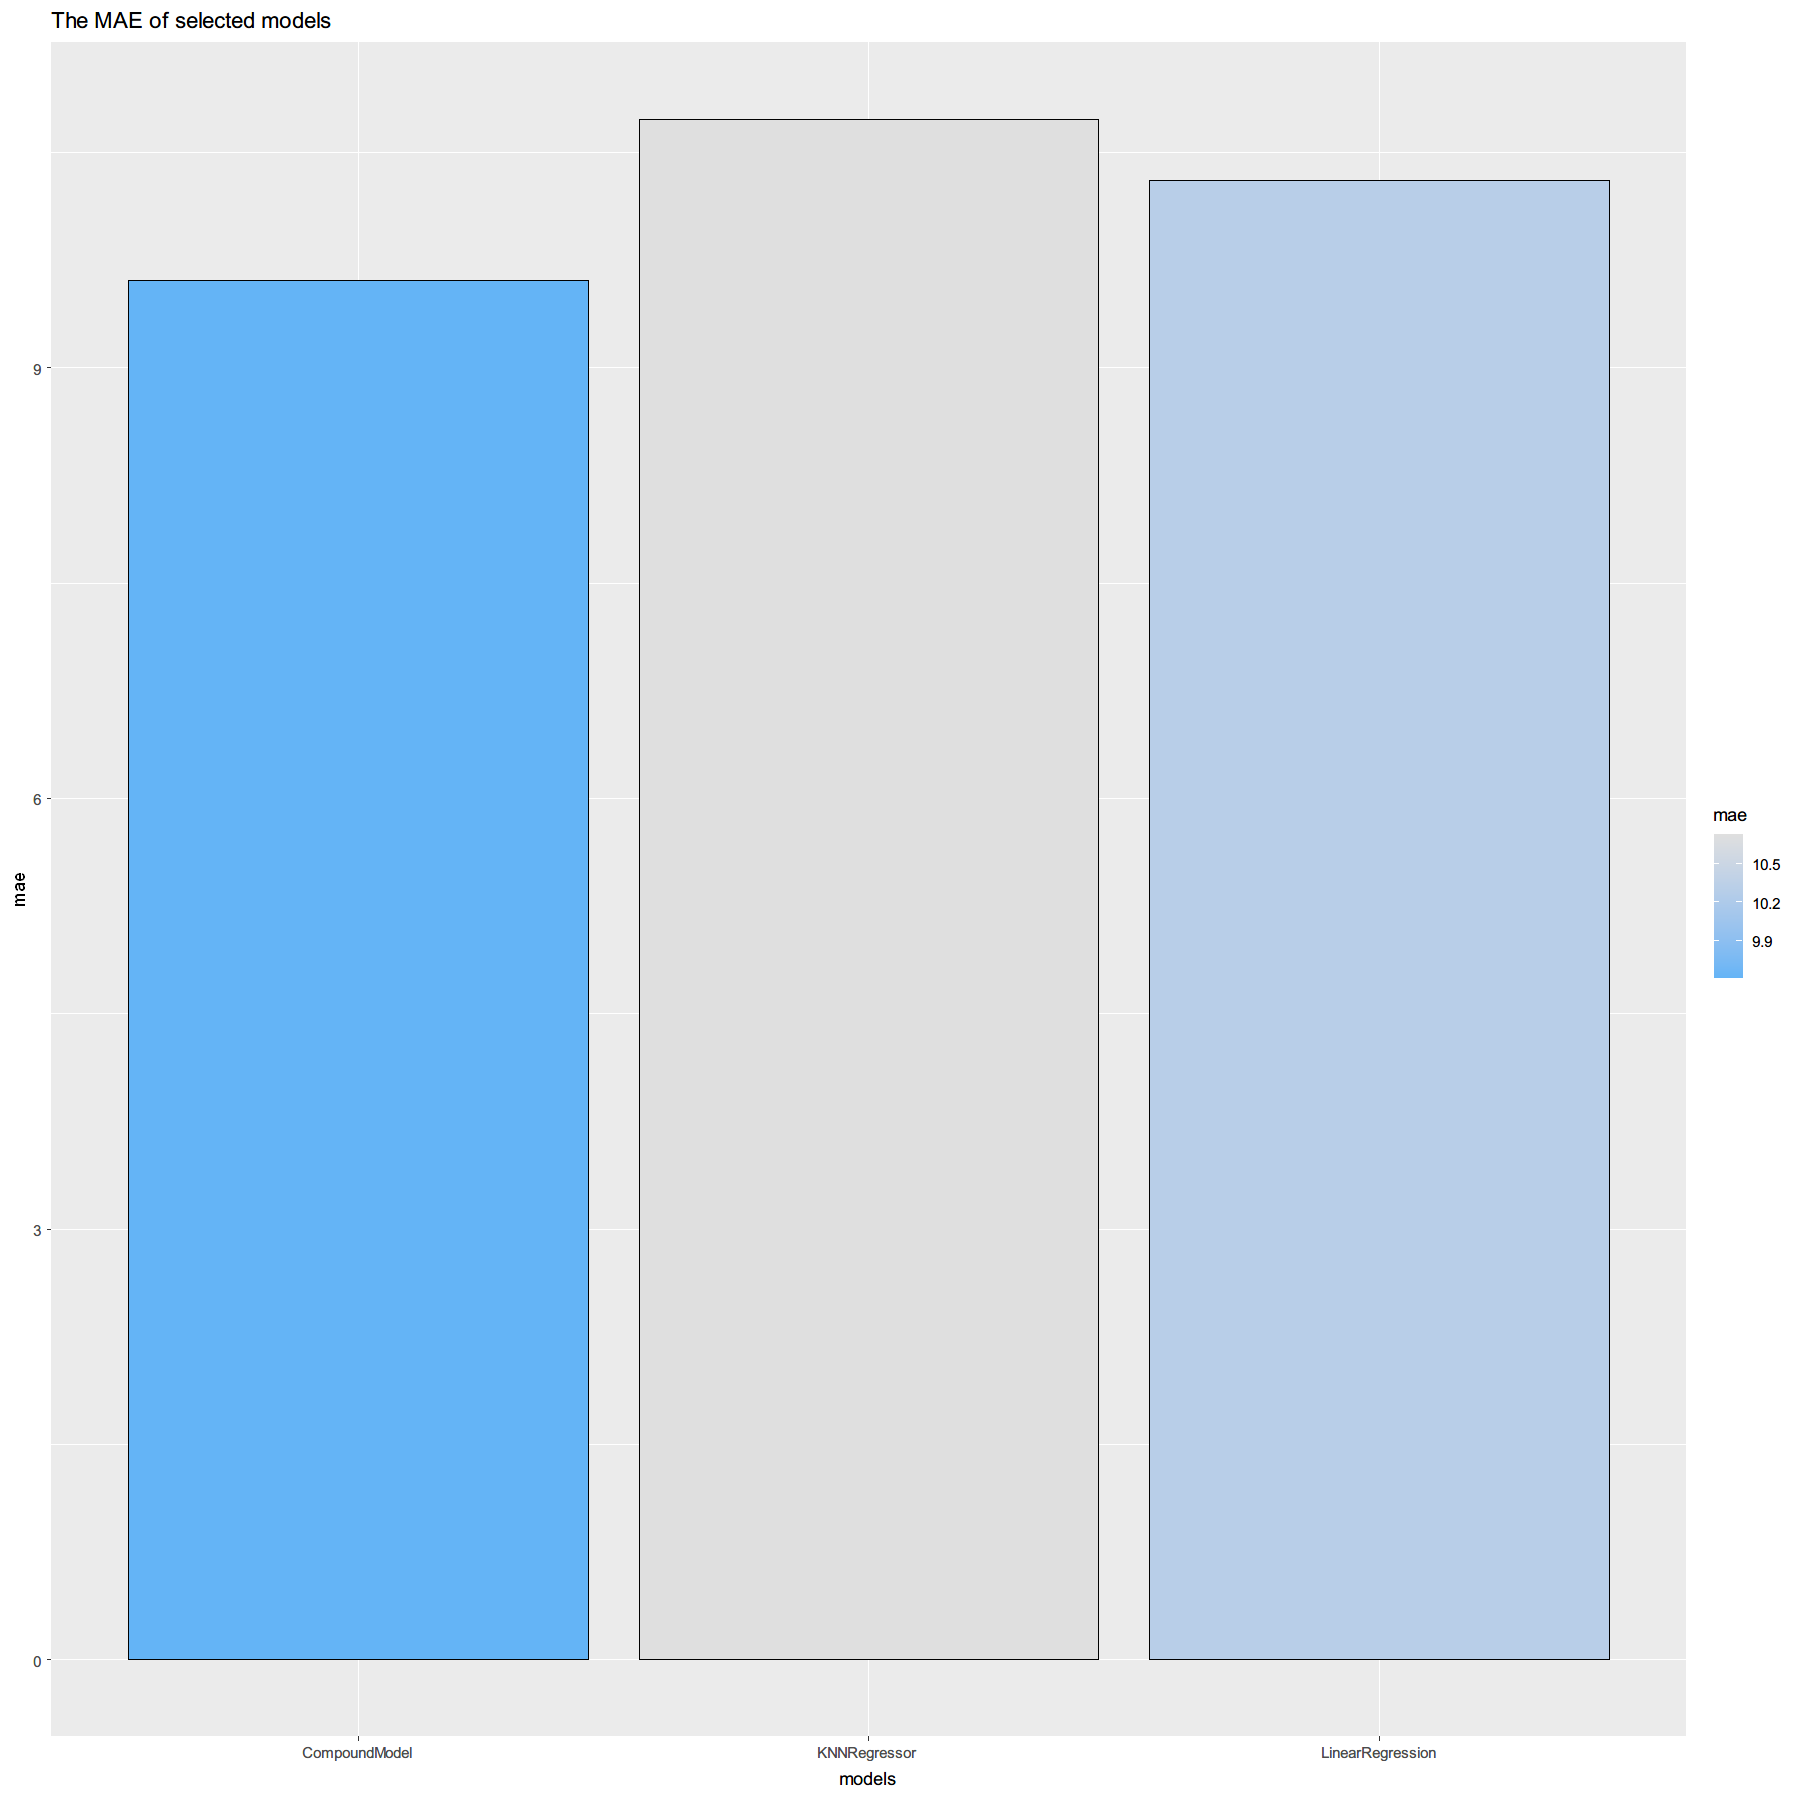

In [96]:
model_mae <- c(sapply(models[-3], evaluate_model, evaluate_func = mae),
               compound_model$pred_evaluate(test_data, test_data_comb, mae))
ggplot(mapping = aes(x = model_names, y = model_mae, fill = model_mae)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_gradientn(colors = c(blue, gray)) +
  labs(x = "models", y = "mae", fill = "mae") +
  ggtitle("The MAE of selected models")

From the results of MAE scores, the Compound Model is better than others. The KNN Regressor,
which performs the best in RMSE, is not good in MAE metrics. From the results, the value of
MAE (about 10) is significantly lower than RMSE (about 17), which means the distribution of
`area` spreads widely, and the model is difficult to predict the `area` value accurately.

### R-squared
Another famous metrics for regression is $R^2$ score, which is calculated by
$$
R^2 = 1 - \frac{RSS}{TSS}
$$

Plot a bar chart for $R^2$ scores of models.

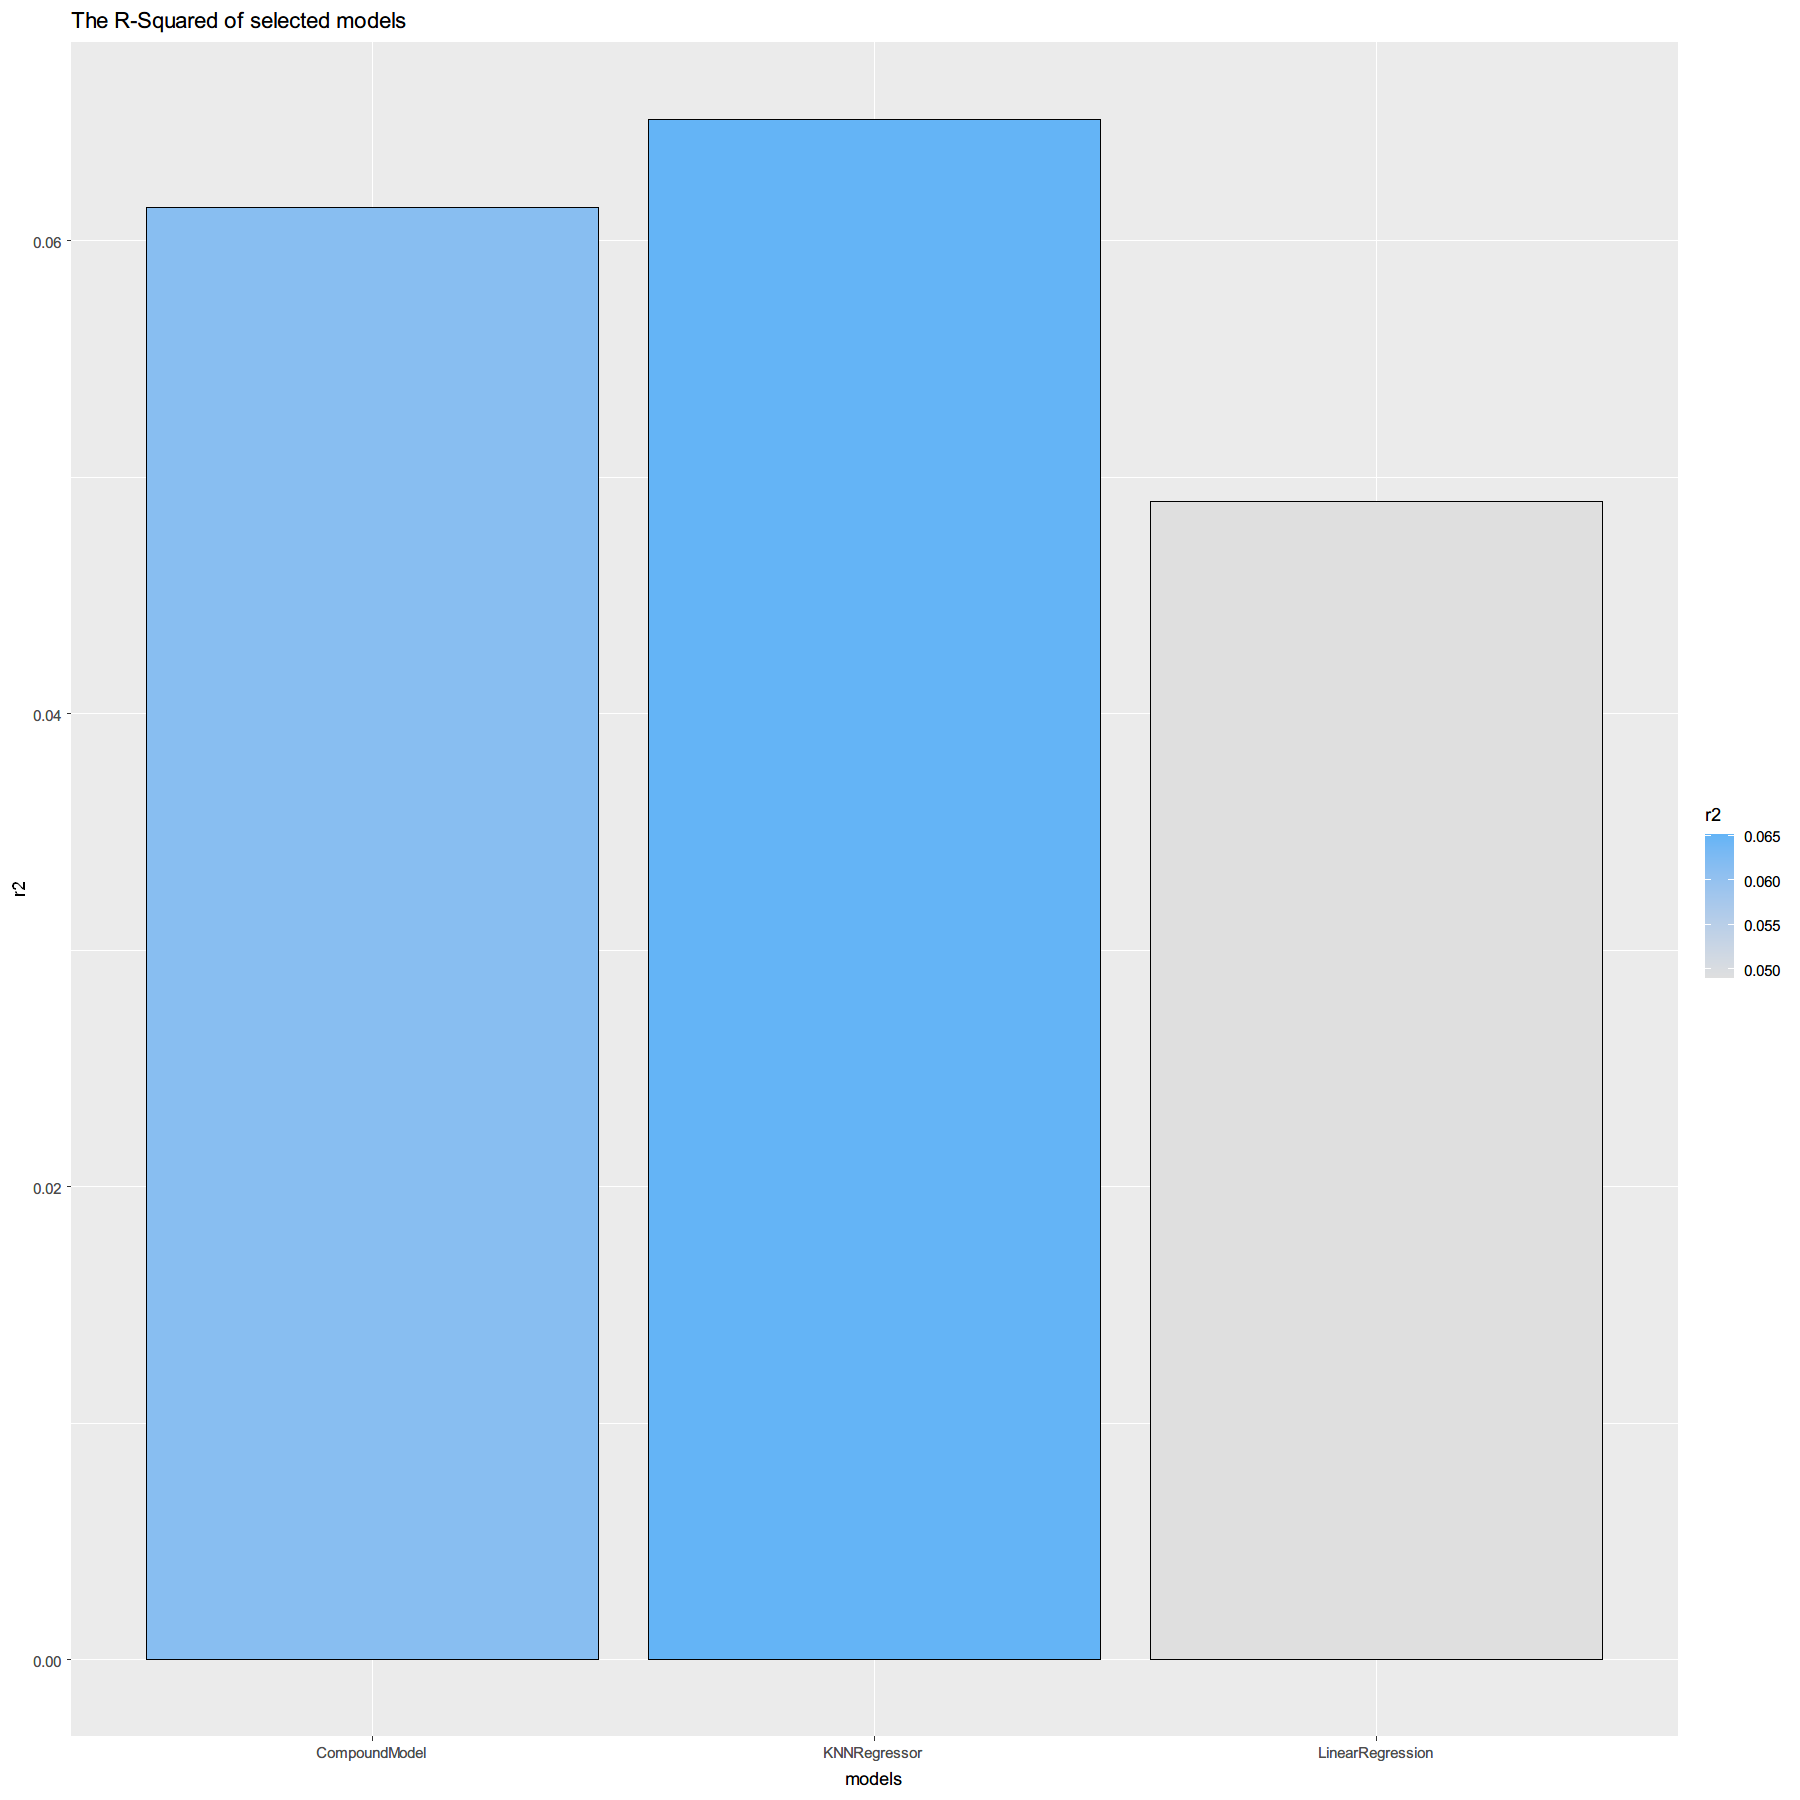

In [97]:
model_r2 <- c(sapply(models[-3], evaluate_model, evaluate_func = r2),
               compound_model$pred_evaluate(test_data, test_data_comb, r2))
ggplot(mapping = aes(x = model_names, y = model_r2, fill = model_r2)) +
  geom_bar(stat = "identity", color = "black") +
  scale_fill_gradientn(colors = c(gray, blue)) +
  labs(x = "models", y = "r2", fill = "r2") +
  ggtitle("The R-Squared of selected models")

However, the $R^2$ score might not be reliable in non-linear models, which means this
metric is not suitable to compare the models.

Therefore, only the RMSE and MAE are used for model selection.

### Select best model
The RMSE and MAE is combined for select the best model.

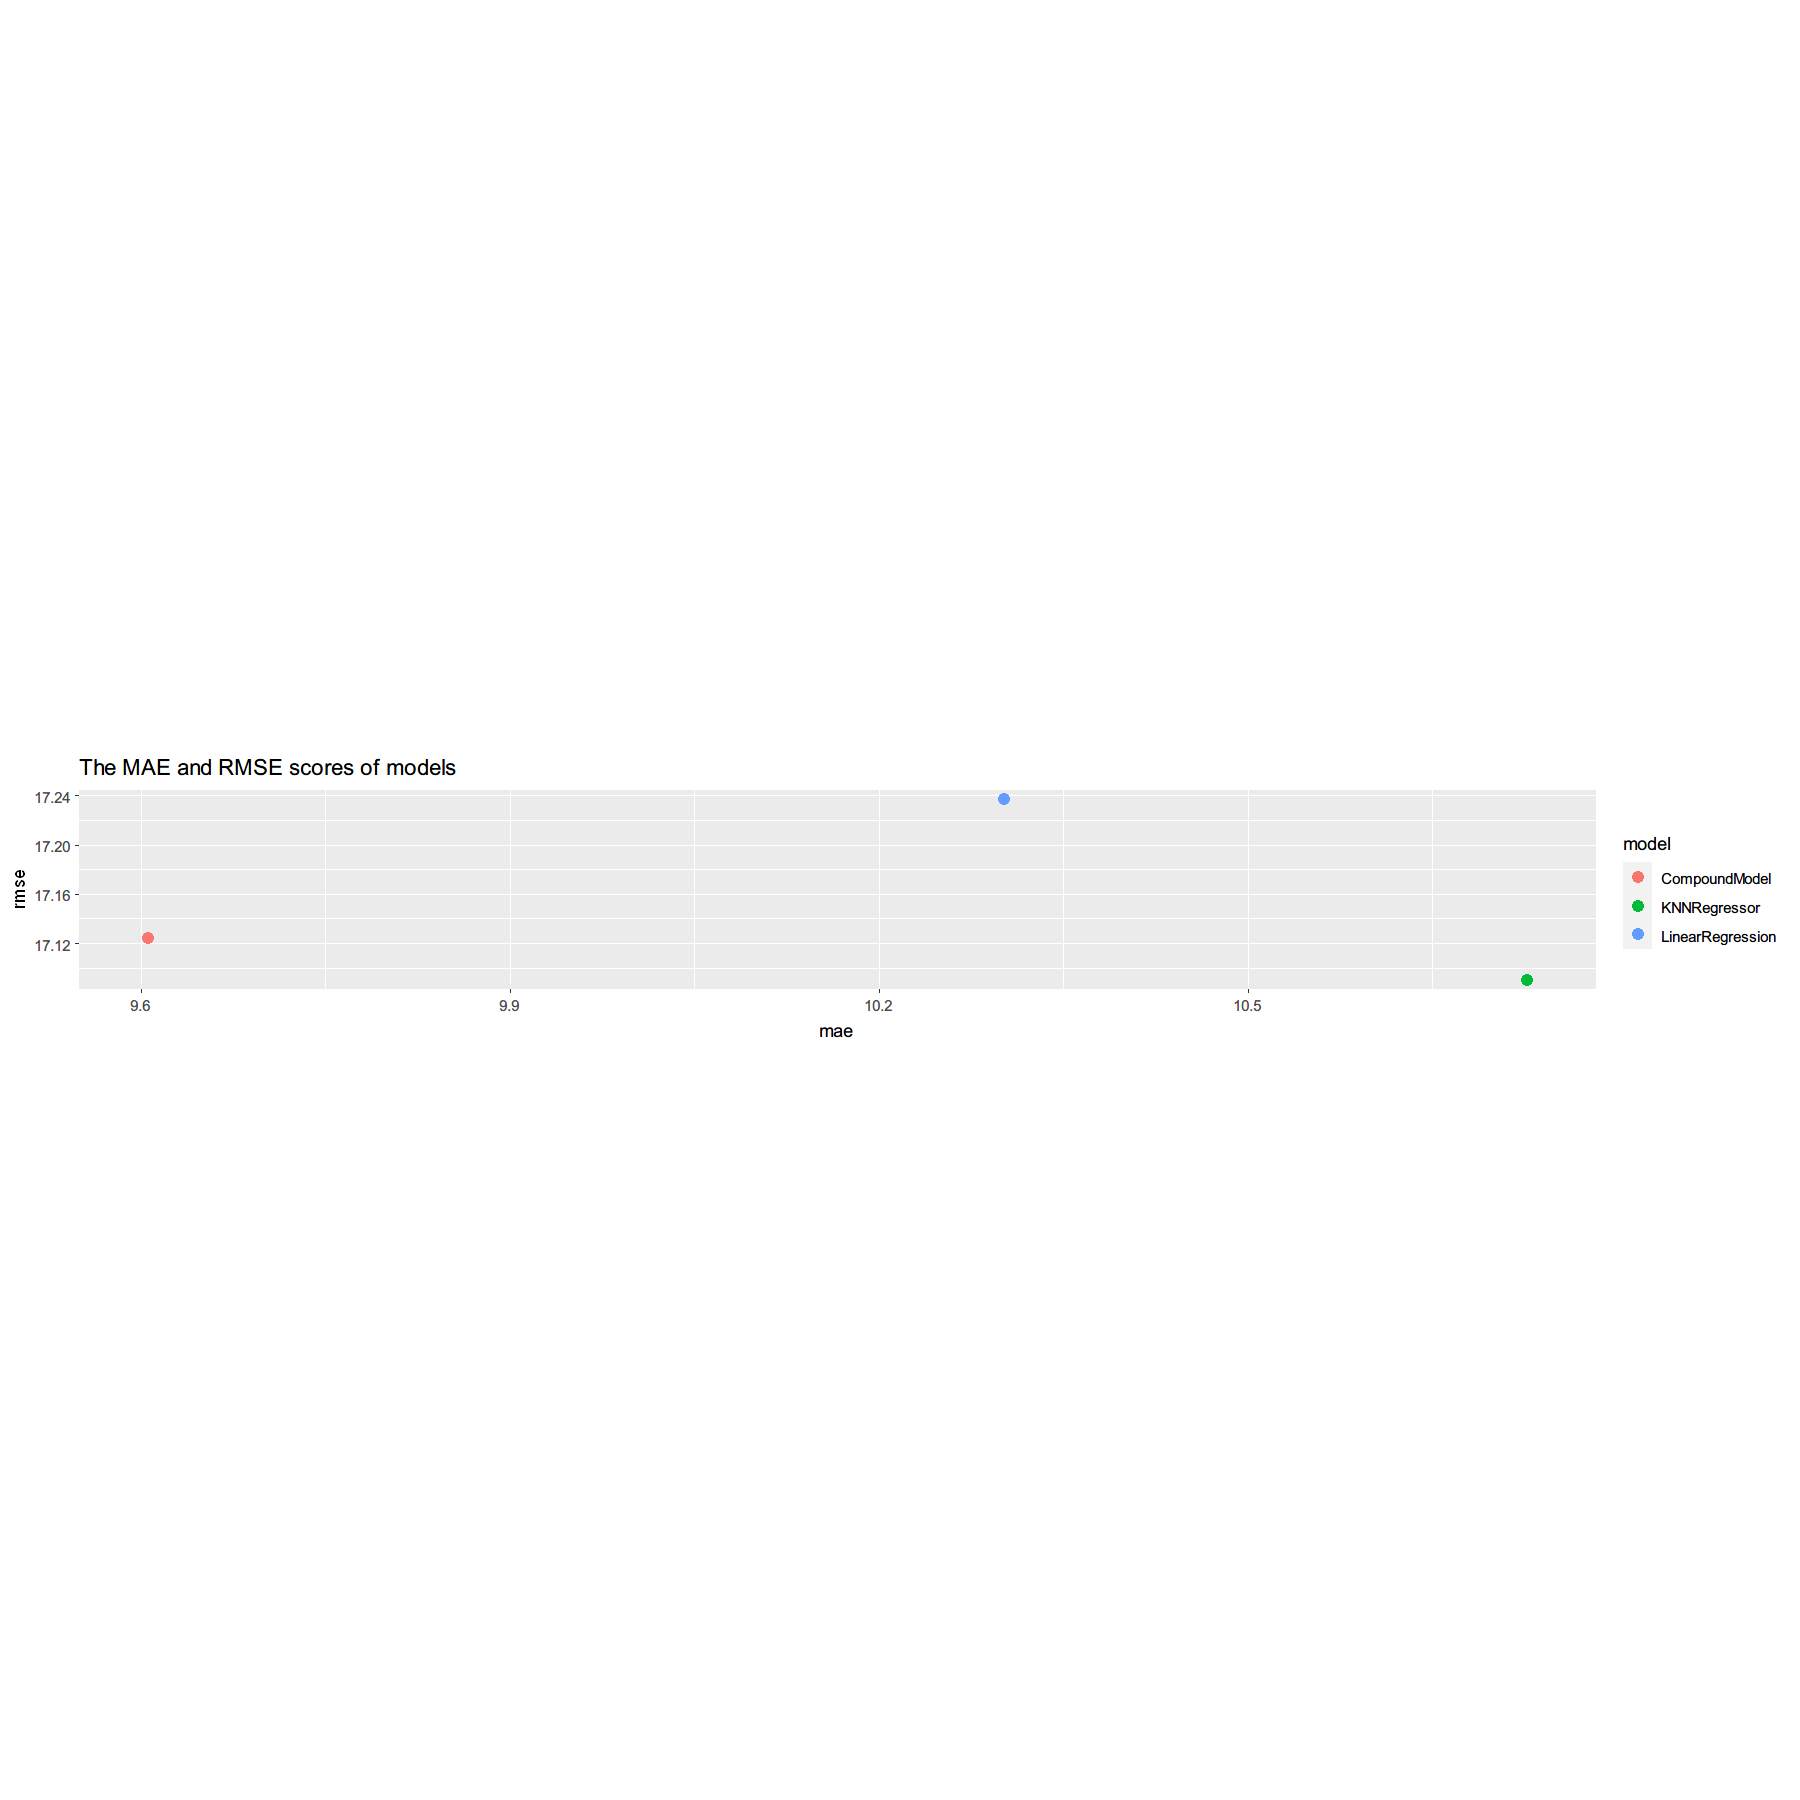

In [98]:
ggplot(data.frame(name = model_names, rmse = model_rmse, mae = model_mae)) +
  geom_point(aes(x = mae, y = rmse, color = name), size = 3) +
  labs(color = "model") +
  coord_fixed() +
  ggtitle("The MAE and RMSE scores of models")

For better visualizing the RMSE nad MAE, the scales of X-axis and Y-axis are fixed as
same scaling. So, the most left bottom model is the best model for this data.

Therefore, the best model is the compound model which is formed by a logistic regression
and a KNN regressor.


## 5. Variable Identification and Explanation <a class="anchor" id="sec_5"></a>


In the previous section, the compound model is selected as the best model for the dataset.
The compound model is formed by a logistic regression and a KNN regressor.

The logistic regression predict if the data will cause a fire or not. It has strong
interpretability, it can describe how important the features are. The logistic
regression is built based on the sub-select of `comb_data` features
which contains the extra features like cubic features,
and the features combined by original features.

First, apply the `summary` built-in function to examine the model of the logistic regression.

In [99]:
model_summary <- compound_model$classifier$model %>% summary
model_summary


Call:
glm(formula = fire ~ month_dec + month_nov + day_tue + DC + RH + 
    X.FFMC + X.DC + X.temp + Y.FFMC + Y.DC + Y.ISI + Y.RH + Y.wind + 
    FFMC.DMC + DMC.temp + DMC.RH + DMC.rain + DC.ISI + DC.temp + 
    DC.rain + ISI.temp + ISI.RH + RH.wind + X.3 + FFMC.3 + DMC.3 + 
    DC.3 + RH.3, family = binomial, data = .self$train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0119  -1.0372   0.2296   0.9974   2.1058  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.702e+00  2.355e+00  -1.572 0.115899    
month_dec    2.105e+01  2.046e+03   0.010 0.991792    
month_nov   -1.943e+01  6.523e+03  -0.003 0.997624    
day_tue      9.882e-01  4.164e-01   2.373 0.017628 *  
DC          -1.206e-02  3.889e-03  -3.100 0.001935 ** 
RH           1.294e-01  4.563e-02   2.837 0.004557 ** 
X.FFMC       1.084e-02  3.363e-03   3.223 0.001270 ** 
X.DC        -6.415e-04  3.285e-04  -1.953 0.050830 .  
X.temp      -3.742e-02  1.065e-02  -3.514 0

Although, the features input has been filtered by AIC stepwise, the model should be
filtered with only the important features for better observation.

The method of filtering is to check if the p-value is smaller than $0.01$ .

In [100]:
important_features <- model_summary$coefficients[
        model_summary$coefficients[,"Pr(>|z|)"] < 0.01,]
important_features

,Estimate,Std. Error,z value,Pr(>|z|)
DC,-0.0120552501,3.888745e-03,-3.100036,1.934971e-03
RH,0.1294309379,4.562540e-02,2.836818,4.556561e-03
X.FFMC,0.0108382429,3.363180e-03,3.222617,1.270251e-03
X.temp,-0.0374186282,1.064715e-02,-3.514425,4.407066e-04
Y.DC,0.0017486687,5.477300e-04,3.192574,1.410108e-03
Y.RH,-0.0325505892,8.135959e-03,-4.000830,6.312075e-05
FFMC.DMC,0.0007001665,2.532464e-04,2.764764,5.696392e-03
DC.temp,0.0004130788,1.557132e-04,2.652817,7.982307e-03
ISI.temp,0.0182827471,5.865118e-03,3.117200,1.825776e-03
RH.wind,0.0110799129,3.954653e-03,2.801741,5.082773e-03


From the output, some features have significant influence on the model. Many
of them are the multiplication of 2 original features, such as `X*FFMC`, `X*temp`,
`Y*DC`, `Y*RH`, `FFMC*DMC`. Also, there are still some original features having some
influences like `DC` and `RH`. Besides, some features have non-linear correlation to
the `area` value, which means some cubic features, like `FFMC^3`.


Then, select the estimate coefficients are positive to filter the features which
have positive correlations.

In [101]:
# positive correlation
important_features[important_features[,"Estimate"] > 0, ]

,Estimate,Std. Error,z value,Pr(>|z|)
RH,0.1294309379,0.0456253967,2.836818,0.004556561
X.FFMC,0.0108382429,0.0033631801,3.222617,0.001270251
Y.DC,0.0017486687,0.0005477300,3.192574,0.001410108
FFMC.DMC,0.0007001665,0.0002532464,2.764764,0.005696392
DC.temp,0.0004130788,0.0001557132,2.652817,0.007982307
ISI.temp,0.0182827471,0.0058651182,3.117200,0.001825776
RH.wind,0.0110799129,0.0039546535,2.801741,0.005082773


From the output, it is clearly that the features above has some positive
correlations. However, many of them are interaction features, so it is not easy to
interpret.

For details, the result of `RH` describes
the positive correlation of non-interactive features, which means these features increase
the expectation of the possibility of fire.

From the frequency of occurrences in the list above, the `temp`, `ISI`, `wind`
has some positive impacts on the possibility of fire.

Next step is to observe the negative correlations.

In [102]:
# negative correlation
important_features[important_features[,"Estimate"] < 0, ]

,Estimate,Std. Error,z value,Pr(>|z|)
DC,-0.0120552501,3.888745e-03,-3.100036,1.934971e-03
X.temp,-0.0374186282,1.064715e-02,-3.514425,4.407066e-04
Y.RH,-0.0325505892,8.135959e-03,-4.000830,6.312075e-05
FFMC.3,-0.0000077166,2.891967e-06,-2.668287,7.623903e-03


From the output, these features have negative correlations.

The `DC` and `FFMC` has negative correlations to the prediction. Otherwise, the `X*temp`
and `Y*RH` also has some negative correlations.

As for the KNN regressor, the KNN model is not good on interpretability, so there is nothing
to explain on the KNN regressor.

Therefore, the features,

* `X`: Have some correlation
* `Y`: Have some correlation
* `month`: No correlation
* `day`: No correlation
* `FFMC`: Negative correlation
* `DMC`: Positive correlation
* `DC`: Negative correlation
* `ISI`: Positive correlation
* `temp`: Positive correlation
* `RH`: Have some correlation
* `wind`: Positive correlation
* `rain`: No correlation

## 6. Conclusion <a class="anchor" id="sec_6"></a>

In conclusion, the dataset has been analyzed by visualization, and modelled with some models for
predicting the `area` value. The compound model which is formed by a classifier and a regressor
also provide a decent performance of predicting `area` value. With the detailed analyzing,
the correlation between the features and the `area` value has been examined.

## 7. References <a class="anchor" id="sec_7"></a>


Cortez, P., & Morais, A. D. J. R. (2007). A data mining approach to predict forest fires using meteorological data.

Wickham et al. (2020). Create Elegant Data Visualisations Using the Grammar of Graphics. Retrieved from https://ggplot2.tidyverse.org/

IndrajeetPatil. (2020). ggstatsplot. Retrieved from https://github.com/IndrajeetPatil/ggstatsplot

Li, S. (2020). knn: k-Nearest Neighbour Classification in FNN: Fast Nearest Neighbor Search Algorithms and Applications. Retrieved from https://rdrr.io/cran/FNN/man/knn.html

R-project. (2020). R: The R Project for Statistical Computing. Retrieved from https://www.r-project.org/

Schloerke, B. (2020). GGally. Retrieved from https://ggobi.github.io/ggally/

Yan, Y. (2020). MLmetrics. Retrieved from https://github.com/yanyachen/MLmetrics